# Cicle Historical

### Ciclo 01




# 0.0. Solution Planning ( IOT )

## Input - Entrada

### O problema de negócio

## Output - Saída

## Tasks - Processo

# 0.0. Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import inflection
from datetime import datetime as dtime
from matplotlib import pyplot as plt
from IPython.display import Image
from IPython.core.display import HTML

from scipy import stats as ss
import xgboost as xgb

from boruta import BorutaPy

from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor

D:\Anaconda\programa\envs\kaggle_challenge\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


## 0.1. Helper Functions

In [2]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'ggplot')
    plt.rcParams['figure.figsize'] = [24, 9]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()
    
jupyter_settings()

def describe_num(num_attributes):
    a = num_attributes.describe().T.reset_index()
    
    d4 = pd.DataFrame(num_attributes.apply( lambda x: x.max() - x.min())).T
    d5 = pd.DataFrame(num_attributes.apply( lambda x: x.skew())).T      
    d6 = pd.DataFrame(num_attributes.apply( lambda x: x.kurtosis())).T
    d7 = pd.DataFrame(num_attributes.apply( lambda x: x.unique().shape[0])).T
    
    n = pd.concat([d4, d5, d6, d7], axis=0).T.reset_index()
    n.columns = ['attibutes', 'range', 'skew', 'kurtosis', 'unique']
    b = a.merge(n, right_on='attibutes', left_on='index')
    b.drop('index', axis=1, inplace=True)
    columns = ['attibutes', 'count', 'mean', 'std', '25%', '50%', '75%', 'min', 'max', 'range',
           'skew', 'kurtosis', 'unique']
    return b[columns]

def show_values_on_bars(axs):
    def _show_on_single_plot(ax):        
        for p in ax.patches:
            _x = p.get_x() + p.get_width() / 2
            _y = p.get_y() + p.get_height()
            value = '{:.2f}'.format(p.get_height())
            ax.text(_x, _y, value, ha="center") 

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

def cramer_v(x,y):
    cm = pd.crosstab(x, y).values #no curso ele usa a função .as_matrix() que foi descontinuada.
    chi2 = ss.chi2_contingency(cm)[0]
    n = cm.sum()
    r, k = cm.shape
    chi2corr =  max(0, chi2 - (k-1)*(r-1)/(n-1))
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (k-1)**2/(n-1)
    return np.sqrt((chi2corr/n)/(min(kcorr-1,rcorr-1)))
        
pd.options.display.float_format = '{:.2f}'.format

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [3]:
def mean_absolute_percentage_error(y, yhat):
    return np.mean(np.abs((y - yhat)/y))

def mean_percentage_error(y, yhat):
    return np.mean((y - yhat)/y)

def root_mean_squared_percentage_error(y, yhat):
    return np.sqrt(np.mean(np.square((y - yhat) / y)))

def ml_error(model_name, y, yhat):
    # MAE
    mae_cnat = mean_absolute_error(y['prv_nt_cnat'], yhat['prv_nt_cnat'])
    mae_chum = mean_absolute_error(y['prv_nt_chum'], yhat['prv_nt_chum'])
    mae_ling = mean_absolute_error(y['prv_nt_ling'], yhat['prv_nt_ling'])
    mae_mat = mean_absolute_error(y['prv_nt_mat'], yhat['prv_nt_mat'])
    mae_redacao = mean_absolute_error(y['prv_nt_redacao'], yhat['prv_nt_redacao'])
    mae = [mae_cnat, mae_chum, mae_ling, mae_mat, mae_redacao]
    
    # MAPE
    mape_cnat = mean_absolute_percentage_error(y['prv_nt_cnat'], yhat['prv_nt_cnat'])
    mape_chum = mean_absolute_percentage_error(y['prv_nt_chum'], yhat['prv_nt_chum'])
    mape_ling = mean_absolute_percentage_error(y['prv_nt_ling'], yhat['prv_nt_ling'])
    mape_mat = mean_absolute_percentage_error(y['prv_nt_mat'], yhat['prv_nt_mat'])
    mape_redacao = mean_absolute_percentage_error(y['prv_nt_redacao'], yhat['prv_nt_redacao'])
    mape = [mape_cnat, mape_chum, mape_ling, mape_mat, mape_redacao]
    
    # RMSE
    rmse_cnat = np.sqrt(mean_squared_error(y['prv_nt_cnat'], yhat['prv_nt_cnat']))
    rmse_chum = np.sqrt(mean_squared_error(y['prv_nt_chum'], yhat['prv_nt_chum']))
    rmse_ling = np.sqrt(mean_squared_error(y['prv_nt_ling'], yhat['prv_nt_ling']))
    rmse_mat = np.sqrt(mean_squared_error(y['prv_nt_mat'], yhat['prv_nt_mat']))
    rmse_redacao = np.sqrt(mean_squared_error(y['prv_nt_redacao'], yhat['prv_nt_redacao']))
    rmse = [rmse_cnat, rmse_chum, rmse_ling, rmse_mat, rmse_redacao]
    
    df = pd.DataFrame([mae, mape, rmse]).T
    df.columns = ['MAE', 'MAPE', 'RMSE']
    df.index = ['prv_nt_cnat', 'prv_nt_chum', 'prv_nt_ling', 'prv_nt_mat', 'prv_nt_redacao']
    df.index.names = [model_name]
    
    mcrmse = sum(rmse)/5
    
    print('MCRMSE: ', mcrmse)
    
    return df, mcrmse

def cross_validation(model, k, data, Verbose = True):
    kfold = KFold(n_splits=k, shuffle=True, random_state=28)
    mae_list = []
    mape_list = []    
    rmse_list = []

    i=1
    x_ = data.drop(['prv_nt_cnat', 'prv_nt_chum', 'prv_nt_ling', 'prv_nt_mat', 'prv_nt_redacao'], axis=1).copy()
    y_ = data[['prv_nt_cnat', 'prv_nt_chum', 'prv_nt_ling', 'prv_nt_mat', 'prv_nt_redacao']].copy()
    for train_cv, val_cv in kfold.split(x_, y_):        
        if Verbose == True:      
            print(f'Fold Number {i}/{k}')            
        else:
            pass      
        x_train_fold = x_.iloc[train_cv].copy()
        y_train_fold = y_.iloc[train_cv].copy()
        x_val_fold = x_.iloc[val_cv].copy()
        y_val_fold = y_.iloc[val_cv].copy()
        y_val_fold['prv_nt_cnat'] = np.expm1(y_val_fold['prv_nt_cnat'])
        y_val_fold['prv_nt_chum'] = np.expm1(y_val_fold['prv_nt_chum'])
        y_val_fold['prv_nt_ling'] = np.expm1(y_val_fold['prv_nt_ling'])
        y_val_fold['prv_nt_mat'] = np.expm1(y_val_fold['prv_nt_mat'])
        y_val_fold['prv_nt_redacao'] = np.expm1(y_val_fold['prv_nt_redacao'])
        
        if (model == xgb):
            y_indice = y_train.columns.tolist()
            yhat_xgb = []
            for p in y_indice:
                #model
                model_xgb = model.XGBRegressor().fit(x_train_fold, y_train_fold[p])
                
                #prediction
                yhat_xgb_ = model_xgb.predict(x_val_fold)
                yhat_xgb.append(yhat_xgb_)
    
            yhat = pd.DataFrame(yhat_xgb).T
            yhat.columns = ['prv_nt_cnat', 'prv_nt_chum', 'prv_nt_ling', 'prv_nt_mat', 'prv_nt_redacao']
        else:
            model_fit = model.fit(x_train_fold, y_train_fold)
            yhat_ = model_fit.predict(x_val_fold)
            yhat = pd.DataFrame(yhat_, columns = ['prv_nt_cnat', 'prv_nt_chum', 'prv_nt_ling', 'prv_nt_mat', 'prv_nt_redacao'])
        
        yhat['prv_nt_cnat'] = np.expm1(yhat['prv_nt_cnat'])
        yhat['prv_nt_chum'] = np.expm1(yhat['prv_nt_chum'])
        yhat['prv_nt_ling'] = np.expm1(yhat['prv_nt_ling'])
        yhat['prv_nt_mat'] = np.expm1(yhat['prv_nt_mat'])
        yhat['prv_nt_redacao'] = np.expm1(yhat['prv_nt_redacao'])
        
        # MAE
        mae_cnat = mean_absolute_error(y_val_fold['prv_nt_cnat'], yhat['prv_nt_cnat'])
        mae_chum = mean_absolute_error(y_val_fold['prv_nt_chum'], yhat['prv_nt_chum'])
        mae_ling = mean_absolute_error(y_val_fold['prv_nt_ling'], yhat['prv_nt_ling'])
        mae_mat = mean_absolute_error(y_val_fold['prv_nt_mat'], yhat['prv_nt_mat'])
        mae_redacao = mean_absolute_error(y_val_fold['prv_nt_redacao'], yhat['prv_nt_redacao'])
        mae = [mae_cnat, mae_chum, mae_ling, mae_mat, mae_redacao]
        mae_list.append(mae)
        
        # MAPE
        mape_cnat = mean_absolute_percentage_error(y_val_fold['prv_nt_cnat'], yhat['prv_nt_cnat'])
        mape_chum = mean_absolute_percentage_error(y_val_fold['prv_nt_chum'], yhat['prv_nt_chum'])
        mape_ling = mean_absolute_percentage_error(y_val_fold['prv_nt_ling'], yhat['prv_nt_ling'])
        mape_mat = mean_absolute_percentage_error(y_val_fold['prv_nt_mat'], yhat['prv_nt_mat'])
        mape_redacao = mean_absolute_percentage_error(y_val_fold['prv_nt_redacao'], yhat['prv_nt_redacao'])
        mape = [mape_cnat, mape_chum, mape_ling, mape_mat, mape_redacao]
        mape_list.append(mape)

        # RMSE
        rmse_cnat = np.sqrt(mean_squared_error(y_val_fold['prv_nt_cnat'], yhat['prv_nt_cnat']))
        rmse_chum = np.sqrt(mean_squared_error(y_val_fold['prv_nt_chum'], yhat['prv_nt_chum']))
        rmse_ling = np.sqrt(mean_squared_error(y_val_fold['prv_nt_ling'], yhat['prv_nt_ling']))
        rmse_mat = np.sqrt(mean_squared_error(y_val_fold['prv_nt_mat'], yhat['prv_nt_mat']))
        rmse_redacao = np.sqrt(mean_squared_error(y_val_fold['prv_nt_redacao'], yhat['prv_nt_redacao']))
        rmse = [rmse_cnat, rmse_chum, rmse_ling, rmse_mat, rmse_redacao]
        rmse_list.append(rmse)

        i+=1
        
    mae = [str(np.mean(pd.DataFrame(mae_list)[0]).round(4)) + ' +/ -' + str(np.std(pd.DataFrame(mae_list)[0]).round(4)),
        str(np.mean(pd.DataFrame(mae_list)[1]).round(4)) + ' +/ -' + str(np.std(pd.DataFrame(mae_list)[1]).round(4)),
        str(np.mean(pd.DataFrame(mae_list)[2]).round(4)) + ' +/ -' + str(np.std(pd.DataFrame(mae_list)[2]).round(4)),
        str(np.mean(pd.DataFrame(mae_list)[3]).round(4)) + ' +/ -' + str(np.std(pd.DataFrame(mae_list)[3]).round(4)),
        str(np.mean(pd.DataFrame(mae_list)[4]).round(4)) + ' +/ -' + str(np.std(pd.DataFrame(mae_list)[4]).round(4))]
    mape = [str(np.mean(pd.DataFrame(mape_list)[0]).round(4)) + ' +/ -' + str(np.std(pd.DataFrame(mape_list)[0]).round(4)),
            str(np.mean(pd.DataFrame(mape_list)[1]).round(4)) + ' +/ -' + str(np.std(pd.DataFrame(mape_list)[1]).round(4)),
            str(np.mean(pd.DataFrame(mape_list)[2]).round(4)) + ' +/ -' + str(np.std(pd.DataFrame(mape_list)[2]).round(4)),
            str(np.mean(pd.DataFrame(mape_list)[3]).round(4)) + ' +/ -' + str(np.std(pd.DataFrame(mape_list)[3]).round(4)),
            str(np.mean(pd.DataFrame(mape_list)[4]).round(4)) + ' +/ -' + str(np.std(pd.DataFrame(mape_list)[4]).round(4))]
    rmse = [str(np.mean(pd.DataFrame(rmse_list)[0]).round(4)) + ' +/ -' + str(np.std(pd.DataFrame(rmse_list)[0]).round(4)),
            str(np.mean(pd.DataFrame(rmse_list)[1]).round(4)) + ' +/ -' + str(np.std(pd.DataFrame(rmse_list)[1]).round(4)),
            str(np.mean(pd.DataFrame(rmse_list)[2]).round(4)) + ' +/ -' + str(np.std(pd.DataFrame(rmse_list)[2]).round(4)),
            str(np.mean(pd.DataFrame(rmse_list)[3]).round(4)) + ' +/ -' + str(np.std(pd.DataFrame(rmse_list)[3]).round(4)),
            str(np.mean(pd.DataFrame(rmse_list)[4]).round(4)) + ' +/ -' + str(np.std(pd.DataFrame(rmse_list)[4]).round(4))]
    df = pd.DataFrame([mae, mape, rmse]).T
    df.columns = ['MAE', 'MAPE', 'RMSE']
    df.index = ['prv_nt_cnat', 'prv_nt_chum', 'prv_nt_ling', 'prv_nt_mat', 'prv_nt_redacao']
    df.index.names = [type(model).__name__]
    
    mcrmse_avg = np.mean((pd.DataFrame(rmse_list)[0] + pd.DataFrame(rmse_list)[1] + pd.DataFrame(rmse_list)[2] + pd.DataFrame(rmse_list)[3] + pd.DataFrame(rmse_list)[4])/5)
    mcrmse_dp = np.std((pd.DataFrame(rmse_list)[0] + pd.DataFrame(rmse_list)[1] + pd.DataFrame(rmse_list)[2] + pd.DataFrame(rmse_list)[3] + pd.DataFrame(rmse_list)[4])/5)
    
    mcrmse = pd.DataFrame([mcrmse_avg, mcrmse_dp]).T
    
    print('MCRMSE: ' + str(mcrmse_avg) + ' +/ -' + str(mcrmse_dp))

    return df, mcrmse

In [4]:
from tqdm.notebook import tqdm

def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024 ** 2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in tqdm([x for x in df.columns if 'NU_NOTA_' not in x]):
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024 ** 2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

## 0.2. Load dataset

In [5]:
# load data
df_raw = reduce_mem_usage(pd.read_csv('../../train.csv'))

df_raw.head()

Memory usage of dataframe is 2981.62 MB


  0%|          | 0/113 [00:00<?, ?it/s]

Memory usage after optimization is: 732.86 MB
Decreased by 75.4%


NU_INSCRICAO  CO_MUNICIPIO_RESIDENCIA NO_MUNICIPIO_RESIDENCIA  CO_UF_RESIDENCIA SG_UF_RESIDENCIA  NU_IDADE TP_SEXO  TP_ESTADO_CIVIL  TP_COR_RACA  TP_NACIONALIDADE  CO_MUNICIPIO_NASCIMENTO NO_MUNICIPIO_NASCIMENTO  CO_UF_NASCIMENTO SG_UF_NASCIMENTO  TP_ST_CONCLUSAO  TP_ANO_CONCLUIU  TP_ESCOLA  TP_ENSINO  IN_TREINEIRO   CO_ESCOLA  CO_MUNICIPIO_ESC NO_MUNICIPIO_ESC  CO_UF_ESC SG_UF_ESC  TP_DEPENDENCIA_ADM_ESC  TP_LOCALIZACAO_ESC  TP_SIT_FUNC_ESC  IN_BAIXA_VISAO  IN_CEGUEIRA  IN_SURDEZ  IN_DEFICIENCIA_AUDITIVA  IN_SURDO_CEGUEIRA  IN_DEFICIENCIA_FISICA  IN_DEFICIENCIA_MENTAL  IN_DEFICIT_ATENCAO  IN_DISLEXIA  IN_DISCALCULIA  IN_AUTISMO  IN_VISAO_MONOCULAR  IN_OUTRA_DEF  IN_GESTANTE  IN_LACTANTE  IN_IDOSO  IN_ESTUDA_CLASSE_HOSPITALAR  IN_SEM_RECURSO  IN_BRAILLE  IN_AMPLIADA_24  IN_AMPLIADA_18  IN_LEDOR  IN_ACESSO  IN_TRANSCRICAO  IN_LIBRAS  IN_TEMPO_ADICIONAL  IN_LEITURA_LABIAL  IN_MESA_CADEIRA_RODAS  IN_MESA_CADEIRA_SEPARADA  IN_APOIO_PERNA  IN_GUIA_INTERPRETE  IN_COMPUTADOR  IN_CADEIRA_ESPECIAL  IN_CADEIRA_CANHOTO  IN_CADEIRA_ACOLCHOADA  IN_PROVA_DEITADO  IN_MOBILIARIO_OBESO  IN_LAMINA_OVERLAY  IN_PROTETOR_AURICULAR  IN_MEDIDOR_GLICOSE  IN_MAQUINA_BRAILE  IN_SOROBAN  IN_MARCA_PASSO  IN_SONDA  IN_MEDICAMENTOS  IN_SALA_INDIVIDUAL  IN_SALA_ESPECIAL  IN_SALA_ACOMPANHANTE  IN_MOBILIARIO_ESPECIFICO  IN_MATERIAL_ESPECIFICO  IN_NOME_SOCIAL  CO_MUNICIPIO_PROVA NO_MUNICIPIO_PROVA  CO_UF_PROVA SG_UF_PROVA  TP_PRESENCA_CN  TP_PRESENCA_CH  TP_PRESENCA_LC  TP_PRESENCA_MT  NU_NOTA_CN  NU_NOTA_CH  NU_NOTA_LC  NU_NOTA_MT  TP_LINGUA  TP_STATUS_REDACAO  NU_NOTA_REDACAO Q001 Q002 Q003 Q004  Q005 Q006 Q007 Q008 Q009 Q010 Q011 Q012 Q013 Q014 Q015 Q016 Q017 Q018 Q019 Q020 Q021 Q022 Q023 Q024 Q025
0  d7e73c5f-2db8-4089-9bee-d3a0e045f87f                  1100023               Ariquemes                11               RO     31.00       F                0            1                 1               3200607.00                 Aracruz             32.00               ES                1               10          1       1.00             0         NaN               NaN              NaN        NaN       NaN                     NaN                 NaN              NaN               0            0          0                        0                  0                      0                      0                   0            0               0           0                   0             0            0            0         0                            0               0           0               0               0         0          0               0          0                   0                  0                      0                         0               0                   0              0                    0                   0                      0                 0                    0                  0                      0                   0                  0           0               0         0                0                   0                 0                     0                         0                       0               0             1100023          Ariquemes           11          RO               1               1               1               1      426.50      487.40      530.90      415.30          1               1.00           680.00    B    A    A    A     2    E    A    B    C    C    C    B    B    B    B    B    A    A    B    A    A    C    A    B    B
1  668bf6e4-ddf7-4810-b31e-7d325e36de4d                  3106200          Belo Horizonte                31               MG     23.00       F                1            3                 1               3106200.00          Belo Horizonte             31.00               MG                1                3          1        NaN             0         NaN               NaN              NaN        NaN       NaN                     NaN                 NaN              NaN               0            0          0                        0                  0                      0

In [7]:
#df_raw.to_csv('../../data/raw.csv', index=False)

# <font color='red'> 1.0. Data Description </font>

In [8]:
df1 = df_raw.copy()
df1.head()

NU_INSCRICAO  CO_MUNICIPIO_RESIDENCIA NO_MUNICIPIO_RESIDENCIA  CO_UF_RESIDENCIA SG_UF_RESIDENCIA  NU_IDADE TP_SEXO  TP_ESTADO_CIVIL  TP_COR_RACA  TP_NACIONALIDADE  CO_MUNICIPIO_NASCIMENTO NO_MUNICIPIO_NASCIMENTO  CO_UF_NASCIMENTO SG_UF_NASCIMENTO  TP_ST_CONCLUSAO  TP_ANO_CONCLUIU  TP_ESCOLA  TP_ENSINO  IN_TREINEIRO   CO_ESCOLA  CO_MUNICIPIO_ESC NO_MUNICIPIO_ESC  CO_UF_ESC SG_UF_ESC  TP_DEPENDENCIA_ADM_ESC  TP_LOCALIZACAO_ESC  TP_SIT_FUNC_ESC  IN_BAIXA_VISAO  IN_CEGUEIRA  IN_SURDEZ  IN_DEFICIENCIA_AUDITIVA  IN_SURDO_CEGUEIRA  IN_DEFICIENCIA_FISICA  IN_DEFICIENCIA_MENTAL  IN_DEFICIT_ATENCAO  IN_DISLEXIA  IN_DISCALCULIA  IN_AUTISMO  IN_VISAO_MONOCULAR  IN_OUTRA_DEF  IN_GESTANTE  IN_LACTANTE  IN_IDOSO  IN_ESTUDA_CLASSE_HOSPITALAR  IN_SEM_RECURSO  IN_BRAILLE  IN_AMPLIADA_24  IN_AMPLIADA_18  IN_LEDOR  IN_ACESSO  IN_TRANSCRICAO  IN_LIBRAS  IN_TEMPO_ADICIONAL  IN_LEITURA_LABIAL  IN_MESA_CADEIRA_RODAS  IN_MESA_CADEIRA_SEPARADA  IN_APOIO_PERNA  IN_GUIA_INTERPRETE  IN_COMPUTADOR  IN_CADEIRA_ESPECIAL  IN_CADEIRA_CANHOTO  IN_CADEIRA_ACOLCHOADA  IN_PROVA_DEITADO  IN_MOBILIARIO_OBESO  IN_LAMINA_OVERLAY  IN_PROTETOR_AURICULAR  IN_MEDIDOR_GLICOSE  IN_MAQUINA_BRAILE  IN_SOROBAN  IN_MARCA_PASSO  IN_SONDA  IN_MEDICAMENTOS  IN_SALA_INDIVIDUAL  IN_SALA_ESPECIAL  IN_SALA_ACOMPANHANTE  IN_MOBILIARIO_ESPECIFICO  IN_MATERIAL_ESPECIFICO  IN_NOME_SOCIAL  CO_MUNICIPIO_PROVA NO_MUNICIPIO_PROVA  CO_UF_PROVA SG_UF_PROVA  TP_PRESENCA_CN  TP_PRESENCA_CH  TP_PRESENCA_LC  TP_PRESENCA_MT  NU_NOTA_CN  NU_NOTA_CH  NU_NOTA_LC  NU_NOTA_MT  TP_LINGUA  TP_STATUS_REDACAO  NU_NOTA_REDACAO Q001 Q002 Q003 Q004  Q005 Q006 Q007 Q008 Q009 Q010 Q011 Q012 Q013 Q014 Q015 Q016 Q017 Q018 Q019 Q020 Q021 Q022 Q023 Q024 Q025
0  d7e73c5f-2db8-4089-9bee-d3a0e045f87f                  1100023               Ariquemes                11               RO     31.00       F                0            1                 1               3200607.00                 Aracruz             32.00               ES                1               10          1       1.00             0         NaN               NaN              NaN        NaN       NaN                     NaN                 NaN              NaN               0            0          0                        0                  0                      0                      0                   0            0               0           0                   0             0            0            0         0                            0               0           0               0               0         0          0               0          0                   0                  0                      0                         0               0                   0              0                    0                   0                      0                 0                    0                  0                      0                   0                  0           0               0         0                0                   0                 0                     0                         0                       0               0             1100023          Ariquemes           11          RO               1               1               1               1      426.50      487.40      530.90      415.30          1               1.00           680.00    B    A    A    A     2    E    A    B    C    C    C    B    B    B    B    B    A    A    B    A    A    C    A    B    B
1  668bf6e4-ddf7-4810-b31e-7d325e36de4d                  3106200          Belo Horizonte                31               MG     23.00       F                1            3                 1               3106200.00          Belo Horizonte             31.00               MG                1                3          1        NaN             0         NaN               NaN              NaN        NaN       NaN                     NaN                 NaN              NaN               0            0          0                        0                  0                      0

## 1.1. Rename columuns

In [9]:
df1.columns

Index(['NU_INSCRICAO', 'CO_MUNICIPIO_RESIDENCIA', 'NO_MUNICIPIO_RESIDENCIA',
       'CO_UF_RESIDENCIA', 'SG_UF_RESIDENCIA', 'NU_IDADE', 'TP_SEXO',
       'TP_ESTADO_CIVIL', 'TP_COR_RACA', 'TP_NACIONALIDADE',
       ...
       'Q016', 'Q017', 'Q018', 'Q019', 'Q020', 'Q021', 'Q022', 'Q023', 'Q024',
       'Q025'],
      dtype='object', length=118)

In [10]:
# storing columns names
cols_old = [
    #01 DADOS DO PARTICIPANTE
    'PT_NU_INSCRICAO', 'PT_CO_MUNICIPIO_RESIDENCIA', 'PT_NO_MUNICIPIO_RESIDENCIA', 'PT_CO_UF_RESIDENCIA', 'PT_SG_UF_RESIDENCIA', 'PT_IDADE', 'PT_SEXO', 
    'PT_ESTADO_CIVIL', 'PT_COR_RACA', 'PT_NACIONALIDADE','PT_CO_MUNICIPIO_NASCIMENTO', 'PT_NM_MUNICIPIO_NASCIMENTO', 'PT_CO_UF_NASCIMENTO', 'PT_SG_UF_NASCIMENTO', 
    'PT_CONCLUSAO_ENSMEDIO', 'PT_ANO_CONC_ENSMEDIO', 'PT_TP_ESCOLA', 'PT_TP_ENSINO', 'PT_TREINEIRO',
    #02 DADOS DA ESCOLA
    'ESC_CODIGO', 'ESC_CO_MUNICIPIO', 'ESC_NO_MUNICIPIO', 'ESC_CO_UF', 'ESC_SG_UF', 'ESC_TP_DEPENDENCIA_ADM', 'ESC_TP_LOCALIZACAO', 'ESC_SIT_FUNC',
    #03 DADOS DOS PEDIDOS DE ATENDIMENTO ESPECIALIZADO
    'PT_BAIXA_VISAO', 'PT_CEGUEIRA', 'PT_SURDEZ', 'PT_DEFICIENCIA_AUDITIVA', 'PT_SURDO_CEGUEIRA', 'PT_DEFICIENCIA_FISICA', 'PT_DEFICIENCIA_MENTAL', 'PT_DEFICIT_ATENCAO', 'PT_DISLEXIA',
    'PT_DISCALCULIA', 'PT_AUTISMO', 'PT_VISAO_MONOCULAR', 'PT_OUTRA_DEF',
    #DADOS DOS PEDIDOS DE ATENDIMENTO ESPECIFICO
    'PT_GESTANTE', 'PT_LACTANTE', 'PT_IDOSO', 'PT_ESTUDA_CLASSE_HOSPITALAR',
    #DADOS DOS PEDIDOS DE RECURSOS ESPECIALIZADOS E ESPECÍFICOS PARA REALIZAÇÃO DAS PROVAS
    'PRV_SEM_RECURSO', 'PRV_IN_BRAILLE', 'PRV_AMPLIADA_24', 'PRV_AMPLIADA_18', 'PRV_AUX_LEITURA', 'PRV_ACESSO_FC_SALA', 'PRV_TRANSCRICAO', 'PRV_LIBRAS', 'PRV_TEMPO_ADICIONAL', 
    'PRV_LEITURA_LABIAL', 'PRV_MESA_CADEIRA_RODAS', 'PRV_MESA_CADEIRA_SEPARADA', 'PRV_APOIO_PERNA', 'PRV_GUIA_INTERPRETE', 'PRV_COMPUTADOR', 'PRV_CADEIRA_ESPECIAL', 
    'PRV_CADEIRA_CANHOTO', 'PRV_CADEIRA_ACOLCHOADA', 'PRV_PROVA_DEITADO', 'PRV_MOBILIARIO_OBESO',  'PRV_LAMINA_OVERLAY', 'PRV_PROTETOR_AURICULAR', 'PRV_MEDIDOR_GLICOSE', 
    'PRV_MAQUINA_BRAILE', 'PRV_SOROBAN', 'PRV_MARCA_PASSO', 'PRV_SONDA', 'PRV_MEDICAMENTOS', 'PRV_SALA_INDIVIDUAL', 'PRV_SALA_ESPECIAL',
    'PRV_SALA_ACOMPANHANTE', 'PRV_MOBILIARIO_ESPECIFICO', 'PRV_MATERIAL_ESPECIFICO', 'PRV_NOME_SOCIAL',
    #DADOS DO LOCAL DE APLICAÇÃO DA PROVA
    'PRV_CO_MUNICIPIO', 'PRV_NO_MUNICIPIO', 'PRV_CO_UF', 'PRV_SG_UF',
    #DADOS DA PROVA OBJETIVA
    'PRV_PRESENCA_CNAT', 'PRV_PRESENCA_CHUM', 'PRV_PRESENCA_LING', 'PRV_PRESENCA_MAT', 'PRV_NT_CNAT', 'PRV_NT_CHUM', 'PRV_NT_LING', 'PRV_NT_MAT', 'PRV_LINGUA',
    #DADOS DA REDAÇÃO
    'PRV_STATUS_REDACAO', 'PRV_NT_REDACAO',
    #DADOS DO QUESTIONÁRIO SOCIOECONÔMICO
    'Q001_pai_estudo', 'Q002_mae_estudo', 'Q003_pai_ocup', 'Q004_mae_ocup', 'Q005_res_ocup', 
    'Q006_fam_renda', 'Q007_res_empreg', 'Q008_res_banh', 'Q009_res_quarto', 'Q010_res_carro',
    'Q011_res_moto', 'Q012_res_gelad', 'Q013_res_freezer', 'Q014_res_mlr', 'Q015_res_msr', 
    'Q016_res_mc_ondas', 'Q017_res_mll', 'Q018_res_aspipo', 'Q019_res_tv', 'Q020_res_dvd',
    'Q021_res_tv_assin', 'Q022_res_cel', 'Q023_res_telfx', 'Q024_res_comp', 'Q025_res_internet']

# transforming to underscore the names and put into lowcase
snakecase = lambda x: inflection.underscore( x )

# creating a list with a new snakecase columns name and indicating the new one
cols_new = list( map( snakecase, cols_old ) )

#renaming columns name
df1.columns = cols_new

## 1.2. Data dimensions

In [11]:
df1.shape

(3311925, 118)

## 1.3. Data types

In [12]:
df1.dtypes

pt_nu_inscricao                category
pt_co_municipio_residencia        int32
pt_no_municipio_residencia     category
pt_co_uf_residencia                int8
pt_sg_uf_residencia            category
pt_idade                        float16
pt_sexo                        category
pt_estado_civil                    int8
pt_cor_raca                        int8
pt_nacionalidade                   int8
pt_co_municipio_nascimento      float32
pt_nm_municipio_nascimento     category
pt_co_uf_nascimento             float16
pt_sg_uf_nascimento            category
pt_conclusao_ensmedio              int8
pt_ano_conc_ensmedio               int8
pt_tp_escola                       int8
pt_tp_ensino                    float16
pt_treineiro                       int8
esc_codigo                      float32
esc_co_municipio                float32
esc_no_municipio               category
esc_co_uf                       float16
esc_sg_uf                      category
esc_tp_dependencia_adm          float16


## 1.4. Check NA



In [13]:
df1.isna().sum()

pt_nu_inscricao                      0
pt_co_municipio_residencia           0
pt_no_municipio_residencia           0
pt_co_uf_residencia                  0
pt_sg_uf_residencia                  0
pt_idade                            34
pt_sexo                              0
pt_estado_civil                      0
pt_cor_raca                          0
pt_nacionalidade                     0
pt_co_municipio_nascimento       94562
pt_nm_municipio_nascimento       94562
pt_co_uf_nascimento              94562
pt_sg_uf_nascimento              94562
pt_conclusao_ensmedio                0
pt_ano_conc_ensmedio                 0
pt_tp_escola                         0
pt_tp_ensino                   1441571
pt_treineiro                         0
esc_codigo                     2566547
esc_co_municipio               2566547
esc_no_municipio               2566547
esc_co_uf                      2566547
esc_sg_uf                      2566547
esc_tp_dependencia_adm         2566547
esc_tp_localizacao       

## 1.5. Replace NA

In [14]:
#df1 = df1.dropna()
#df1.shape

In [15]:
print("Perc dos dados restante após remoção de todos os NA: %.2f" % (572715/3311925*100))

Perc dos dados restante após remoção de todos os NA: 17.29


### 1.5.1. Analise NA

In [16]:
df1_ = df1.copy()

#### pt_idade : 34 - Sem variável alvo: 5

In [17]:
df1[(df1['pt_idade'].isna()) & (df1['prv_nt_cnat'].isna())].shape

(5, 118)

In [18]:
# como são pouco os valores, será removido os NA de idade
df1_ = df1_.dropna(subset='pt_idade')
df1_.shape

(3311891, 118)

#### pt_co_municipio_nascimento (e derivadas): 94562 - Sem variável alvo: 25200*
- Verificar se essa variável faz sentido manter no modelo. Neste caos estaríamos salvado 69.362 registros

In [19]:
df1[(df1['pt_co_municipio_nascimento'].isna()) & (df1['prv_nt_cnat'].isna())].shape

(25200, 118)

In [20]:
# Para este ciclo será removido as features relacionadas a dados de nascimento
df1_ = df1_.drop(columns=['pt_co_municipio_nascimento', 'pt_nm_municipio_nascimento', 'pt_co_uf_nascimento', 'pt_sg_uf_nascimento'])
df1_.shape

(3311891, 114)

#### pt_tp_ensino: 1441571 - Sem variável alvo: 410229*

In [21]:
df1[(df1['pt_tp_ensino'].isna()) & (df1['prv_nt_cnat'].isna())].shape

(410229, 118)

In [22]:
df1_ = df1_.drop(columns=['pt_tp_ensino'])
df1_.shape

(3311891, 113)

#### esc_codigo e derivadas: 2566547 - Sem variável alvo: 776070*

In [23]:
df1[(df1['esc_codigo'].isna()) & (df1['prv_nt_cnat'].isna())].shape

(776070, 118)

In [24]:
# remover os dados da escola - avaliar no próximo ciclo
df1_ = df1_.drop(columns=['esc_codigo', 'esc_co_municipio', 'esc_no_municipio', 'esc_co_uf', 'esc_sg_uf', 'esc_tp_dependencia_adm', 'esc_tp_localizacao', 'esc_sit_func'])
df1_.shape

(3311891, 105)

#### nota das provas: Ciências da Natureza / Ciências Humanas / Linguagens e Codigos / Matematica - Os valores NA referem-se a ausência ou eliminação da prova

In [25]:
# prova de ciências naturais
df1_['prv_nt_cnat'] = df1_.apply(lambda x: 0 if (x['prv_presenca_cnat'] == 0) | (x['prv_presenca_cnat'] == 2) else x['prv_nt_cnat'], axis=1)

# prova de ciências naturais
df1_['prv_nt_chum'] = df1_.apply(lambda x: 0 if (x['prv_presenca_chum'] == 0) | (x['prv_presenca_chum'] == 2) else x['prv_nt_chum'], axis=1)

# prova de linguagens e codigo
df1_['prv_nt_ling'] = df1_.apply(lambda x: 0 if (x['prv_presenca_ling'] == 0) | (x['prv_presenca_ling'] == 2) else x['prv_nt_ling'], axis=1)

# prova de matematica
df1_['prv_nt_mat'] = df1_.apply(lambda x: 0 if (x['prv_presenca_mat'] == 0) | (x['prv_presenca_mat'] == 2) else x['prv_nt_mat'], axis=1)

#### nota das provas: Redação - Os valores NA referem-se a ausência ou eliminação da prova

In [26]:
# prova de redação
df1_['prv_nt_redacao'] = df1_.apply(lambda x: 0 if (x['prv_presenca_ling'] == 0) | (x['prv_presenca_ling'] == 2) else x['prv_nt_redacao'], axis=1)

df1_['prv_status_redacao'] = df1_.apply(lambda x: 10 if (x['prv_presenca_ling'] == 0) | (x['prv_presenca_ling'] == 2) else x['prv_status_redacao'], axis=1)

In [27]:
# existe uma anula que esteve presente em todas as provas, porém não é indicada a nota da redação. Este dado será removido do DF
df1_[df1_['prv_status_redacao'].isna()]

pt_nu_inscricao  pt_co_municipio_residencia pt_no_municipio_residencia  pt_co_uf_residencia pt_sg_uf_residencia  pt_idade pt_sexo  pt_estado_civil  pt_cor_raca  pt_nacionalidade  pt_conclusao_ensmedio  pt_ano_conc_ensmedio  pt_tp_escola  pt_treineiro  pt_baixa_visao  pt_cegueira  pt_surdez  pt_deficiencia_auditiva  pt_surdo_cegueira  pt_deficiencia_fisica  pt_deficiencia_mental  pt_deficit_atencao  pt_dislexia  pt_discalculia  pt_autismo  pt_visao_monocular  pt_outra_def  pt_gestante  pt_lactante  pt_idoso  pt_estuda_classe_hospitalar  prv_sem_recurso  prv_in_braille  prv_ampliada_24  prv_ampliada_18  prv_aux_leitura  prv_acesso_fc_sala  prv_transcricao  prv_libras  prv_tempo_adicional  prv_leitura_labial  prv_mesa_cadeira_rodas  prv_mesa_cadeira_separada  prv_apoio_perna  prv_guia_interprete  prv_computador  prv_cadeira_especial  prv_cadeira_canhoto  prv_cadeira_acolchoada  prv_prova_deitado  prv_mobiliario_obeso  prv_lamina_overlay  prv_protetor_auricular  prv_medidor_glicose  prv_maquina_braile  prv_soroban  prv_marca_passo  prv_sonda  prv_medicamentos  prv_sala_individual  prv_sala_especial  prv_sala_acompanhante  prv_mobiliario_especifico  prv_material_especifico  prv_nome_social  prv_co_municipio          prv_no_municipio  prv_co_uf prv_sg_uf  prv_presenca_cnat  prv_presenca_chum  prv_presenca_ling  prv_presenca_mat  prv_nt_cnat  prv_nt_chum  prv_nt_ling  prv_nt_mat  prv_lingua  prv_status_redacao  prv_nt_redacao q001_pai_estudo q002_mae_estudo q003_pai_ocup q004_mae_ocup  q005_res_ocup q006_fam_renda q007_res_empreg q008_res_banh q009_res_quarto q010_res_carro q011_res_moto q012_res_gelad q013_res_freezer q014_res_mlr q015_res_msr q016_res_mc_ondas q017_res_mll q018_res_aspipo q019_res_tv q020_res_dvd q021_res_tv_assin q022_res_cel q023_res_telfx q024_res_comp q025_res_internet
3262808  0dcc0831-4b71-4d15-b9e5-11d4819841f6                     2804805   Nossa Senhora do Socorro                   28                  SE     16.00       F                1            2                 1                      2                     0             2             0               0            0          0                        0                  0                      0                      0                   0            0               0           0                   0             0            0            0         0                            0                0               0                0                0                0                   0                0           0                    0                   0                       0                          0                0                    0               0                     0                    0                       0                  0                     0                   0                       0                    0                   0            0                0          0                 0                    0                  0                      0                          0                        0                0           2804805  Nossa Senhora do Socorro         28        SE                  1                  1                  1                 1       390.90       355.20       479.50      527.50           1                 NaN             NaN               E               E             C             A              5              B               A             B               C              A             A              B                A            A            A                 A            A               A           B            A                 A            C              A             A                 A

In [28]:
df1_ = df1_.dropna(subset='prv_status_redacao')
df1_.shape

(3311890, 105)

- removendo as features problemáticas foi possível manter 99,999% da base de dados (Removido apenas 35 registros)

## 1.6. Change dtypes

In [29]:
#not changing now
df1_.dtypes

pt_nu_inscricao                category
pt_co_municipio_residencia        int32
pt_no_municipio_residencia     category
pt_co_uf_residencia                int8
pt_sg_uf_residencia            category
pt_idade                        float16
pt_sexo                        category
pt_estado_civil                    int8
pt_cor_raca                        int8
pt_nacionalidade                   int8
pt_conclusao_ensmedio              int8
pt_ano_conc_ensmedio               int8
pt_tp_escola                       int8
pt_treineiro                       int8
pt_baixa_visao                     int8
pt_cegueira                        int8
pt_surdez                          int8
pt_deficiencia_auditiva            int8
pt_surdo_cegueira                  int8
pt_deficiencia_fisica              int8
pt_deficiencia_mental              int8
pt_deficit_atencao                 int8
pt_dislexia                        int8
pt_discalculia                     int8
pt_autismo                         int8


## 1.7. Descriptive Statistics

In [30]:
num_attributes = df1_.select_dtypes(include=['int32', 'float64'])
cat_attributes = df1_.select_dtypes(exclude=['int32', 'float64', 'datetime64[ns]'])

### 1.7.1. Numerical Attibutes

In [31]:
describe_num(num_attributes)

attibutes      count       mean       std        25%        50%        75%        min        max      range  skew  kurtosis  unique
0  pt_co_municipio_residencia 3311890.00 3086008.32 997400.06 2404507.00 3124104.00 3549904.00 1100015.00 5300108.00 4200093.00  0.27     -0.15 5570.00
1            prv_co_municipio 3311890.00 3087751.63 997772.56 2407104.00 3124104.00 3549805.00 1100015.00 5300108.00 4200093.00  0.27     -0.15 1727.00
2                 prv_nt_cnat 3311890.00     347.86    222.31       0.00     430.70     508.10       0.00     860.90     860.90 -0.74     -1.06 4602.00
3                 prv_nt_chum 3311890.00     390.48    225.43     356.40     474.60     549.60       0.00     835.10     835.10 -0.94     -0.67 4638.00
4                 prv_nt_ling 3311890.00     400.70    226.22     380.70     502.70     553.00       0.00     801.70     801.70 -1.08     -0.57 4066.00
5                  prv_nt_mat 3311890.00     380.83    250.69       0.00     450.00     557.20       0.00     985.50     985.50 -0.54     -1.04 5975.00
6          prv_status_redacao 3311890.00       3.18      3.79       1.00       1.00       4.00       1.00      10.00       9.00  1.21     -0.50    9.00
7              prv_nt_redacao 3311890.00     439.67    291.91       0.00     540.00     640.00       0.00    1000.00    1000.00 -0.43     -1.06   50.00

### 1.7.2. Categorical Attibutes

In [32]:
cat_attributes.apply( lambda x: x.unique().shape[0])

pt_nu_inscricao                3311890
pt_no_municipio_residencia        5299
pt_co_uf_residencia                 27
pt_sg_uf_residencia                 27
pt_idade                            82
pt_sexo                              2
pt_estado_civil                      5
pt_cor_raca                          6
pt_nacionalidade                     5
pt_conclusao_ensmedio                4
pt_ano_conc_ensmedio                14
pt_tp_escola                         3
pt_treineiro                         2
pt_baixa_visao                       2
pt_cegueira                          2
pt_surdez                            2
pt_deficiencia_auditiva              2
pt_surdo_cegueira                    2
pt_deficiencia_fisica                2
pt_deficiencia_mental                2
pt_deficit_atencao                   2
pt_dislexia                          2
pt_discalculia                       2
pt_autismo                           2
pt_visao_monocular                   2
pt_outra_def             

In [ ]:
df1_.to_csv('data/c1/c01_01_enem.csv', index=False)

## 1.8 SEPARANDO EM TREINO E TESTE

In [33]:
df1 = df1_.copy()

In [34]:
df1.head()

pt_nu_inscricao  pt_co_municipio_residencia pt_no_municipio_residencia  pt_co_uf_residencia pt_sg_uf_residencia  pt_idade pt_sexo  pt_estado_civil  pt_cor_raca  pt_nacionalidade  pt_conclusao_ensmedio  pt_ano_conc_ensmedio  pt_tp_escola  pt_treineiro  pt_baixa_visao  pt_cegueira  pt_surdez  pt_deficiencia_auditiva  pt_surdo_cegueira  pt_deficiencia_fisica  pt_deficiencia_mental  pt_deficit_atencao  pt_dislexia  pt_discalculia  pt_autismo  pt_visao_monocular  pt_outra_def  pt_gestante  pt_lactante  pt_idoso  pt_estuda_classe_hospitalar  prv_sem_recurso  prv_in_braille  prv_ampliada_24  prv_ampliada_18  prv_aux_leitura  prv_acesso_fc_sala  prv_transcricao  prv_libras  prv_tempo_adicional  prv_leitura_labial  prv_mesa_cadeira_rodas  prv_mesa_cadeira_separada  prv_apoio_perna  prv_guia_interprete  prv_computador  prv_cadeira_especial  prv_cadeira_canhoto  prv_cadeira_acolchoada  prv_prova_deitado  prv_mobiliario_obeso  prv_lamina_overlay  prv_protetor_auricular  prv_medidor_glicose  prv_maquina_braile  prv_soroban  prv_marca_passo  prv_sonda  prv_medicamentos  prv_sala_individual  prv_sala_especial  prv_sala_acompanhante  prv_mobiliario_especifico  prv_material_especifico  prv_nome_social  prv_co_municipio prv_no_municipio  prv_co_uf prv_sg_uf  prv_presenca_cnat  prv_presenca_chum  prv_presenca_ling  prv_presenca_mat  prv_nt_cnat  prv_nt_chum  prv_nt_ling  prv_nt_mat  prv_lingua  prv_status_redacao  prv_nt_redacao q001_pai_estudo q002_mae_estudo q003_pai_ocup q004_mae_ocup  q005_res_ocup q006_fam_renda q007_res_empreg q008_res_banh q009_res_quarto q010_res_carro q011_res_moto q012_res_gelad q013_res_freezer q014_res_mlr q015_res_msr q016_res_mc_ondas q017_res_mll q018_res_aspipo q019_res_tv q020_res_dvd q021_res_tv_assin q022_res_cel q023_res_telfx q024_res_comp q025_res_internet
0  d7e73c5f-2db8-4089-9bee-d3a0e045f87f                     1100023                  Ariquemes                   11                  RO     31.00       F                0            1                 1                      1                    10             1             0               0            0          0                        0                  0                      0                      0                   0            0               0           0                   0             0            0            0         0                            0                0               0                0                0                0                   0                0           0                    0                   0                       0                          0                0                    0               0                     0                    0                       0                  0                     0                   0                       0                    0                   0            0                0          0                 0                    0                  0                      0                          0                        0                0           1100023        Ariquemes         11        RO                  1                  1                  1                 1       426.50       487.40       530.90      415.30           1                1.00          680.00               B               A             A             A              2              E               A             B               C              C             C              B                B            B            B                 B            A               A           B            A                 A            C              A             B                 B
1  668bf6e4-ddf7-4810-b31e-7d325e36de4d                     3106200             Belo Horizonte                   31                  MG     23.00       F                1            3                 1                      1                     3             1             0               0            0          0                        0                  0    

In [35]:
#Training dataset
c = ['prv_nt_cnat', 'prv_nt_chum', 'prv_nt_ling', 'prv_nt_mat','prv_nt_redacao']
X = df1.drop(c, axis=1 ).copy()
y = df1[c].copy()

#Test dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=45)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(2649512, 100) (2649512, 5)
(662378, 100) (662378, 5)


In [36]:
df1_train.shape

NameError: name 'df1_train' is not defined

In [37]:
df1_train = X_train.copy()
df1_train['prv_nt_cnat'] = y_train['prv_nt_cnat'].copy()
df1_train['prv_nt_chum'] = y_train['prv_nt_chum'].copy()
df1_train['prv_nt_ling'] = y_train['prv_nt_ling'].copy()
df1_train['prv_nt_mat'] = y_train['prv_nt_mat'].copy()
df1_train['prv_nt_redacao'] = y_train['prv_nt_redacao'].copy()

df_teste = X_test.copy()
df_teste['prv_nt_cnat'] = y_test['prv_nt_cnat'].copy()
df_teste['prv_nt_chum'] = y_test['prv_nt_chum'].copy()
df_teste['prv_nt_ling'] = y_test['prv_nt_ling'].copy()
df_teste['prv_nt_mat'] = y_test['prv_nt_mat'].copy()
df_teste['prv_nt_redacao'] = y_test['prv_nt_redacao'].copy()

In [39]:
df1_train.to_csv('../../data/c1/c01_01_enem_treino_.csv', index=False)
df_teste.to_csv('../../data/c1/c01_01_enem_teste_.csv', index=False)

# <font color='red'> 2.0. Feature Engineering </font>

In [5]:
df2 = pd.read_csv('../../data/c1/c01_01_enem_treino.csv')
#df2 = df1_.copy()
df2.head()

pt_nu_inscricao  pt_co_municipio_residencia pt_no_municipio_residencia  pt_co_uf_residencia pt_sg_uf_residencia  pt_idade pt_sexo  pt_estado_civil  pt_cor_raca  pt_nacionalidade  pt_conclusao_ensmedio  pt_ano_conc_ensmedio  pt_tp_escola  pt_treineiro  pt_baixa_visao  pt_cegueira  pt_surdez  pt_deficiencia_auditiva  pt_surdo_cegueira  pt_deficiencia_fisica  pt_deficiencia_mental  pt_deficit_atencao  pt_dislexia  pt_discalculia  pt_autismo  pt_visao_monocular  pt_outra_def  pt_gestante  pt_lactante  pt_idoso  pt_estuda_classe_hospitalar  prv_sem_recurso  prv_in_braille  prv_ampliada_24  prv_ampliada_18  prv_aux_leitura  prv_acesso_fc_sala  prv_transcricao  prv_libras  prv_tempo_adicional  prv_leitura_labial  prv_mesa_cadeira_rodas  prv_mesa_cadeira_separada  prv_apoio_perna  prv_guia_interprete  prv_computador  prv_cadeira_especial  prv_cadeira_canhoto  prv_cadeira_acolchoada  prv_prova_deitado  prv_mobiliario_obeso  prv_lamina_overlay  prv_protetor_auricular  prv_medidor_glicose  prv_maquina_braile  prv_soroban  prv_marca_passo  prv_sonda  prv_medicamentos  prv_sala_individual  prv_sala_especial  prv_sala_acompanhante  prv_mobiliario_especifico  prv_material_especifico  prv_nome_social  prv_co_municipio  prv_no_municipio  prv_co_uf prv_sg_uf  prv_presenca_cnat  prv_presenca_chum  prv_presenca_ling  prv_presenca_mat  prv_lingua  prv_status_redacao q001_pai_estudo q002_mae_estudo q003_pai_ocup q004_mae_ocup  q005_res_ocup q006_fam_renda q007_res_empreg q008_res_banh q009_res_quarto q010_res_carro q011_res_moto q012_res_gelad q013_res_freezer q014_res_mlr q015_res_msr q016_res_mc_ondas q017_res_mll q018_res_aspipo q019_res_tv q020_res_dvd q021_res_tv_assin q022_res_cel q023_res_telfx q024_res_comp q025_res_internet  prv_nt_cnat  prv_nt_chum  prv_nt_ling  prv_nt_mat  prv_nt_redacao
0  a42faea7-8171-43c3-b868-35068e82f30d                     1302603                     Manaus                   13                  AM     46.00       F                2            3                 1                      1                     2             1             0               0            0          0                        0                  0                      0                      0                   0            0               0           0                   0             0            0            0         0                            0                0               0                0                0                0                   0                0           0                    0                   0                       0                          0                0                    0               0                     0                    0                       0                  0                     0                   0                       0                    0                   0            0                0          0                 0                    0                  0                      0                          0                        0                0           1302603            Manaus         13        AM                  0                  0                  0                 0           1               10.00               C               D             C             B              6              C               A             C               C              B             A              B                A            B            A                 A            A               B           C            A                 A            C              A             B                 B         0.00         0.00         0.00        0.00            0.00
1  d7b568f5-319c-4d49-b5af-385e5eadc703                     1500800                 Ananindeua                   15                  PA     23.00       M                1            3                 1                      1                     2             1             0               0            0          0                        0                  0  

##  2.1. PARTICIPANTE - LOCAL
**FEATURES:** pt_co_municipio_residencia / pt_co_uf_residencia / pt_no_municipio_residencia / pt_sg_uf_residencia
- No total temos 5570 municipios em 27 estados

Considerações:
- Deverá ser considerado a granulidade destes dados em termos de predição para o modelo. Existe relevância na localização geográfica que justifica ter dados tão detalhados?
- Talvez seja interessante analisar uma clusterização em cima destes dados para melhorar a predição do modelo.

In [6]:
df_est_municp = df2[['pt_co_municipio_residencia', 'pt_co_uf_residencia', 'pt_no_municipio_residencia', 'pt_sg_uf_residencia']]
df_est_municp.head()

pt_co_municipio_residencia  pt_co_uf_residencia pt_no_municipio_residencia pt_sg_uf_residencia
0                     1302603                   13                     Manaus                  AM
1                     1500800                   15                 Ananindeua                  PA
2                     3550308                   35                  São Paulo                  SP
3                     2910800                   29           Feira de Santana                  BA
4                     2307007                   23                 Jaguaruana                  CE

In [7]:
# Quantidade de Municipios por Estado
aux = df_est_municp.drop_duplicates(subset='pt_co_municipio_residencia')
aux[['pt_sg_uf_residencia', 'pt_no_municipio_residencia']].groupby('pt_sg_uf_residencia').count()

pt_no_municipio_residencia
pt_sg_uf_residencia                            
AC                                           22
AL                                          102
AM                                           62
AP                                           16
BA                                          416
CE                                          184
DF                                            1
ES                                           78
GO                                          243
MA                                          217
MG                                          846
MS                                           79
MT                                          138
PA                                          144
PB                                          223
PE                                          185
PI                                          222
PR                                          395
RJ                                           92
RN                                          166
RO                                           51
RR                                           15
RS                                          478
SC                                          280
SE                                           75
SP                                          631
TO                                          137

In [8]:
print('Total de municipios no dataset: ', aux.shape[0])

Total de municipios no dataset:  5498


In [9]:
df2['pt_no_municipio_residencia'] = df2['pt_no_municipio_residencia'].apply(lambda x: x.lower())

##  2.1. PARTICIPANTE - DADOS PESSOAIS
**FEATURES:** pt_idade / pt_sexo / pt_estado_civil / pt_cor_raca / pt_nacionalidade / pt_co_municipio_nascimento / pt_nm_municipio_nascimento / pt_nm_municipio_nascimento 
              pt_co_uf_nascimento / pt_sg_uf_nascimento / pt_conclusao_ensmedio / pt_ano_conc_ensmedio / pt_tp_escola / pt_tp_ensino / pt_treineiro
- No total temos 5553 municipios em 27 estados
Considerações:
- Deverá ser considerado a granulidade destes dados em termos de predição para o modelo. Existe relevância na localização geográfica que justifica ter dados tão detalhados?
- Talvez seja interessante analisar uma clusterização em cima destes dados para melhorar a predição do modelo.

### pt_sexo

In [10]:
df2['pt_sexo'] = df2['pt_sexo'].apply(lambda x: x.lower())

### pt_estado_civil

In [11]:
dict_ = {0:'nd', 1:'solteiro', 2:'casado', 3:'divorciado', 4:'viuvo'}
df2['pt_estado_civil'] = df2['pt_estado_civil'].map(dict_)

### pt_cor_raca

In [12]:
dict_ = {0:'nd', 1:'branca', 2:'preta', 3:'parda', 4:'amarela', 5:'indigina'}
df2['pt_cor_raca'] = df2['pt_cor_raca'].map(dict_)

### pt_nacionalidade

In [13]:
dict_ = {0:'nd', 1:'br_nato', 2:'br_natur', 3:'estrang', 4:'br_nasc_estrang'}
df2['pt_nacionalidade'] = df2['pt_nacionalidade'].map(dict_)

### <font color='blue'>REMOVIDO AS COLUNAS DE DADOS DE NASCIMENTO</font>
'pt_co_municipio_nascimento', 'pt_nm_municipio_nascimento', 'pt_co_uf_nascimento', 'pt_sg_uf_nascimento'

### pt_conclusao_ensmedio

In [14]:
dict_ = {1:'concluido', 2:'term_ano_corrente', 3:'term_prox_ano', 4:'nao_conc_n_ensmed'}
df2['pt_conclusao_ensmedio'] = df2['pt_conclusao_ensmedio'].map(dict_)

### pt_ano_conc_ensmedio

In [15]:
dict_ = {0:'nd', 1:'2018', 2:'2017', 3:'2016', 4:'2015', 5:'2014', 6:'2013', 7:'2012', 8:'2011', 9:'2010', 10:'2009',11:'2008', 12:'2007', 13:'antes_2007'}
df2['pt_ano_conc_ensmedio'] = df2['pt_ano_conc_ensmedio'].map(dict_)

### pt_tp_escola

In [16]:
dict_ = {0:'nd', 1:'publica', 2:'privada', 3:'exterior'}
df2['pt_tp_escola'] = df2['pt_tp_escola'].map(dict_)

### <font color='blue'>REMOVIDO COLUNA TIPO DE ENSINO</font>
'pt_tp_ensino'

### pt_treineiro

In [17]:
# Está invertido o dicionario de dados
#dict_ = {0: 1, 1: 0}
#df2['pt_treineiro'] = df2['pt_treineiro'].map(dict_)

##  2.2. DADOS DA ESCOLA
**FEATURES:** 'esc_codigo', 'esc_co_municipio', 'esc_no_municipio', 'esc_co_uf', 'esc_sg_uf', 'esc_tp_dependencia_adm', 'esc_tp_localizacao', 'esc_sit_func'
Considerações:
- Removidos neste ciclo devido a grande quantidade de NAs. Verificar se influciará ou não no modelo.

##  2.3. ATENDIMENTO ESPECIALIZADO
**FEATURES:** 'pt_baixa_visao', 'pt_cegueira', 'pt_surdez', 'pt_deficiencia_auditiva', 'pt_surdo_cegueira', 'pt_deficiencia_fisica', 'pt_deficiencia_mental', 'pt_deficit_atencao',
 'pt_dislexia', 'pt_discalculia', 'pt_autismo', 'pt_visao_monocular', 'pt_outra_def',
Considerações:
- <s>Apenas inverter o sim=0 para sim=1 para concordar com o conceito binário.</s> Aperentemente o dicionario de dados esta errado

In [18]:
#dict_ = {0: 1, 1: 0}
#df2['pt_baixa_visao'] = df2['pt_baixa_visao'].map(dict_)
#df2['pt_cegueira'] = df2['pt_cegueira'].map(dict_)
#df2['pt_surdez'] = df2['pt_surdez'].map(dict_)
#df2['pt_deficiencia_auditiva'] = df2['pt_deficiencia_auditiva'].map(dict_)
#df2['pt_surdo_cegueira'] = df2['pt_surdo_cegueira'].map(dict_)
#df2['pt_deficiencia_fisica'] = df2['pt_deficiencia_fisica'].map(dict_)
#df2['pt_deficiencia_mental'] = df2['pt_deficiencia_mental'].map(dict_)
#df2['pt_deficit_atencao'] = df2['pt_deficit_atencao'].map(dict_)
#df2['pt_dislexia'] = df2['pt_dislexia'].map(dict_)
#df2['pt_discalculia'] = df2['pt_discalculia'].map(dict_)
#df2['pt_autismo'] = df2['pt_autismo'].map(dict_)
#df2['pt_visao_monocular'] = df2['pt_visao_monocular'].map(dict_)
#df2['pt_outra_def'] = df2['pt_outra_def'].map(dict_)

##  2.4. ATENDIMENTO ESPECIFICO
**FEATURES:**  'pt_gestante', 'pt_lactante', 'pt_idoso', 'pt_estuda_classe_hospitalar',
Considerações:
- <s>Apenas inverter o sim=0 para sim=1 para concordar com o conceito binário.</s> Aperentemente o dicionario de dados esta errado

##  2.5. RECURSOS ESPECIALIZADOS PARA REALIZAÇÃO DAS PROVAS
**FEATURES:**  'prv_sem_recurso', 'prv_in_braille', 'prv_ampliada_24', 'prv_ampliada_18', 'prv_aux_leitura', 'prv_acesso_fc_sala', 'prv_transcricao', 'prv_libras', 'prv_tempo_adicional',
 'prv_leitura_labial', 'prv_mesa_cadeira_rodas', 'prv_mesa_cadeira_separada', 'prv_apoio_perna', 'prv_guia_interprete', 'prv_computador', 'prv_cadeira_especial', 'prv_cadeira_canhoto',
 'prv_cadeira_acolchoada', 'prv_prova_deitado', 'prv_mobiliario_obeso', 'prv_lamina_overlay', 'prv_protetor_auricular',  'prv_medidor_glicose', 'prv_maquina_braile', 'prv_soroban', 'prv_marca_passo',
 'prv_sonda', 'prv_medicamentos', 'prv_sala_individual', 'prv_sala_especial', 'prv_sala_acompanhante', 'prv_mobiliario_especifico', 'prv_material_especifico', 'prv_nome_social',
Considerações:
- <s>Apenas inverter o sim=0 para sim=1 para concordar com o conceito binário.</s> Aperentemente o dicionario de dados esta errado

##  2.6. LOCAL DE APLICAÇÃO DA PROVA
**FEATURES:**  'prv_co_municipio', 'prv_no_municipio', 'prv_co_uf', 'prv_sg_uf',

Considerações:
- Avaliar se faz sentido manter na análise.

##  2.7. DADOS DA PROVA
**FEATURES:**   'prv_presenca_cnat', 'prv_presenca_chum', 'prv_presenca_ling', 'prv_presenca_mat', 'prv_nt_cnat', 'prv_nt_chum', 'prv_nt_ling', 'prv_nt_mat', 'prv_lingua', 'prv_status_redacao',
 'prv_nt_redacao',

Considerações:
- Avaliar se faz sentido manter na análise.

In [19]:
dict_ = {0: 'faltou', 1: 'presente', 2: 'eliminado'}
df2['prv_presenca_cnat'] = df2['prv_presenca_cnat'].map(dict_)
df2['prv_presenca_chum'] = df2['prv_presenca_chum'].map(dict_)
df2['prv_presenca_ling'] = df2['prv_presenca_ling'].map(dict_)
df2['prv_presenca_mat'] = df2['prv_presenca_mat'].map(dict_)

dict_ = {0: 'ingles', 1: 'espanhol'}
df2['prv_lingua'] = df2['prv_lingua'].map(dict_)

dict_ = {1: 'ok', 2: 'anulada', 3: 'cptxt_motivador', 4: 'em_branco', 6: 'fuga_tema', 7: 'n_atend_textual', 8: 'txt_insuf', 9: 'pt_desconec', 10: 'aus_elimin'}
df2['prv_status_redacao'] = df2['prv_status_redacao'].map(dict_)

### 2.7.1. Nota Ponderada
Enem possui a seguinte classificação das notas
* Ciências da Natureza e suas Tecnologias (peso 3): 730
* Ciências Humanas e suas Tecnologias (peso 1): 625
* Linguagens, Códigos e suas Tecnologias (peso 2): 800
* Matemática e suas Tecnologias (peso 1): 650
* Redação (peso 3): 900

In [20]:
 df2['nota_ponderada'] = (df2['prv_nt_cnat']*3 + df2['prv_nt_chum']*1 + df2['prv_nt_ling']*2 + df2['prv_nt_mat']*1 + df2['prv_nt_redacao']*3)/10

##  2.8. QUESTIONARIOS SOCIOECONOMICOS
**FEATURES:**   'q001_pai_estudo', 'q002_mae_estudo', 'q003_pai_ocup', 'q004_mae_ocup', 'q005_res_ocup', 'q006_fam_renda', 'q007_res_empreg', 'q008_res_banh', 'q009_res_quarto', 'q010_res_carro',
 'q011_res_moto', 'q012_res_gelad', 'q013_res_freezer', 'q014_res_mlr', 'q015_res_msr', 'q016_res_mc_ondas', 'q017_res_mll', 'q018_res_aspipo', 'q019_res_tv', 'q020_res_dvd', 'q021_res_tv_assin',
 'q022_res_cel', 'q023_res_telfx', 'q024_res_comp', 'q025_res_internet'

Considerações:
- Avaliar se faz sentido manter na análise.

In [21]:
dict_ = {'A': 'A_s_estudo', 'B': 'B_nc_ens_fund', 'C': 'C_c_ens_fund', 'D': 'D_nc_ens_medio', 'E': 'E_c_ens_medio', 'F': 'F_c_ens_sup', 'G': 'G_c_pos_grad', 'H': 'H_naosabe'}
df2['q001_pai_estudo'] = df2['q001_pai_estudo'].map(dict_)

dict_ = {'A': 'A_s_estudo', 'B': 'B_nc_ens_fund', 'C': 'C_c_ens_fund', 'D': 'D_nc_ens_medio', 'E': 'E_c_ens_medio', 'F': 'F_c_ens_sup', 'G': 'G_c_pos_grad', 'H': 'H_naosabe'}
df2['q002_mae_estudo'] = df2['q002_mae_estudo'].map(dict_)

dict_ = {'A': 'A_tb_rural', 'B': 'B_tb_auxiliar', 'C': 'C_tb_oficial', 'D': 'D_tb_liberal', 'E': 'E_tb_profissional', 'F': 'F_naosei'}
df2['q003_pai_ocup'] = df2['q003_pai_ocup'].map(dict_)

dict_ = {'A': 'A_tb_rural', 'B': 'B_tb_auxiliar', 'C': 'C_tb_oficial', 'D': 'D_tb_liberal', 'E': 'E_tb_profissional', 'F': 'F_naosei'}
df2['q004_mae_ocup'] = df2['q004_mae_ocup'].map(dict_)

# q005_res_ocup - não precisa

dict_ = {'A': 'A_nenhuma', 'B': 'B_ate_998', 'C': 'C_998_1497', 'D': 'D_1497_1996', 'E': 'E_1996_2495', 'F': 'F_2495_2994', 'G': 'G_2994_3992', 'H': 'H_3992_4990', 'I': 'I_4990_5988', 'J': 'J_5988_6986', 'K': 'K_6986_7984', 'L': 'L_7984_8982',
         'M': 'M_8982_9980', 'N': 'N_9980_11976', 'O': 'O_11976_14960', 'P': 'P_14960_19960', 'Q': 'Q_maior_19960'}
df2['q006_fam_renda'] = df2['q006_fam_renda'].map(dict_)

dict_ = {'A': '0_sem', 'B': '1a2_sem', 'C': '3a4_sem', 'D': '5oum_sem'}
df2['q007_res_empreg'] = df2['q007_res_empreg'].map(dict_)

dict_ = {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4}
df2['q008_res_banh'] = df2['q008_res_banh'].map(dict_)

dict_ = {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4}
df2['q009_res_quarto'] = df2['q009_res_quarto'].map(dict_)

dict_ = {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4}
df2['q010_res_carro'] = df2['q010_res_carro'].map(dict_)

dict_ = {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4}
df2['q011_res_moto'] = df2['q011_res_moto'].map(dict_)

dict_ = {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4}
df2['q012_res_gelad'] = df2['q012_res_gelad'].map(dict_)

dict_ = {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4}
df2['q013_res_freezer'] = df2['q013_res_freezer'].map(dict_)

dict_ = {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4}
df2['q014_res_mlr'] = df2['q014_res_mlr'].map(dict_)

dict_ = {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4}
df2['q015_res_msr'] = df2['q015_res_msr'].map(dict_)

dict_ = {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4}
df2['q016_res_mc_ondas'] = df2['q016_res_mc_ondas'].map(dict_)

dict_ = {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4}
df2['q017_res_mll'] = df2['q017_res_mll'].map(dict_)

dict_ = {'A': 0, 'B': 1}
df2['q018_res_aspipo'] = df2['q018_res_aspipo'].map(dict_)

dict_ = {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4}
df2['q019_res_tv'] = df2['q019_res_tv'].map(dict_)

dict_ = {'A': 0, 'B': 1}
df2['q020_res_dvd'] = df2['q020_res_dvd'].map(dict_)

dict_ = {'A': 0, 'B': 1}
df2['q021_res_tv_assin'] = df2['q021_res_tv_assin'].map(dict_)

dict_ = {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4}
df2['q022_res_cel'] = df2['q022_res_cel'].map(dict_)

dict_ = {'A': 0, 'B': 1}
df2['q023_res_telfx'] = df2['q023_res_telfx'].map(dict_)

dict_ = {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4}
df2['q024_res_comp'] = df2['q024_res_comp'].map(dict_)

dict_ = {'A': 0, 'B': 1}
df2['q025_res_internet'] = df2['q025_res_internet'].map(dict_)

In [22]:
df2['q006_fam_renda'].value_counts()

C_998_1497       85398
B_ate_998        82789
D_1497_1996      32357
E_1996_2495      31045
G_2994_3992      19740
A_nenhuma        14965
F_2495_2994      14774
H_3992_4990      12551
I_4990_5988       9284
J_5988_6986       5171
N_9980_11976      4096
K_6986_7984       3728
Q_maior_19960     3686
O_11976_14960     3134
L_7984_8982       2931
P_14960_19960     2776
M_8982_9980       2764
Name: q006_fam_renda, dtype: int64

In [23]:
df2.columns.tolist()

['pt_nu_inscricao',
 'pt_co_municipio_residencia',
 'pt_no_municipio_residencia',
 'pt_co_uf_residencia',
 'pt_sg_uf_residencia',
 'pt_idade',
 'pt_sexo',
 'pt_estado_civil',
 'pt_cor_raca',
 'pt_nacionalidade',
 'pt_conclusao_ensmedio',
 'pt_ano_conc_ensmedio',
 'pt_tp_escola',
 'pt_treineiro',
 'pt_baixa_visao',
 'pt_cegueira',
 'pt_surdez',
 'pt_deficiencia_auditiva',
 'pt_surdo_cegueira',
 'pt_deficiencia_fisica',
 'pt_deficiencia_mental',
 'pt_deficit_atencao',
 'pt_dislexia',
 'pt_discalculia',
 'pt_autismo',
 'pt_visao_monocular',
 'pt_outra_def',
 'pt_gestante',
 'pt_lactante',
 'pt_idoso',
 'pt_estuda_classe_hospitalar',
 'prv_sem_recurso',
 'prv_in_braille',
 'prv_ampliada_24',
 'prv_ampliada_18',
 'prv_aux_leitura',
 'prv_acesso_fc_sala',
 'prv_transcricao',
 'prv_libras',
 'prv_tempo_adicional',
 'prv_leitura_labial',
 'prv_mesa_cadeira_rodas',
 'prv_mesa_cadeira_separada',
 'prv_apoio_perna',
 'prv_guia_interprete',
 'prv_computador',
 'prv_cadeira_especial',
 'prv_cadeira

In [24]:
df2.head()

pt_nu_inscricao  pt_co_municipio_residencia pt_no_municipio_residencia  pt_co_uf_residencia pt_sg_uf_residencia  pt_idade pt_sexo pt_estado_civil pt_cor_raca pt_nacionalidade pt_conclusao_ensmedio pt_ano_conc_ensmedio pt_tp_escola  pt_treineiro  pt_baixa_visao  pt_cegueira  pt_surdez  pt_deficiencia_auditiva  pt_surdo_cegueira  pt_deficiencia_fisica  pt_deficiencia_mental  pt_deficit_atencao  pt_dislexia  pt_discalculia  pt_autismo  pt_visao_monocular  pt_outra_def  pt_gestante  pt_lactante  pt_idoso  pt_estuda_classe_hospitalar  prv_sem_recurso  prv_in_braille  prv_ampliada_24  prv_ampliada_18  prv_aux_leitura  prv_acesso_fc_sala  prv_transcricao  prv_libras  prv_tempo_adicional  prv_leitura_labial  prv_mesa_cadeira_rodas  prv_mesa_cadeira_separada  prv_apoio_perna  prv_guia_interprete  prv_computador  prv_cadeira_especial  prv_cadeira_canhoto  prv_cadeira_acolchoada  prv_prova_deitado  prv_mobiliario_obeso  prv_lamina_overlay  prv_protetor_auricular  prv_medidor_glicose  prv_maquina_braile  prv_soroban  prv_marca_passo  prv_sonda  prv_medicamentos  prv_sala_individual  prv_sala_especial  prv_sala_acompanhante  prv_mobiliario_especifico  prv_material_especifico  prv_nome_social  prv_co_municipio  prv_no_municipio  prv_co_uf prv_sg_uf prv_presenca_cnat prv_presenca_chum prv_presenca_ling prv_presenca_mat prv_lingua prv_status_redacao q001_pai_estudo q002_mae_estudo  q003_pai_ocup  q004_mae_ocup  q005_res_ocup q006_fam_renda q007_res_empreg  q008_res_banh  q009_res_quarto  q010_res_carro  q011_res_moto  q012_res_gelad  q013_res_freezer  q014_res_mlr  q015_res_msr  q016_res_mc_ondas  q017_res_mll  q018_res_aspipo  q019_res_tv  q020_res_dvd  q021_res_tv_assin  q022_res_cel  q023_res_telfx  q024_res_comp  q025_res_internet  prv_nt_cnat  prv_nt_chum  prv_nt_ling  prv_nt_mat  prv_nt_redacao  nota_ponderada
0  a42faea7-8171-43c3-b868-35068e82f30d                     1302603                     manaus                   13                  AM     46.00       f          casado       parda          br_nato             concluido                 2017      publica             0               0            0          0                        0                  0                      0                      0                   0            0               0           0                   0             0            0            0         0                            0                0               0                0                0                0                   0                0           0                    0                   0                       0                          0                0                    0               0                     0                    0                       0                  0                     0                   0                       0                    0                   0            0                0          0                 0                    0                  0                      0                          0                        0                0           1302603            Manaus         13        AM            faltou            faltou            faltou           faltou   espanhol         aus_elimin    C_c_ens_fund  D_nc_ens_medio   C_tb_oficial  B_tb_auxiliar              6     C_998_1497           0_sem              2                2               1              0               1                 0             1             0                  0             0                1            2             0                  0             2               0              1                  1         0.00         0.00         0.00        0.00            0.00            0.00
1  d7b568f5-319c-4d49-b5af-385e5eadc703                     1500800                 ananindeua                   15                  PA     23.00       m        solteiro       parda          br_nato             concluido                 2017      publica             0               0            0          0    

In [25]:
df2.to_csv('../../data/c1/c01_02_enem.csv', index=False)

# <font color='red'> 3.0. Variable Filtering </font>

In [26]:
#df3 = feature_eng(df2)
#df3 = df2.copy()
#df3.columns

## 3.1. Row Filtering

## 3.2. Column Filtering

In [27]:
#df3.to_csv('../data/C04_03.csv', index=False)

# <font color='red'> 4.0. EDA ( Exploratory Data Analysis ) </font>

In [4]:
df4 = pd.read_csv('../../data/c1/c01_02_enem.csv')
#df4 = df3.copy()
df4.shape

(331189, 106)

In [5]:
df4.iloc[:, 75:-6].head()

q001_pai_estudo q002_mae_estudo  q003_pai_ocup  q004_mae_ocup  q005_res_ocup q006_fam_renda q007_res_empreg  q008_res_banh  q009_res_quarto  q010_res_carro  q011_res_moto  q012_res_gelad  q013_res_freezer  q014_res_mlr  q015_res_msr  q016_res_mc_ondas  q017_res_mll  q018_res_aspipo  q019_res_tv  q020_res_dvd  q021_res_tv_assin  q022_res_cel  q023_res_telfx  q024_res_comp  q025_res_internet
0    C_c_ens_fund  D_nc_ens_medio   C_tb_oficial  B_tb_auxiliar              6     C_998_1497           0_sem              2                2               1              0               1                 0             1             0                  0             0                1            2             0                  0             2               0              1                  1
1      A_s_estudo   B_nc_ens_fund  B_tb_auxiliar  B_tb_auxiliar              4      B_ate_998           0_sem              1                2               0              0               1                 0             1             0                  0             0                0            1             0                  1             4               0              1                  1
2   B_nc_ens_fund   E_c_ens_medio       F_naosei  B_tb_auxiliar              3    D_1497_1996           0_sem              1                2               0              0               1                 1             1             0                  1             0                1            2             0                  0             1               0              0                  1
3       H_naosabe   B_nc_ens_fund     A_tb_rural  B_tb_auxiliar              6      B_ate_998           0_sem              1                3               0              0               1                 0             1             0                  1             0                0            1             0                  0             3               0              1                  1
4  D_nc_ens_medio  D_nc_ens_medio     A_tb_rural     A_tb_rural              4      B_ate_998           0_sem              1                2               0              1               1                 0             0             0                  1             0                0            1             0                  0             1               0              1                  1

In [6]:
# covertendo os dados para string - PARTICIPANTE
df4.iloc[:, 13:65] = df4.iloc[:, 13:65].astype('str')
df4.iloc[:, 75:-6] = df4.iloc[:, 75:-6].astype('str')

In [7]:
num_attributes = df4.select_dtypes(include=('int64', 'float64'))
cat_attributes = df4.select_dtypes(exclude=('int64', 'float64', 'datetime64[ns]'))

## 4.1. Univariate analysis

### 4.1.1. RESPONSE VARIABLE

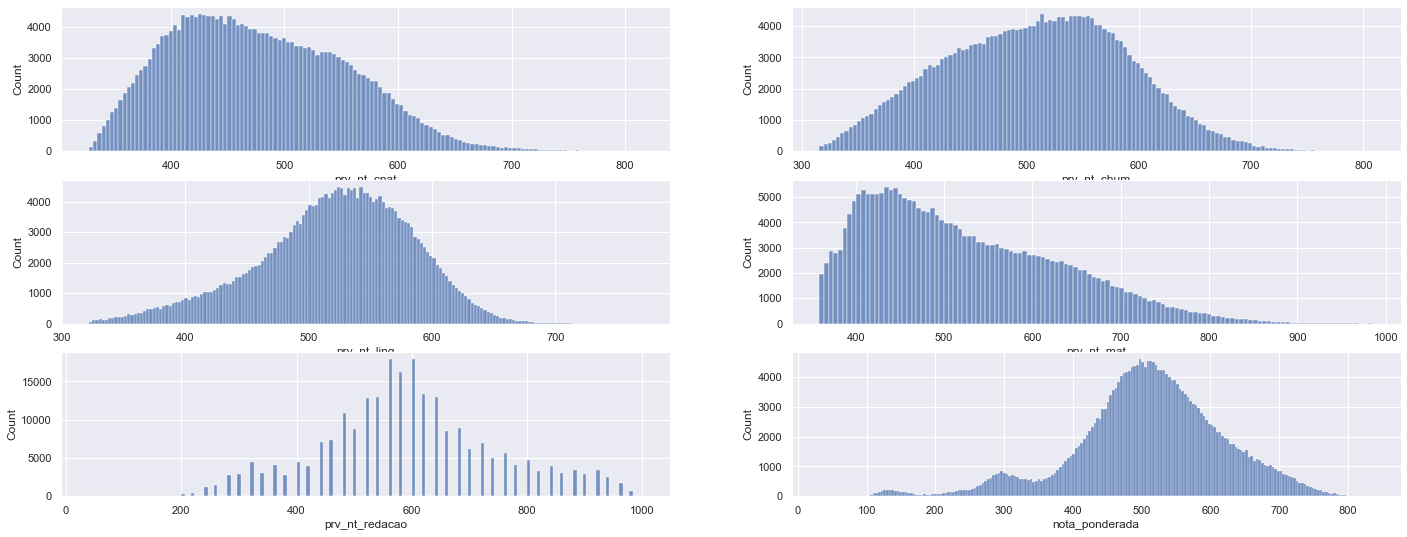

In [32]:
fig, axes = plt.subplots(3, 2)
aux = df4[df4['prv_nt_cnat']>0]
sns.histplot(ax=axes[0][0], data=aux, x='prv_nt_cnat');
aux = df4[df4['prv_nt_chum']>0]
sns.histplot(ax=axes[0][1], data=aux, x='prv_nt_chum');
aux = df4[df4['prv_nt_ling']>0]
sns.histplot(ax=axes[1][0], data=aux, x='prv_nt_ling');
aux = df4[df4['prv_nt_mat']>0]
sns.histplot(ax=axes[1][1], data=aux, x='prv_nt_mat');
aux = df4[df4['prv_nt_redacao']>0]
sns.histplot(ax=axes[2][0], data=aux, x='prv_nt_redacao');
aux = df4[df4['nota_ponderada']>0]
sns.histplot(ax=axes[2][1], data=aux, x='nota_ponderada');

### 4.1.2. NUMERICAL VARIABLE

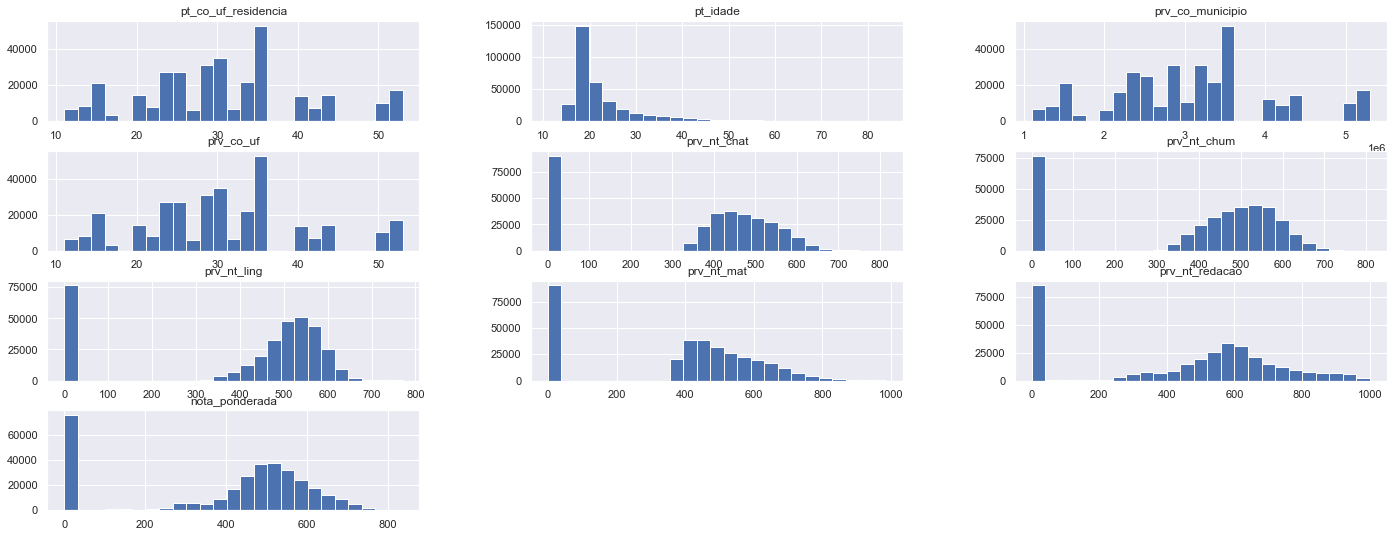

In [33]:
num_attributes.iloc[:, 1:].hist(bins=25);

### 4.1.3. CATEGORICAL VARIABLE

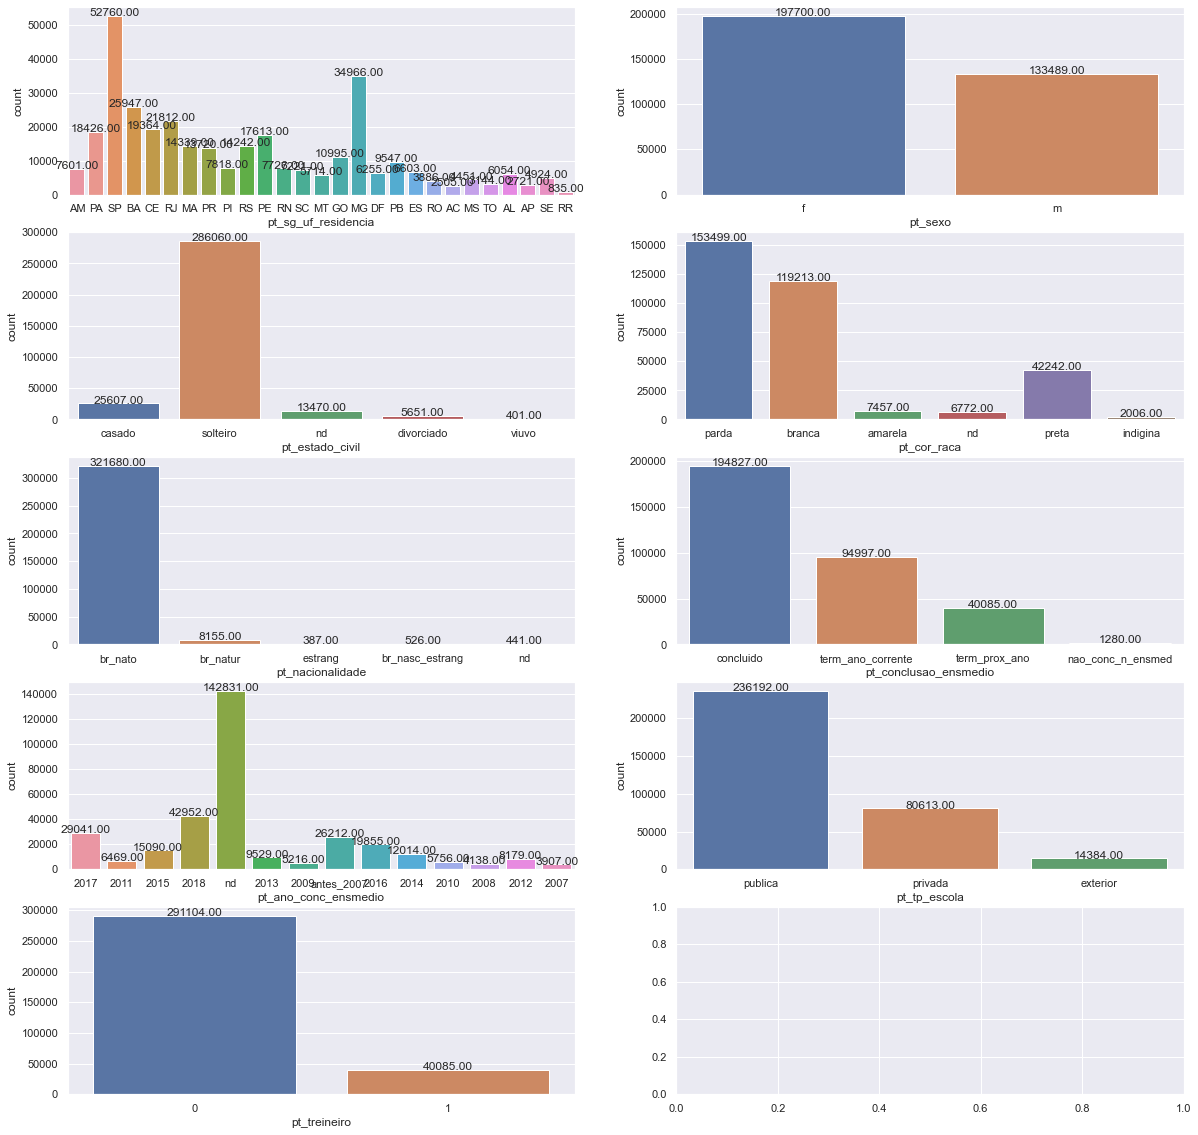

In [34]:
# DADOS GERAIS DO PARTICIPANTE
fig, axes = plt.subplots(5, 2, figsize=(20,20))
sns.countplot(ax=axes[0][0], x='pt_sg_uf_residencia', data=cat_attributes)
sns.countplot(ax=axes[0][1], x='pt_sexo', data=cat_attributes)
sns.countplot(ax=axes[1][0], x='pt_estado_civil', data=cat_attributes)
sns.countplot(ax=axes[1][1], x='pt_cor_raca', data=cat_attributes)
sns.countplot(ax=axes[2][0], x='pt_nacionalidade', data=cat_attributes)
sns.countplot(ax=axes[2][1], x='pt_conclusao_ensmedio', data=cat_attributes)
sns.countplot(ax=axes[3][0], x='pt_ano_conc_ensmedio', data=cat_attributes)
sns.countplot(ax=axes[3][1], x='pt_tp_escola', data=cat_attributes)
sns.countplot(ax=axes[4][0], x='pt_treineiro', data=cat_attributes)
show_values_on_bars(axes);

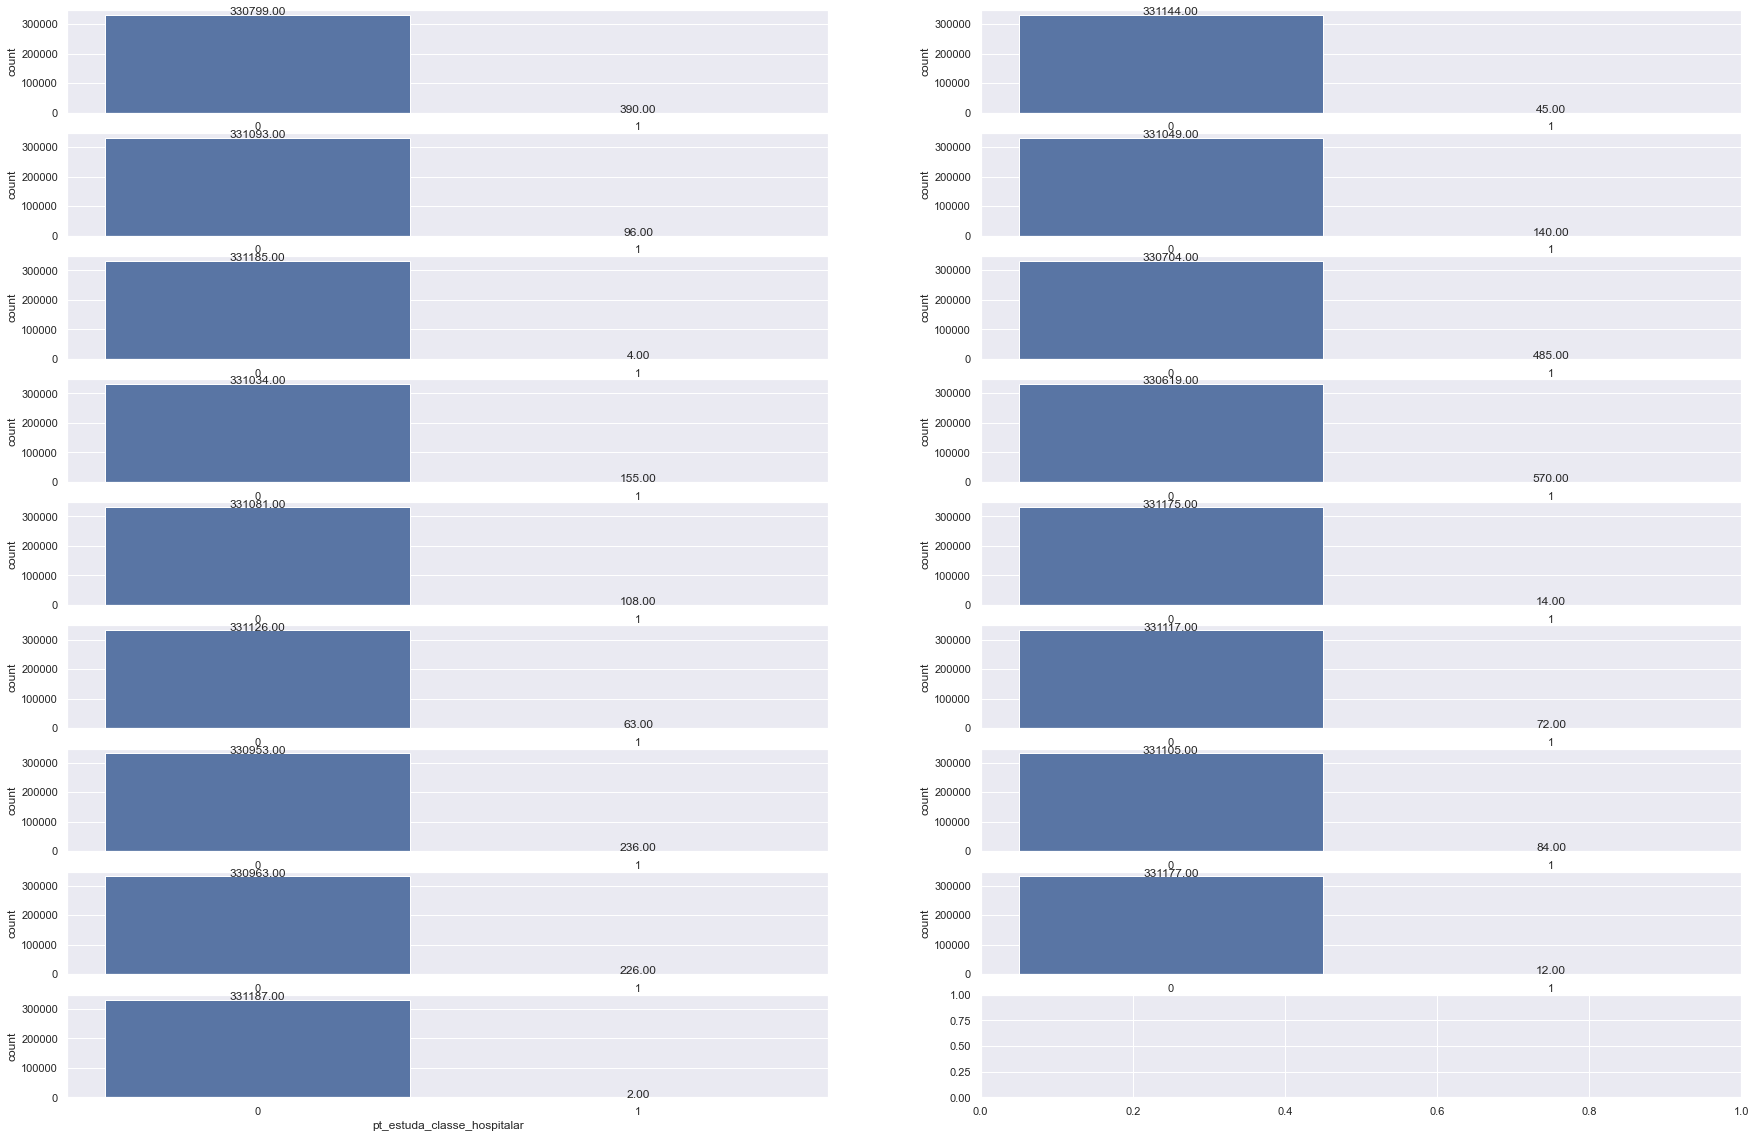

In [35]:
# DADOS ESPECIFICOS DO PARTICIPANTE
fig, axes = plt.subplots(9, 2, figsize=(30,20))
sns.countplot(ax=axes[0][0], x='pt_baixa_visao', data=cat_attributes)
sns.countplot(ax=axes[0][1], x='pt_cegueira', data=cat_attributes)
sns.countplot(ax=axes[1][0], x='pt_surdez', data=cat_attributes)
sns.countplot(ax=axes[1][1], x='pt_deficiencia_auditiva', data=cat_attributes)
sns.countplot(ax=axes[2][0], x='pt_surdo_cegueira', data=cat_attributes)
sns.countplot(ax=axes[2][1], x='pt_deficiencia_fisica', data=cat_attributes)
sns.countplot(ax=axes[3][0], x='pt_deficiencia_mental', data=cat_attributes)
sns.countplot(ax=axes[3][1], x='pt_deficit_atencao', data=cat_attributes)
sns.countplot(ax=axes[4][0], x='pt_dislexia', data=cat_attributes)
sns.countplot(ax=axes[4][1], x='pt_discalculia', data=cat_attributes)
sns.countplot(ax=axes[5][0], x='pt_autismo', data=cat_attributes)
sns.countplot(ax=axes[5][1], x='pt_visao_monocular', data=cat_attributes)
sns.countplot(ax=axes[6][0], x='pt_outra_def', data=cat_attributes)
sns.countplot(ax=axes[6][1], x='pt_gestante', data=cat_attributes)
sns.countplot(ax=axes[7][0], x='pt_lactante', data=cat_attributes)
sns.countplot(ax=axes[7][1], x='pt_idoso', data=cat_attributes)
sns.countplot(ax=axes[8][0], x='pt_estuda_classe_hospitalar', data=cat_attributes)
show_values_on_bars(axes);

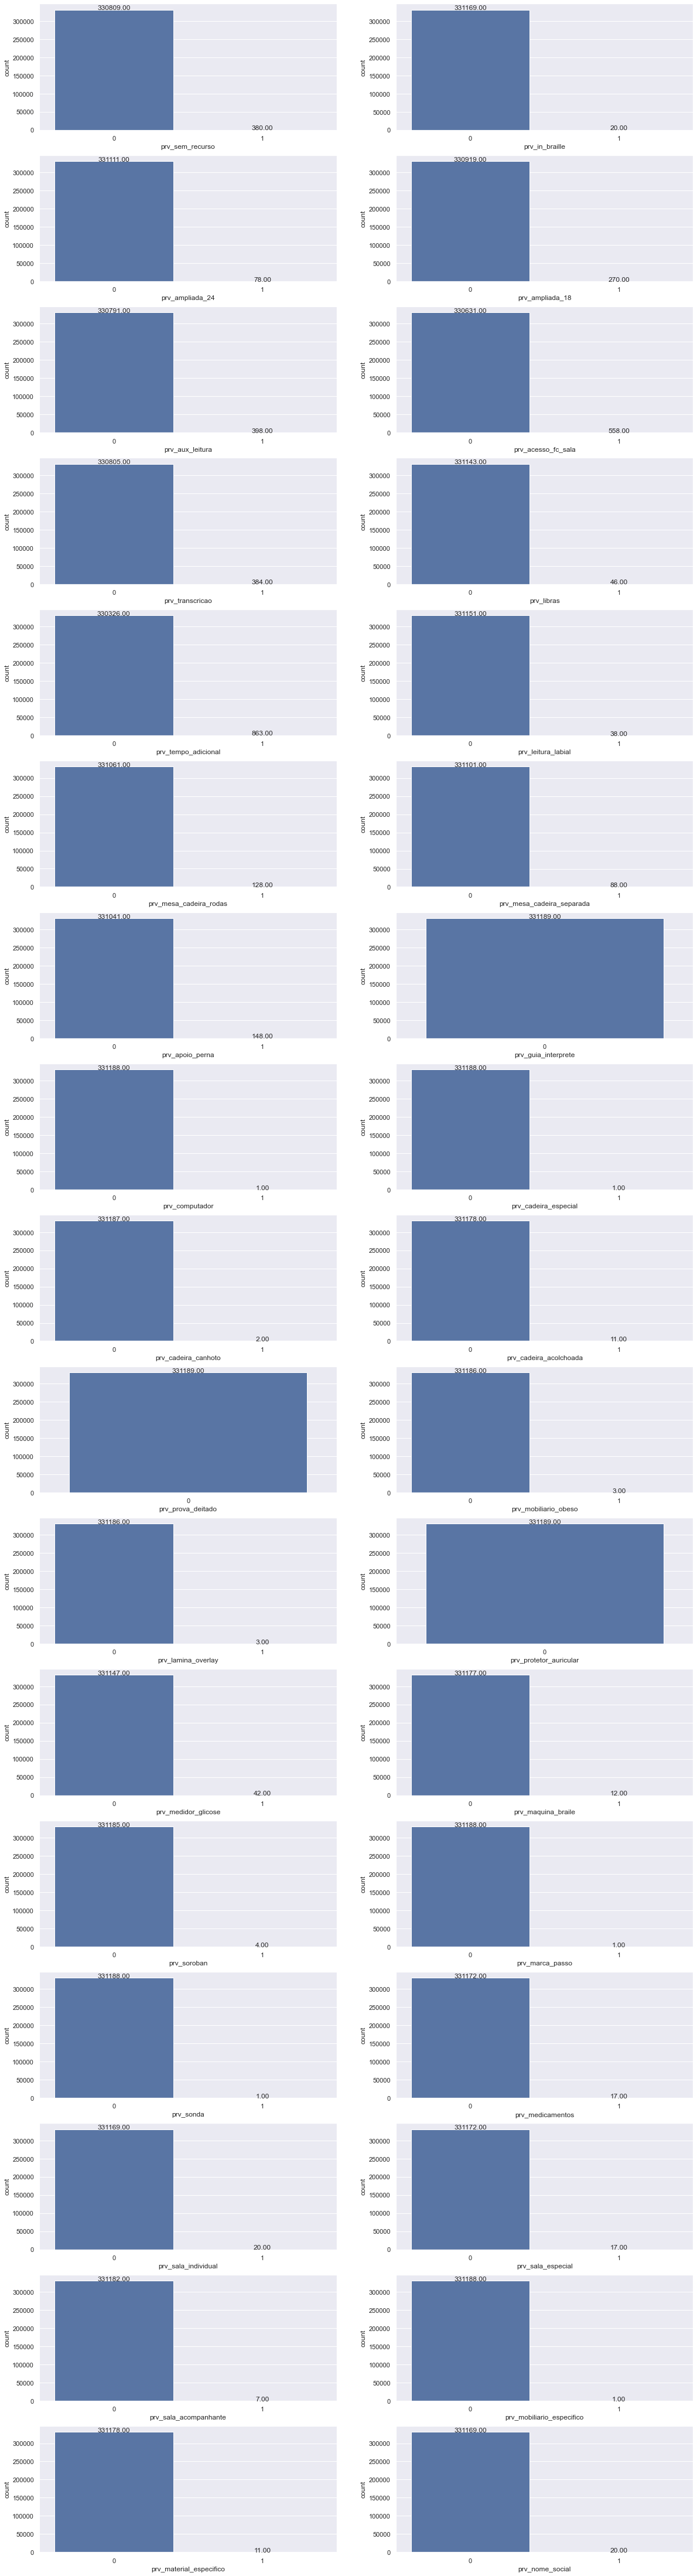

In [36]:
# DADOS ESPECIFICOS DO PARTICIPANTE
fig, axes = plt.subplots(17, 2, figsize=(20,80))
sns.countplot(ax=axes[0][0], x='prv_sem_recurso', data=cat_attributes)
sns.countplot(ax=axes[0][1], x='prv_in_braille', data=cat_attributes)
sns.countplot(ax=axes[1][0], x='prv_ampliada_24', data=cat_attributes)
sns.countplot(ax=axes[1][1], x='prv_ampliada_18', data=cat_attributes)
sns.countplot(ax=axes[2][0], x='prv_aux_leitura', data=cat_attributes)
sns.countplot(ax=axes[2][1], x='prv_acesso_fc_sala', data=cat_attributes)
sns.countplot(ax=axes[3][0], x='prv_transcricao', data=cat_attributes)
sns.countplot(ax=axes[3][1], x='prv_libras', data=cat_attributes)
sns.countplot(ax=axes[4][0], x='prv_tempo_adicional', data=cat_attributes)
sns.countplot(ax=axes[4][1], x='prv_leitura_labial', data=cat_attributes)
sns.countplot(ax=axes[5][0], x='prv_mesa_cadeira_rodas', data=cat_attributes)
sns.countplot(ax=axes[5][1], x='prv_mesa_cadeira_separada', data=cat_attributes)
sns.countplot(ax=axes[6][0], x='prv_apoio_perna', data=cat_attributes)
sns.countplot(ax=axes[6][1], x='prv_guia_interprete', data=cat_attributes)
sns.countplot(ax=axes[7][0], x='prv_computador', data=cat_attributes)
sns.countplot(ax=axes[7][1], x='prv_cadeira_especial', data=cat_attributes)
sns.countplot(ax=axes[8][0], x='prv_cadeira_canhoto', data=cat_attributes)
sns.countplot(ax=axes[8][1], x='prv_cadeira_acolchoada', data=cat_attributes)
sns.countplot(ax=axes[9][0], x='prv_prova_deitado', data=cat_attributes)
sns.countplot(ax=axes[9][1], x='prv_mobiliario_obeso', data=cat_attributes)
sns.countplot(ax=axes[10][0], x='prv_lamina_overlay', data=cat_attributes)
sns.countplot(ax=axes[10][1], x='prv_protetor_auricular', data=cat_attributes)
sns.countplot(ax=axes[11][0], x='prv_medidor_glicose', data=cat_attributes)
sns.countplot(ax=axes[11][1], x='prv_maquina_braile', data=cat_attributes)
sns.countplot(ax=axes[12][0], x='prv_soroban', data=cat_attributes)
sns.countplot(ax=axes[12][1], x='prv_marca_passo', data=cat_attributes)
sns.countplot(ax=axes[13][0], x='prv_sonda', data=cat_attributes)
sns.countplot(ax=axes[13][1], x='prv_medicamentos', data=cat_attributes)
sns.countplot(ax=axes[14][0], x='prv_sala_individual', data=cat_attributes)
sns.countplot(ax=axes[14][1], x='prv_sala_especial', data=cat_attributes)
sns.countplot(ax=axes[15][0], x='prv_sala_acompanhante', data=cat_attributes)
sns.countplot(ax=axes[15][1], x='prv_mobiliario_especifico', data=cat_attributes)
sns.countplot(ax=axes[16][0], x='prv_material_especifico', data=cat_attributes)
sns.countplot(ax=axes[16][1], x='prv_nome_social', data=cat_attributes)
show_values_on_bars(axes);

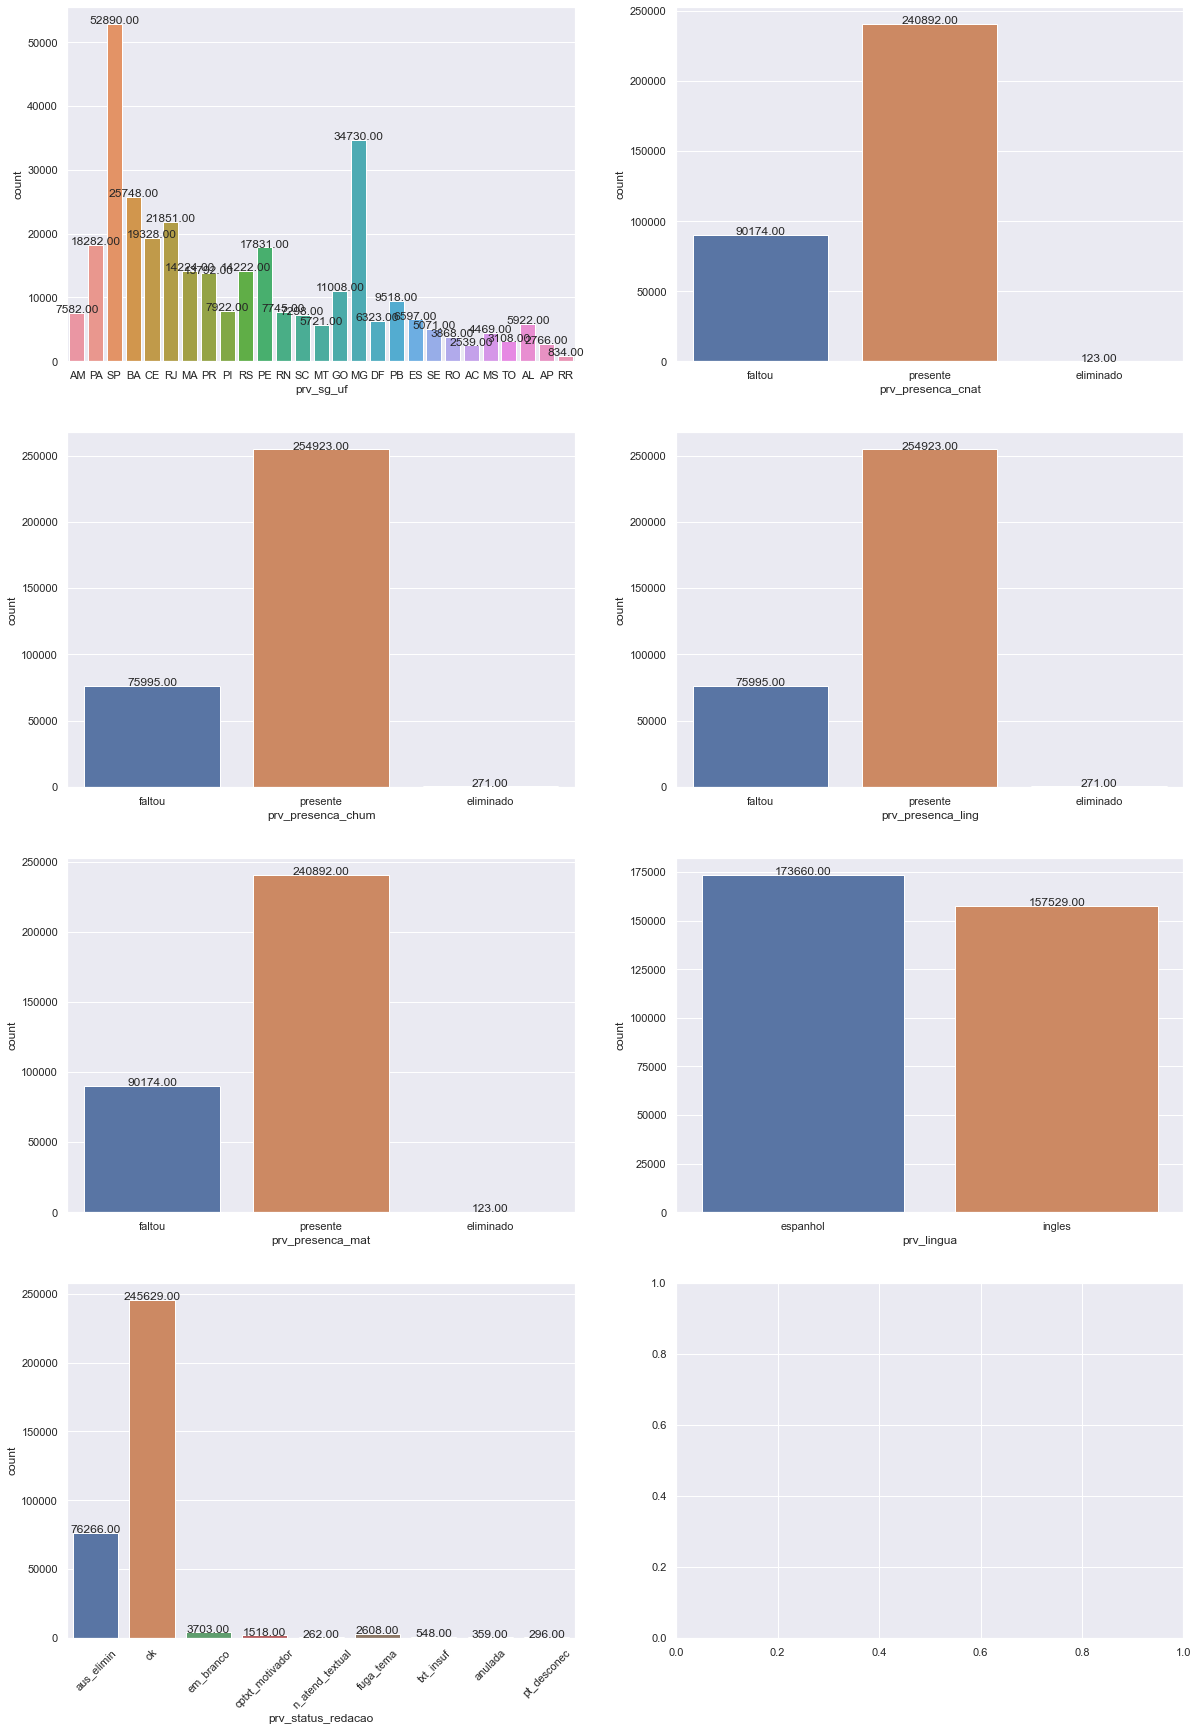

In [37]:
# DADOS DA PROVA
fig, axes = plt.subplots(4, 2, figsize=(20,30))
sns.countplot(ax=axes[0][0], x='prv_sg_uf', data=cat_attributes)
sns.countplot(ax=axes[0][1], x='prv_presenca_cnat', data=cat_attributes)
sns.countplot(ax=axes[1][0], x='prv_presenca_chum', data=cat_attributes)
sns.countplot(ax=axes[1][1], x='prv_presenca_ling', data=cat_attributes)
sns.countplot(ax=axes[2][0], x='prv_presenca_mat', data=cat_attributes)
sns.countplot(ax=axes[2][1], x='prv_lingua', data=cat_attributes)
sns.countplot(ax=axes[3][0], x='prv_status_redacao', data=cat_attributes).tick_params(axis='x', labelrotation=45)
show_values_on_bars(axes);

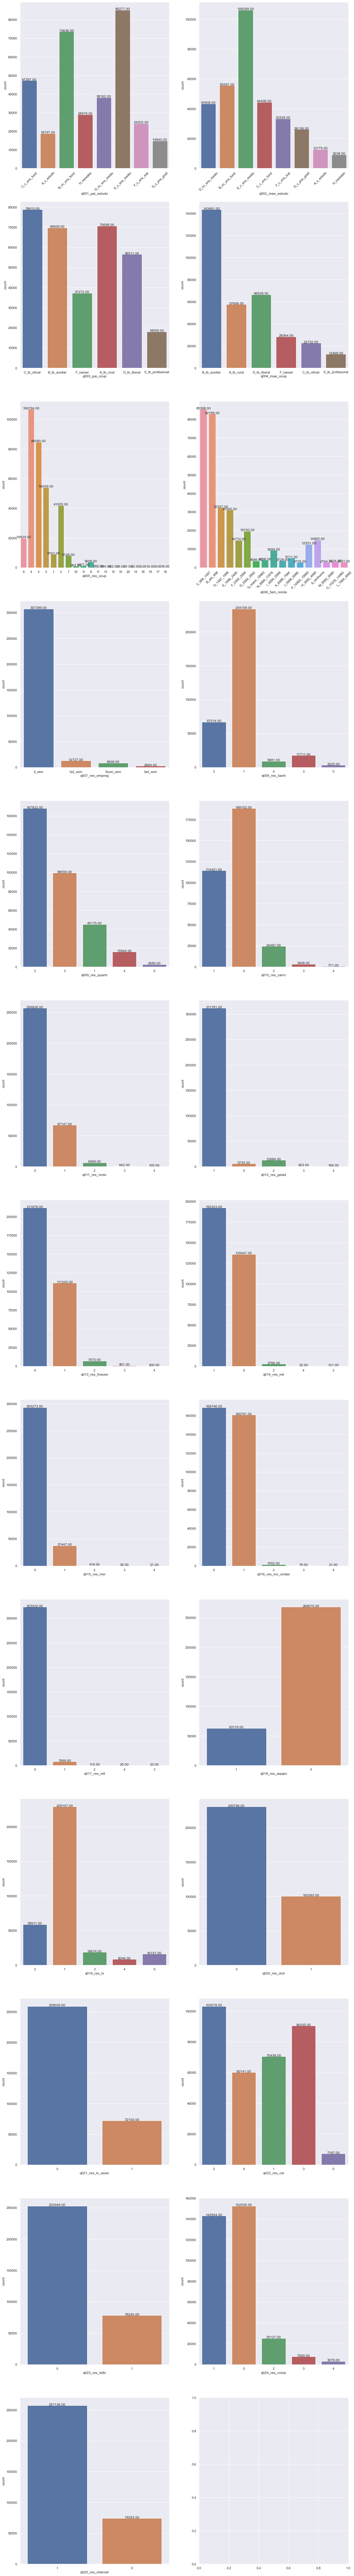

In [38]:
# DADOS QUESTIONARIO SOCIOECONOMICO
fig, axes = plt.subplots(13, 2, figsize=(20,160))
sns.countplot(ax=axes[0][0], x='q001_pai_estudo', data=cat_attributes).tick_params(axis='x', labelrotation=45)
sns.countplot(ax=axes[0][1], x='q002_mae_estudo', data=cat_attributes).tick_params(axis='x', labelrotation=45)
sns.countplot(ax=axes[1][0], x='q003_pai_ocup', data=cat_attributes)
sns.countplot(ax=axes[1][1], x='q004_mae_ocup', data=cat_attributes)
sns.countplot(ax=axes[2][0], x='q005_res_ocup', data=cat_attributes)
sns.countplot(ax=axes[2][1], x='q006_fam_renda', data=cat_attributes).tick_params(axis='x', labelrotation=45)
sns.countplot(ax=axes[3][0], x='q007_res_empreg', data=cat_attributes)
sns.countplot(ax=axes[3][1], x='q008_res_banh', data=cat_attributes)
sns.countplot(ax=axes[4][0], x='q009_res_quarto', data=cat_attributes)
sns.countplot(ax=axes[4][1], x='q010_res_carro', data=cat_attributes)
sns.countplot(ax=axes[5][0], x='q011_res_moto', data=cat_attributes)
sns.countplot(ax=axes[5][1], x='q012_res_gelad', data=cat_attributes)
sns.countplot(ax=axes[6][0], x='q013_res_freezer', data=cat_attributes)
sns.countplot(ax=axes[6][1], x='q014_res_mlr', data=cat_attributes)
sns.countplot(ax=axes[7][0], x='q015_res_msr', data=cat_attributes)
sns.countplot(ax=axes[7][1], x='q016_res_mc_ondas', data=cat_attributes)
sns.countplot(ax=axes[8][0], x='q017_res_mll', data=cat_attributes)
sns.countplot(ax=axes[8][1], x='q018_res_aspipo', data=cat_attributes)
sns.countplot(ax=axes[9][0], x='q019_res_tv', data=cat_attributes)
sns.countplot(ax=axes[9][1], x='q020_res_dvd', data=cat_attributes)
sns.countplot(ax=axes[10][0], x='q021_res_tv_assin', data=cat_attributes)
sns.countplot(ax=axes[10][1], x='q022_res_cel', data=cat_attributes)
sns.countplot(ax=axes[11][0], x='q023_res_telfx', data=cat_attributes)
sns.countplot(ax=axes[11][1], x='q024_res_comp', data=cat_attributes)
sns.countplot(ax=axes[12][0], x='q025_res_internet', data=cat_attributes)
show_values_on_bars(axes);

In [39]:
cat_attributes.head().T

0                                     1                                     2                                     3                                     4
pt_nu_inscricao              a42faea7-8171-43c3-b868-35068e82f30d  d7b568f5-319c-4d49-b5af-385e5eadc703  8b04ed6a-c479-4bf3-8d88-9927c995f518  1ebc29c1-570e-40f4-a580-1d509e24bc91  1aec7054-9817-42d5-9268-063a4b80af3a
pt_no_municipio_residencia                                 manaus                            ananindeua                             são paulo                      feira de santana                            jaguaruana
pt_sg_uf_residencia                                            AM                                    PA                                    SP                                    BA                                    CE
pt_sexo                                                         f                                     m                                     f                                     f                                     m
pt_estado_civil                                            casado                              solteiro                                    nd                              solteiro                              solteiro
pt_cor_raca                                                 parda                                 parda                                branca                                 parda                                 parda
pt_nacionalidade                                          br_nato                               br_nato                               br_nato                               br_nato                               br_nato
pt_conclusao_ensmedio                                   concluido                             concluido                             concluido                             concluido                             concluido
pt_ano_conc_ensmedio                                         2017                                  2017                                  2011                                  2015                                  2018
pt_tp_escola                                              publica                               publica                               publica                               publica                               publica
pt_treineiro                                                    0                                     0                                     0                                     0                                     0
pt_baixa_visao                                                  0                                     0                                     0                                     0                                     0
pt_cegueira                                                     0                                     0                                     0                                     0                                     0
pt_surdez                                                       0                                     0                                     0                                     0                                     0
pt_deficiencia_auditiva                                         0                                     0                                     0                                     0                                     0
pt_surdo_cegueira                                               0                                     0                                     0                                     0                                     0
pt_deficiencia_fisica                                           0                                     0                                     0                                     0                                     0
pt_deficiencia_mental                                           0                                     0                                     

## 4.2. ANÁLISE BIVARIADA

### 4.2.1 ESTADOS VS NOTAS
- Quantidade de participantes com melhor nota - PB melhor nota média / MA pior nota média

In [40]:
aux = df4[['pt_sg_uf_residencia', 'prv_nt_cnat', 'prv_nt_chum', 'prv_nt_ling', 'prv_nt_mat', 'prv_nt_redacao', 'nota_ponderada']].copy()
aux.groupby('pt_sg_uf_residencia').mean().sort_values('nota_ponderada', ascending=False)

prv_nt_cnat  prv_nt_chum  prv_nt_ling  prv_nt_mat  prv_nt_redacao  nota_ponderada
pt_sg_uf_residencia                                                                                   
PB                        360.18       397.01       409.39      392.28          460.40          406.98
MG                        357.91       399.57       407.20      397.75          458.33          406.04
SE                        356.68       392.49       403.76      385.85          465.35          405.19
RJ                        355.88       400.27       409.64      389.97          457.06          404.84
PI                        359.10       393.10       405.17      390.06          457.93          404.46
SC                        355.54       405.67       413.08      396.95          447.05          403.65
SP                        354.53       402.11       411.69      393.91          447.65          402.59
RN                        356.94       392.84       405.27      388.52          453.76          402.40
RS                        350.26       403.55       412.05      387.95          446.21          400.50
CE                        352.75       392.74       403.72      389.95          445.87          398.60
GO                        350.02       392.41       403.47      382.74          446.84          397.27
DF                        351.13       397.18       405.92      382.34          440.98          396.77
PE                        351.03       390.17       402.46      386.19          439.36          395.24
PR                        351.03       399.63       406.52      388.13          432.55          395.16
ES                        348.51       390.67       397.42      386.90          443.41          394.82
AL                        348.95       384.87       398.69      378.46          443.52          393.81
PA                        337.70       379.11       389.01      358.42          433.69          382.97
BA                        336.87       376.80       388.39      363.38          424.93          380.23
MA                        337.50       375.53       389.10      362.22          420.44          378.98
TO                        330.34       368.46       383.78      355.48          422.95          375.14
MS                        330.11       374.42       386.70      357.57          410.84          372.82
AC                        323.89       373.91       389.45      346.55          416.84          372.16
MT                        325.85       369.65       380.22      352.35          401.59          366.48
RO                        324.07       368.76       380.75      350.48          397.84          364.65
AP                        313.42       365.65       376.23      329.04          402.05          359.36
RR                        317.46       364.45       375.31      338.37          379.86          354.54
AM                        286.11       330.72       343.00      306.58          350.66          323.36

### 4.2.2 IDADE VS NOTAS
- A faixa com idade escolar tendencialmente tem a melhor médida de notas. Porém, pessoas mais velhas perfomam bem

In [41]:
aux = df4[['pt_idade', 'prv_nt_cnat', 'prv_nt_chum', 'prv_nt_ling', 'prv_nt_mat', 'prv_nt_redacao', 'nota_ponderada']].copy()
nota = aux.groupby('pt_idade').mean().reset_index()
nota['participantes'] = aux[['pt_idade', 'nota_ponderada']].groupby('pt_idade').count()['nota_ponderada'].tolist()
nota.sort_values('nota_ponderada', ascending=False)

pt_idade  prv_nt_cnat  prv_nt_chum  prv_nt_ling  prv_nt_mat  prv_nt_redacao  nota_ponderada  participantes
5      16.00       435.76       484.46       496.70      487.64          554.04          493.49          20647
71     84.00       591.70       546.30       559.10      503.50          320.00          490.31              1
6      17.00       425.53       471.97       483.89      474.86          548.46          483.66          55040
4      15.00       416.82       470.20       484.87      469.28          529.31          474.76           5122
67     78.00       436.05       549.05       460.75      458.90          470.00          464.76              2
7      18.00       392.74       436.26       448.27      434.27          509.46          447.37          56082
3      14.00       377.46       444.16       460.43      431.45          484.72          438.30            373
2      13.00       361.77       420.18       447.86      367.19          452.63          412.63             19
0      11.00       426.90       405.30       385.80      393.50          400.00          405.11              1
8      19.00       355.36       395.68       407.71      389.63          459.46          404.52          37475
9      20.00       331.37       372.27       384.25      362.14          425.15          377.25          26490
53     64.00       377.64       413.65       400.54      379.80          311.37          366.16             51
57     68.00       384.79       398.98       379.70      389.17          318.62          365.78             29
10     21.00       314.42       353.38       364.49      343.16          400.35          356.98          18787
68     79.00       330.57       430.02       363.65      349.18          345.00          353.32              4
64     75.00       402.15       483.75       414.75      451.00          180.00          351.07              2
55     66.00       350.20       391.53       377.18      354.15          316.00          349.86             30
11     22.00       300.78       340.78       351.91      326.31          378.81          340.97          15081
12     23.00       289.21       330.83       340.69      313.40          363.40          328.34          12240
44     55.00       305.00       357.74       353.01      308.90          328.57          327.34            301
46     57.00       311.02       363.27       355.64      314.06          316.97          327.26            251
66     77.00       398.15       427.65       361.90      374.20          170.00          323.01              2
13     24.00       282.29       321.77       331.55      304.02          351.41          319.00          10239
36     47.00       288.94       335.94       338.66      297.39          318.93          313.43            787
61     72.00       295.94       331.96       316.83      312.21          315.56          311.23              9
63     74.00       328.16       406.88       361.98      364.92          208.00          310.42              5
35     46.00       288.47       330.59       331.28      294.56          311.68          308.81            817
37     48.00       281.59       332.30       331.01      286.02          313.00          306.41            774
38     49.00       283.74       324.94       327.90      292.55          308.88          305.12            617
41     52.00       280.27       329.71       329.74      289.29          309.77          304.86            444
42     53.00       284.33       329.90       324.84      292.54          305.73          304.23            398
14     25.00       268.70       308.62       318.85      290.38          330.69          303.49           8332
15     26.00       267.59       310.42       319.35      287.48          328.17          302.39           6995
49     60.00       283.80       334.77       324.56      289.90          283.83          297.67            120
16     27.00       264.82       304.55       312.28      283.34          321.91          297.26           5969
48     5

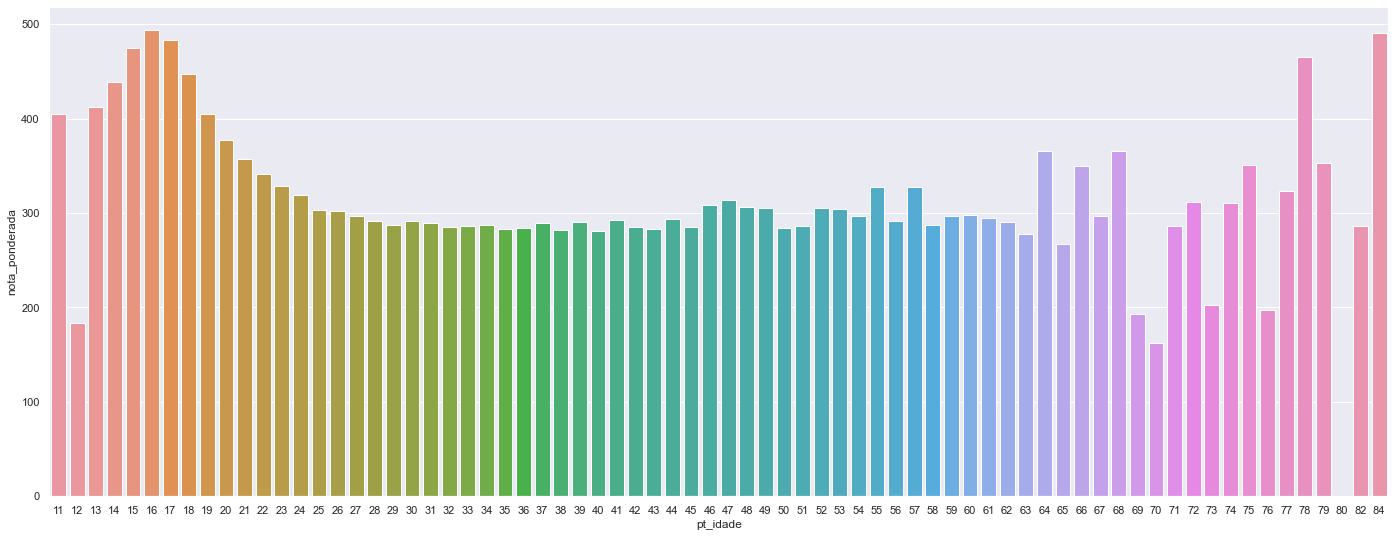

In [42]:
nota['pt_idade'] = nota['pt_idade'].astype('int')
sns.barplot(data=nota, x='pt_idade', y='nota_ponderada');

### 4.2.2 SEXO VS NOTAS
- Homens participam menos nas provas, porém tem um desempenho quase igual ao das meninas.

In [43]:
aux = df4[['pt_sexo', 'prv_nt_cnat', 'prv_nt_chum', 'prv_nt_ling', 'prv_nt_mat', 'prv_nt_redacao', 'nota_ponderada']].copy()
nota = aux.groupby('pt_sexo').mean().reset_index()
nota['participantes'] = aux[['pt_sexo', 'nota_ponderada']].groupby('pt_sexo').count()['nota_ponderada'].tolist()
nota.sort_values('nota_ponderada', ascending=False)

pt_sexo  prv_nt_cnat  prv_nt_chum  prv_nt_ling  prv_nt_mat  prv_nt_redacao  nota_ponderada  participantes
1       m       355.89       395.62       400.74      398.71          432.00          395.95         133489
0       f       342.00       387.20       400.95      368.60          445.42          392.00         197700

### 4.2.3 ESTADO CIVIL VS NOTAS - <font color='red'>Variável não confiável</font>
- Solteiros performam melhor, sendo que casados tem pior desempenho.
- Existe um viés nos dados, onde a classificação não está feita corretamente. Há pessoas bem novas classificadas como viúvas. Essa feature não é confiável.

In [44]:
aux = df4[['pt_estado_civil', 'prv_nt_cnat', 'prv_nt_chum', 'prv_nt_ling', 'prv_nt_mat', 'prv_nt_redacao', 'nota_ponderada']].copy()
nota = aux.groupby('pt_estado_civil').mean().reset_index()
nota['participantes'] = aux[['pt_estado_civil', 'nota_ponderada']].groupby('pt_estado_civil').count()['nota_ponderada'].tolist()
nota.sort_values('nota_ponderada', ascending=False)

pt_estado_civil  prv_nt_cnat  prv_nt_chum  prv_nt_ling  prv_nt_mat  prv_nt_redacao  nota_ponderada  participantes
3        solteiro       359.29       402.39       413.22      394.93          457.93          407.54         286060
2              nd       300.48       344.24       352.58      322.76          367.40          337.58          13470
1      divorciado       271.85       315.67       321.89      286.74          320.44          302.31           5651
4           viuvo       276.75       323.12       328.58      286.04          295.11          298.19            401
0          casado       259.64       300.79       306.81      274.87          306.69          288.83          25607

In [45]:
df4[(df4['pt_estado_civil'] == 'viuvo') & (df4['pt_idade'] < 40)]

pt_nu_inscricao  pt_co_municipio_residencia pt_no_municipio_residencia  pt_co_uf_residencia pt_sg_uf_residencia  pt_idade pt_sexo pt_estado_civil pt_cor_raca pt_nacionalidade pt_conclusao_ensmedio pt_ano_conc_ensmedio pt_tp_escola pt_treineiro pt_baixa_visao pt_cegueira pt_surdez pt_deficiencia_auditiva pt_surdo_cegueira pt_deficiencia_fisica pt_deficiencia_mental pt_deficit_atencao pt_dislexia pt_discalculia pt_autismo pt_visao_monocular pt_outra_def pt_gestante pt_lactante pt_idoso pt_estuda_classe_hospitalar prv_sem_recurso prv_in_braille prv_ampliada_24 prv_ampliada_18 prv_aux_leitura prv_acesso_fc_sala prv_transcricao prv_libras prv_tempo_adicional prv_leitura_labial prv_mesa_cadeira_rodas prv_mesa_cadeira_separada prv_apoio_perna prv_guia_interprete prv_computador prv_cadeira_especial prv_cadeira_canhoto prv_cadeira_acolchoada prv_prova_deitado prv_mobiliario_obeso prv_lamina_overlay prv_protetor_auricular prv_medidor_glicose prv_maquina_braile prv_soroban prv_marca_passo prv_sonda prv_medicamentos prv_sala_individual prv_sala_especial prv_sala_acompanhante prv_mobiliario_especifico prv_material_especifico prv_nome_social  prv_co_municipio       prv_no_municipio  prv_co_uf prv_sg_uf prv_presenca_cnat prv_presenca_chum prv_presenca_ling prv_presenca_mat prv_lingua prv_status_redacao q001_pai_estudo q002_mae_estudo      q003_pai_ocup      q004_mae_ocup q005_res_ocup q006_fam_renda q007_res_empreg q008_res_banh q009_res_quarto q010_res_carro q011_res_moto q012_res_gelad q013_res_freezer q014_res_mlr q015_res_msr q016_res_mc_ondas q017_res_mll q018_res_aspipo q019_res_tv q020_res_dvd q021_res_tv_assin q022_res_cel q023_res_telfx q024_res_comp q025_res_internet  prv_nt_cnat  prv_nt_chum  prv_nt_ling  prv_nt_mat  prv_nt_redacao  nota_ponderada
2063    85e845cf-14b4-4315-aeed-510ceef5c48a                     3543402             ribeirão preto                   35                  SP     37.00       f           viuvo      branca         br_natur             concluido           antes_2007      publica            0              0           0         0                       0                 0                     0                     0                  0           0              0          0                  0            0           0           0        0                           0               0              0               0               0               0                  0               0          0                   0                  0                      0                         0               0                   0              0                    0                   0                      0                 0                    0                  0                      0                   0                  0           0               0         0                0                   0                 0                     0                         0                       0               0           3543402         Ribeirão Preto         35        SP          presente          presente          presente         presente   espanhol                 ok       H_naosabe   E_c_ens_medio           F_naosei      B_tb_auxiliar             5      A_nenhuma           0_sem             1               2              0             0              1                0            0            0                 0            0               0           2            1                 0            3              0             0                 1       493.90       559.60       568.70      464.30          520.00          520.30
3776    220568eb-f426-4e2c-bbe5-24cdaef6f0c4                     2400208                        açu                   24                  RN     37.00       f           viuvo       parda          br_nato     term_ano_corrente                   nd      privada            0              0           0         0                       0                 0                     0                     0                  0         

### 4.2.4 COR/RAÇA VS NOTAS - <font color='orange'>Variável possui viés, tendo em vista que quem declara é o participante</font>
- Declarantes de branco possuem a melhor nota.
- Declarantes de indígenas perfomam pior.
- Interessante observar que as notas de pardos e negros são parecidos.

In [46]:
aux = df4[['pt_cor_raca', 'prv_nt_cnat', 'prv_nt_chum', 'prv_nt_ling', 'prv_nt_mat', 'prv_nt_redacao', 'nota_ponderada']].copy()
nota = aux.groupby('pt_cor_raca').mean().reset_index()
nota['participantes'] = aux[['pt_cor_raca', 'nota_ponderada']].groupby('pt_cor_raca').count()['nota_ponderada'].tolist()
nota.sort_values('nota_ponderada', ascending=False)

pt_cor_raca  prv_nt_cnat  prv_nt_chum  prv_nt_ling  prv_nt_mat  prv_nt_redacao  nota_ponderada  participantes
1      branca       374.50       418.66       425.94      417.41          479.99          425.14         119213
0     amarela       350.33       388.74       401.27      384.22          441.76          395.18           7457
3          nd       346.63       391.93       398.90      379.50          432.86          390.77           6772
4       parda       334.08       376.05       388.08      362.61          419.95          377.69         153499
5       preta       322.84       366.79       379.02      345.58          404.86          365.35          42242
2    indigina       298.10       339.73       353.96      319.71          356.40          333.09           2006

### 4.2.5 NACIONALIDADE VS NOTAS
- Aparentemente quem nasce no estrangeiro performa melhor nas provas. Entretanto, a amostra é menor comparado aos brasileiros nascido aqui de fato.

In [47]:
aux = df4[['pt_nacionalidade', 'prv_nt_cnat', 'prv_nt_chum', 'prv_nt_ling', 'prv_nt_mat', 'prv_nt_redacao', 'nota_ponderada']].copy()
nota = aux.groupby('pt_nacionalidade').mean().reset_index()
nota['participantes'] = aux[['pt_nacionalidade', 'nota_ponderada']].groupby('pt_nacionalidade').count()['nota_ponderada'].tolist()
nota.sort_values('nota_ponderada', ascending=False)

pt_nacionalidade  prv_nt_cnat  prv_nt_chum  prv_nt_ling  prv_nt_mat  prv_nt_redacao  nota_ponderada  participantes
0  br_nasc_estrang       400.69       443.00       452.15      452.33          517.38          455.38            526
1          br_nato       348.03       391.07       401.16      381.36          440.77          394.12         321680
4               nd       348.49       392.17       404.77      371.22          430.52          391.00            441
3          estrang       355.13       390.74       401.39      401.14          406.93          388.08            387
2         br_natur       326.68       368.34       385.50      351.11          407.17          369.20           8155

### 4.2.6 STATUS ENS MEDIO VS NOTAS
- Pessoal que presta a prova para "treinar" em média tem performance melhor.
- Quem está para concluir o ens. medio tem média melhor comparados aqueles que já concluiram.

In [48]:
aux = df4[['pt_conclusao_ensmedio', 'prv_nt_cnat', 'prv_nt_chum', 'prv_nt_ling', 'prv_nt_mat', 'prv_nt_redacao', 'nota_ponderada']].copy()
nota = aux.groupby('pt_conclusao_ensmedio').mean().reset_index()
nota['participantes'] = aux[['pt_conclusao_ensmedio', 'nota_ponderada']].groupby('pt_conclusao_ensmedio').count()['nota_ponderada'].tolist()
nota.sort_values('nota_ponderada', ascending=False)

pt_conclusao_ensmedio  prv_nt_cnat  prv_nt_chum  prv_nt_ling  prv_nt_mat  prv_nt_redacao  nota_ponderada  participantes
3         term_prox_ano       415.20       465.94       478.85      462.03          519.16          468.88          40085
2     term_ano_corrente       394.20       438.92       451.12      435.93          501.33          446.37          94997
0             concluido       311.67       352.12       360.90      337.86          394.77          353.11         194827
1     nao_conc_n_ensmed       240.71       300.38       311.39      264.30          296.58          279.93           1280

In [49]:
aux = df4[['pt_treineiro', 'prv_nt_cnat', 'prv_nt_chum', 'prv_nt_ling', 'prv_nt_mat', 'prv_nt_redacao', 'nota_ponderada']].copy()
nota = aux.groupby('pt_treineiro').mean().reset_index()
nota['participantes'] = aux[['pt_treineiro', 'nota_ponderada']].groupby('pt_treineiro').count()['nota_ponderada'].tolist()
nota.sort_values('nota_ponderada', ascending=False)

pt_treineiro  prv_nt_cnat  prv_nt_chum  prv_nt_ling  prv_nt_mat  prv_nt_redacao  nota_ponderada  participantes
1            1       415.20       465.94       478.85      462.03          519.16          468.88          40085
0            0       338.29       380.22       390.13      369.54          429.11          383.22         291104

### 4.2.7 ANO CONCLUSAO ENS MEDIO VS NOTAS
- Pessoas que não declaram o ano tem a melhor nota média.
- Aparentemente em média há uma gradual melhora na nota média. Duas hipóteses: pessoal está estudando mais, ou a prova já está ficando "manjada".

In [50]:
aux = df4[['pt_ano_conc_ensmedio', 'prv_nt_cnat', 'prv_nt_chum', 'prv_nt_ling', 'prv_nt_mat', 'prv_nt_redacao', 'nota_ponderada']].copy()
nota = aux.groupby('pt_ano_conc_ensmedio').mean().reset_index()
nota['participantes'] = aux[['pt_ano_conc_ensmedio', 'nota_ponderada']].groupby('pt_ano_conc_ensmedio').count()['nota_ponderada'].tolist()
nota.sort_values('nota_ponderada', ascending=False)

pt_ano_conc_ensmedio  prv_nt_cnat  prv_nt_chum  prv_nt_ling  prv_nt_mat  prv_nt_redacao  nota_ponderada  participantes
13                   nd       393.99       440.69       452.99      435.82          497.02          445.55         142831
11                 2018       353.48       393.61       405.20      387.57          463.94          404.39          42952
10                 2017       335.27       374.99       386.56      366.78          438.41          383.59          29041
9                  2016       327.43       365.94       376.88      358.47          423.29          373.03          19855
8                  2015       308.43       348.14       358.01      337.90          395.08          351.26          15090
7                  2014       300.33       340.23       350.13      325.77          380.77          340.96          12014
6                  2013       290.84       330.77       339.68      315.08          365.79          329.51           9529
5                  2012       280.60       321.11       329.36      303.52          348.69          317.12           8179
4                  2011       277.70       316.80       324.24      300.44          340.54          312.04           6469
3                  2010       271.94       313.32       319.50      291.96          333.34          306.01           5756
1                  2008       271.96       310.20       315.10      289.78          329.26          303.38           4138
12           antes_2007       274.60       317.49       318.51      287.91          320.02          302.63          26212
0                  2007       267.27       308.21       311.22      281.70          321.14          297.76           3907
2                  2009       262.62       301.58       307.37      280.64          320.54          294.64           5216

### 4.2.8 TIPO DE ESCOLA VS NOTAS
- Aperentemente esta feature concorda com a nota das pessoas que declaram que são estrangeiras. Escolas estrangeiras possuem melhor nota.
- Pior performance são as escolas públicas.

In [51]:
aux = df4[['pt_tp_escola', 'prv_nt_cnat', 'prv_nt_chum', 'prv_nt_ling', 'prv_nt_mat', 'prv_nt_redacao', 'nota_ponderada']].copy()
nota = aux.groupby('pt_tp_escola').mean().reset_index()
nota['participantes'] = aux[['pt_tp_escola', 'nota_ponderada']].groupby('pt_tp_escola').count()['nota_ponderada'].tolist()
nota.sort_values('nota_ponderada', ascending=False)

pt_tp_escola  prv_nt_cnat  prv_nt_chum  prv_nt_ling  prv_nt_mat  prv_nt_redacao  nota_ponderada  participantes
0     exterior       512.21       545.99       544.04      587.64          694.50          584.18          14384
1      privada       373.14       419.82       434.54      408.86          466.86          421.78          80613
2      publica       328.86       371.16       380.65      358.54          415.35          372.36         236192

### 4.2.9 ATENDIMENTO ESPECIALIZADO VS NOTAS
- No geral pessoas que indicam deficiência tem performance ruim comparado aqueles que não o declaram.
- Entretanto, deve-se destcar o otimo desempenho daqueles que declararam deficit de atencao, dislexia e discalculia. Aqueles que marcam "outras deficiências" também tem um relativo melhor desepenho.

In [52]:
atend_espec = df4.iloc[:, 14:31].columns.tolist()
nota_ = pd.DataFrame()
mapa = {'0': 'nao', '1': 'sim'}
for i in atend_espec:
    aux = df4[[i, 'prv_nt_cnat', 'prv_nt_chum', 'prv_nt_ling', 'prv_nt_mat', 'prv_nt_redacao', 'nota_ponderada']].copy()
    nota = aux.groupby(i).mean().reset_index()
    nota['participantes'] = aux[[i, 'nota_ponderada']].groupby(i).count()['nota_ponderada'].tolist()
    nota['atend_espec'] = nota.columns.tolist()[0]
    nota = nota.rename(columns={i:'status'})
    #nota['atend_espec'] = nota['atend_espec'] + "_" + nota['status'].map(mapa)
    nota_ = pd.concat([nota_, nota])

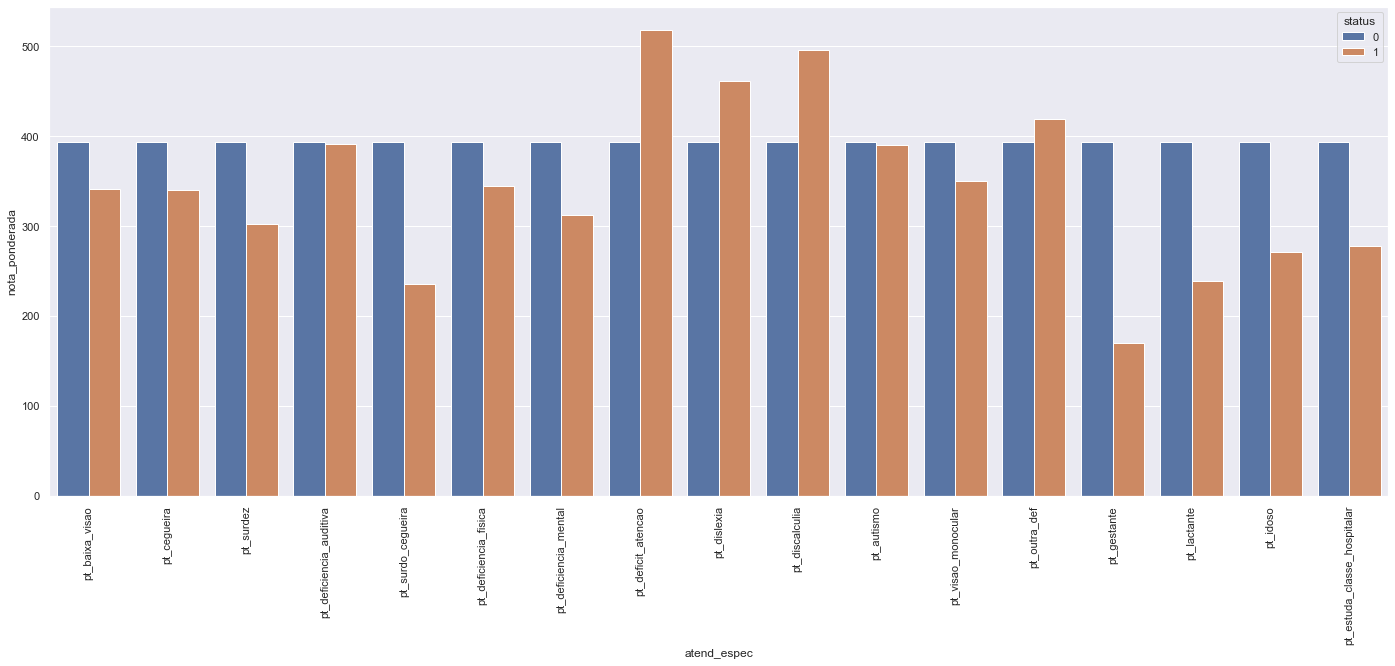

In [53]:
sns.barplot(data=nota_, x='atend_espec', y='nota_ponderada', hue='status').tick_params(axis='x', labelrotation=90);

In [54]:
nota_

status  prv_nt_cnat  prv_nt_chum  prv_nt_ling  prv_nt_mat  prv_nt_redacao  nota_ponderada  participantes                  atend_espec
0      0       347.65       390.65       400.92      380.81          440.09          393.65         330799               pt_baixa_visao
1      1       304.63       346.84       354.83      319.80          372.62          340.80            390               pt_baixa_visao
0      0       347.61       390.60       400.87      380.75          440.02          393.60         331144                  pt_cegueira
1      1       306.72       353.36       351.75      300.68          372.89          339.64             45                  pt_cegueira
0      0       347.61       390.61       400.89      380.75          440.06          393.61         331093                    pt_surdez
1      1       304.82       332.62       328.34      317.99          264.79          301.61             96                    pt_surdez
0      0       347.60       390.59       400.87      380.74          440.02          393.59         331049      pt_deficiencia_auditiva
1      1       357.56       402.10       397.54      382.38          418.86          390.88            140      pt_deficiencia_auditiva
0      0       347.60       390.60       400.87      380.74          440.01          393.59         331185            pt_surdo_cegueira
1      1       214.35       240.12       241.95      237.43          250.00          235.45              4            pt_surdo_cegueira
0      0       347.66       390.64       400.92      380.81          440.11          393.66         330704        pt_deficiencia_fisica
1      1       309.14       360.51       362.67      327.74          366.80          344.14            485        pt_deficiencia_fisica
0      0       347.62       390.62       400.89      380.76          440.09          393.63         331034        pt_deficiencia_mental
1      1       312.91       344.95       341.84      335.23          272.39          311.97            155        pt_deficiencia_mental
0      0       347.41       390.42       400.72      380.50          439.71          393.37         330619           pt_deficit_atencao
1      1       457.18       489.63       482.93      518.66          610.95          517.85            570           pt_deficit_atencao
0      0       347.58       390.58       400.85      380.72          439.97          393.57         331081                  pt_dislexia
1      1       409.00       437.34       439.18      441.77          540.56          460.61            108                  pt_dislexia
0      0       347.60       390.59       400.86      380.73          440.00          393.58         331175               pt_discalculia
1      1       426.78       465.94       464.81      439.11          611.43          494.93             14               pt_discalculia
0      0       347.60       390.59       400.86      380.73          440.02          393.59         331126                   pt_autismo
1      1       373.63       429.75       426.73      393.67          366.67          389.78             63                   pt_autismo
0      0       347.61       390.61       400.87      380.75          440.02          393.60         331117           pt_visao_monocular
1      1       305.73       342.56       351.62      326.47          401.39          349.36             72           pt_visao_monocular
0      0       347.58       390.58       400.85      380.72          439.99          393.57         330953                 pt_outra_def
1      1       375.11       411.38       415.84      410.26          467.97          418.25            236                 pt_outra_def
0      0       347.65       390.65       400.92      380.80          440.07          393.65         331105                  pt_gestante
1      1       135.18       185.92       194.18      143.30          191.43          169.74             84                  pt_gestante
0      0       347.69       390.69       400.96      380.8

### 4.2.9 ATENDIMENTO ESPECIALIZADO VS NOTAS
- No geral pessoas que solicitam algum tipo de atendimento especial não superam a nota média.
- Porém temos algumas observações notáveis:
 * prv_tempo_adicional
 * prv_leitura_labial
 * prv_cadeira_cachoto
 * prv_cadeira_acolchoada
 * prv_lamida_overlay
 * prv_medidor_glicose
 * prv_maquina_braile
 * prv_marca_passo
 * prv_medicamentos
 * prv_sala_individual
 * prv_sala_especial
 * prv_sala_acompanhante
 * prv_material_especifico
 * prv_nome_social

In [55]:
atend_espec = df4.iloc[:, 31:65].columns.tolist()
nota_ = pd.DataFrame()
mapa = {'0': 'nao', '1': 'sim'}
for i in atend_espec:
    aux = df4[[i, 'prv_nt_cnat', 'prv_nt_chum', 'prv_nt_ling', 'prv_nt_mat', 'prv_nt_redacao', 'nota_ponderada']].copy()
    nota = aux.groupby(i).mean().reset_index()
    nota['participantes'] = aux[[i, 'nota_ponderada']].groupby(i).count()['nota_ponderada'].tolist()
    nota['atend_espec'] = nota.columns.tolist()[0]
    nota = nota.rename(columns={i:'status'})
    #nota['atend_espec'] = nota['atend_espec'] + "_" + nota['status'].map(mapa)
    nota_ = pd.concat([nota_, nota])

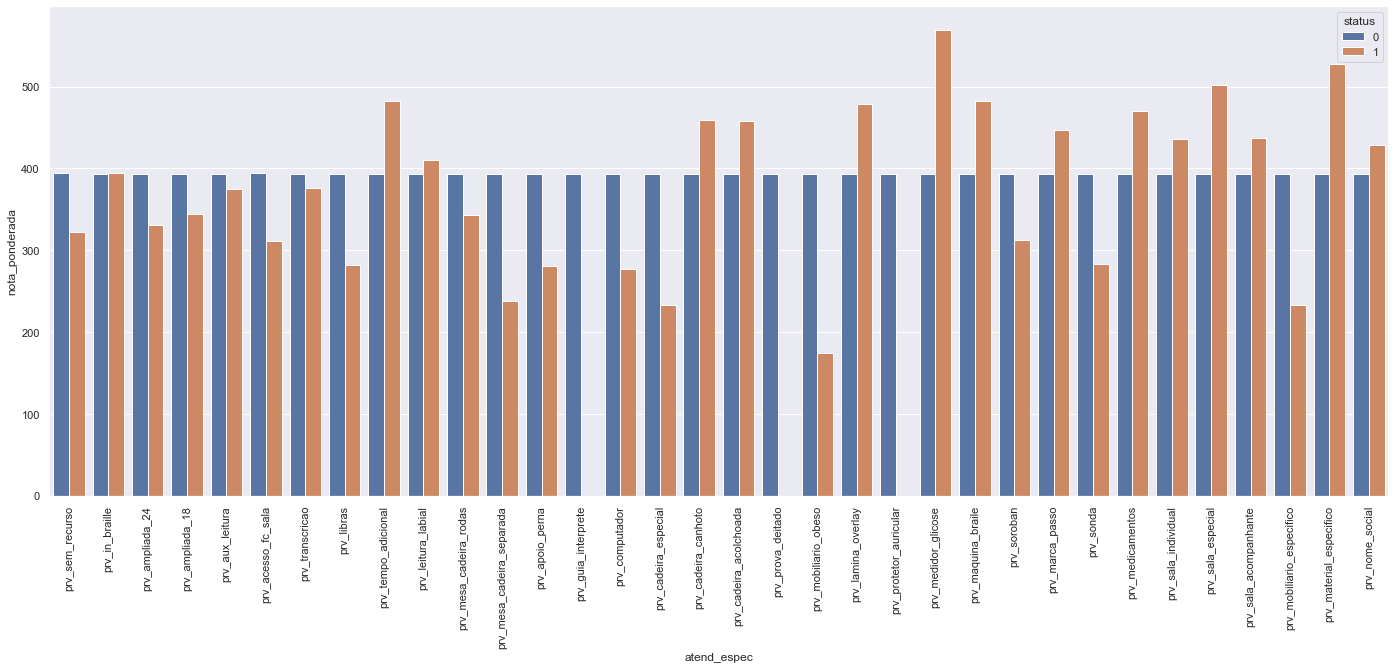

In [56]:
sns.barplot(data=nota_, x='atend_espec', y='nota_ponderada', hue='status').tick_params(axis='x', labelrotation=90);

In [57]:
nota_

status  prv_nt_cnat  prv_nt_chum  prv_nt_ling  prv_nt_mat  prv_nt_redacao  nota_ponderada  participantes                atend_espec
0      0       347.67       390.67       400.94      380.82          440.11          393.67         330809            prv_sem_recurso
1      1       284.16       327.45       336.29      311.47          350.58          321.57            380            prv_sem_recurso
0      0       347.60       390.59       400.86      380.74          440.01          393.59         331169             prv_in_braille
1      1       342.41       403.07       402.62      329.46          459.00          394.20             20             prv_in_braille
0      0       347.61       390.61       400.88      380.75          440.03          393.60         331111            prv_ampliada_24
1      1       302.30       333.42       336.07      316.63          361.03          331.22             78            prv_ampliada_24
0      0       347.63       390.63       400.90      380.78          440.06          393.63         330919            prv_ampliada_18
1      1       309.56       349.92       354.86      324.70          376.52          344.26            270            prv_ampliada_18
0      0       347.60       390.60       400.88      380.75          440.07          393.61         330791            prv_aux_leitura
1      1       349.31       387.97       389.18      367.30          387.09          374.28            398            prv_aux_leitura
0      0       347.72       390.70       400.98      380.89          440.19          393.73         330631         prv_acesso_fc_sala
1      1       275.64       329.51       333.88      288.97          334.66          311.71            558         prv_acesso_fc_sala
0      0       347.60       390.60       400.88      380.75          440.07          393.61         330805            prv_transcricao
1      1       351.22       388.71       389.15      371.70          387.29          375.42            384            prv_transcricao
0      0       347.61       390.61       400.88      380.74          440.04          393.60         331143                 prv_libras
1      1       300.45       312.14       312.62      318.99          221.74          282.29             46                 prv_libras
0      0       347.39       390.40       400.71      380.48          439.70          393.36         330326        prv_tempo_adicional
1      1       428.60       466.38       460.33      477.53          557.61          482.32            863        prv_tempo_adicional
0      0       347.60       390.59       400.87      380.73          440.00          393.59         331151         prv_leitura_labial
1      1       358.56       390.21       384.20      392.38          493.68          410.77             38         prv_leitura_labial
0      0       347.61       390.61       400.88      380.76          440.04          393.61         331061     prv_mesa_cadeira_rodas
1      1       311.32       352.70       357.90      318.21          368.12          342.51            128     prv_mesa_cadeira_rodas
0      0       347.64       390.63       400.90      380.78          440.05          393.63         331101  prv_mesa_cadeira_separada
1      1       201.52       248.68       259.54      212.92          263.41          237.55             88  prv_mesa_cadeira_separada
0      0       347.65       390.64       400.91      380.79          440.07          393.64         331041            prv_apoio_perna
1      1       244.47       299.16       302.29      254.34          305.41          280.77            148            prv_apoio_perna
0      0       347.60       390.59       400.86      380.74          440.01          393.59         331189        prv_guia_interprete
0      0       347.60       390.59       400.86      380.74          440.01          393.59         331188             prv_computador
1      1       360.20       407.80       338.20      363.50           80.00          276.83              1          

### 4.2.10 PROVA ESTADO VS NOTAS
- O ranking do local de origem dos candidatos e onde fazem as provas é bem parecido, trocando algumas posição.
- Provável que esta variável seja correlacionada com a outra (verificar)

In [58]:
aux = df4[['prv_sg_uf', 'prv_nt_cnat', 'prv_nt_chum', 'prv_nt_ling', 'prv_nt_mat', 'prv_nt_redacao', 'nota_ponderada']].copy()
aux.groupby('prv_sg_uf').mean().sort_values('nota_ponderada', ascending=False)

prv_nt_cnat  prv_nt_chum  prv_nt_ling  prv_nt_mat  prv_nt_redacao  nota_ponderada
prv_sg_uf                                                                                   
PB              360.25       397.15       409.31      392.45          460.96          407.18
MG              358.34       400.13       407.73      398.23          458.91          406.56
SE              356.76       392.46       403.73      385.91          465.14          405.15
RJ              355.82       400.11       409.54      389.90          456.87          404.71
PI              358.75       392.75       404.70      389.58          457.50          404.05
SC              354.56       404.64       412.08      395.60          445.82          402.56
RN              357.14       392.82       405.29      388.85          453.67          402.47
SP              354.29       401.80       411.37      393.64          447.33          402.30
RS              350.12       403.33       411.86      387.85          446.01          400.33
CE              352.82       392.78       403.77      390.09          445.87          398.65
DF              350.42       397.09       405.88      381.56          440.94          396.45
GO              349.31       391.32       402.36      381.93          445.30          396.18
PE              351.01       390.15       402.54      386.00          439.20          395.19
PR              351.06       399.57       406.36      388.22          432.62          395.16
ES              348.31       390.63       397.38      386.77          443.73          394.82
AL              349.14       385.24       398.85      378.82          443.83          394.07
PA              338.17       379.63       389.55      358.84          434.39          383.52
BA              336.96       376.87       388.56      363.41          425.06          380.34
MA              337.55       375.67       389.37      362.24          420.40          379.05
TO              330.82       368.95       384.00      356.14          424.76          375.98
MS              329.30       373.90       386.11      356.76          410.59          372.26
AC              323.53       373.13       388.69      346.31          416.27          371.62
MT              326.06       369.81       380.35      352.70          401.56          366.61
RO              324.34       369.13       381.18      350.70          398.12          364.96
AP              312.86       364.75       375.42      328.56          400.84          358.52
RR              317.32       364.38       375.01      338.05          380.24          354.51
AM              286.60       331.28       343.55      307.08          351.16          323.87

### 4.2.11 PRESENÇA PROVA VS NOTAS
- Notas médias por dia de aplicação: aparentemente o pessoal vai melhor no segundo dia.
- Quem opta fazer a prova de inglês tem nota melhor. Interessante notar que a maioria opta em fazer a prova em espanhol...


In [59]:
atend_espec = df4.iloc[:, 69:74].columns.tolist()
nota_ = pd.DataFrame()
mapa = {'0': 'nao', '1': 'sim'}
for i in atend_espec:
    aux = df4[[i, 'prv_nt_cnat', 'prv_nt_chum', 'prv_nt_ling', 'prv_nt_mat', 'prv_nt_redacao', 'nota_ponderada']].copy()
    nota = aux.groupby(i).mean().reset_index()
    nota['participantes'] = aux[[i, 'nota_ponderada']].groupby(i).count()['nota_ponderada'].tolist()
    nota['atend_espec'] = nota.columns.tolist()[0]
    nota = nota.rename(columns={i:'status'})
    #nota['atend_espec'] = nota['atend_espec'] + "_" + nota['status'].map(mapa)
    nota_ = pd.concat([nota_, nota])

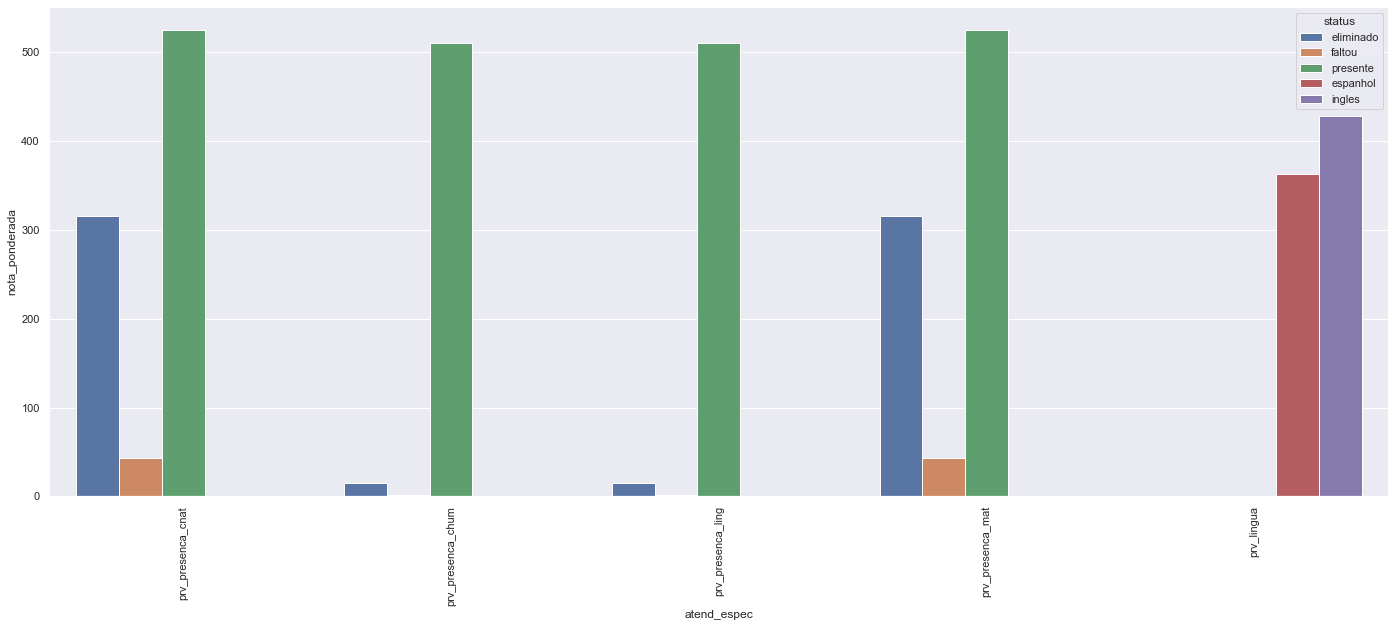

In [60]:
sns.barplot(data=nota_, x='atend_espec', y='nota_ponderada', hue='status').tick_params(axis='x', labelrotation=90);

In [61]:
nota_.sort_values('status')

status  prv_nt_cnat  prv_nt_chum  prv_nt_ling  prv_nt_mat  prv_nt_redacao  nota_ponderada  participantes        atend_espec
0  eliminado         0.00       499.74       513.97        0.00          542.76          315.60            123  prv_presenca_cnat
0  eliminado        35.26         0.00         0.00       39.80            0.00           14.56            271  prv_presenca_chum
0  eliminado        35.26         0.00         0.00       39.80            0.00           14.56            271  prv_presenca_ling
0  eliminado         0.00       499.74       513.97        0.00          542.76          315.60            123   prv_presenca_mat
0   espanhol       320.60       362.81       375.16      345.60          401.38          362.47         173660         prv_lingua
1     faltou         0.00        74.09        78.23        0.00           68.60           43.64          90174  prv_presenca_cnat
1     faltou         2.93         0.00         0.00        3.19            0.00            1.20          75995  prv_presenca_chum
1     faltou         2.93         0.00         0.00        3.19            0.00            1.20          75995  prv_presenca_ling
1     faltou         0.00        74.09        78.23        0.00           68.60           43.64          90174   prv_presenca_mat
1     ingles       377.37       421.22       429.20      419.47          482.59          427.90         157529         prv_lingua
2   presente       477.90       509.02       521.58      523.45          578.98          524.63         240892  prv_presenca_cnat
2   presente       450.68       507.45       520.79      493.65          571.65          510.97         254923  prv_presenca_chum
2   presente       450.68       507.45       520.79      493.65          571.65          510.97         254923  prv_presenca_ling
2   presente       477.90       509.02       521.58      523.45          578.98          524.63         240892   prv_presenca_mat

### 4.2.12 STATUS REDAÇÂO VS NOTAS
- 74% dos candidatos reprovam na prova de redação com alguma inedequação na composição do texto.
- A má execução da redação praticamente derruba a nota do candidato pela metade.


In [24]:
atend_espec = df4.iloc[:, 74:75].columns.tolist()
nota_ = pd.DataFrame()
mapa = {'0': 'nao', '1': 'sim'}
for i in atend_espec:
    aux = df4[[i, 'prv_nt_cnat', 'prv_nt_chum', 'prv_nt_ling', 'prv_nt_mat', 'prv_nt_redacao', 'nota_ponderada']].copy()
    nota = aux.groupby(i).mean().reset_index()
    nota['participantes'] = aux[[i, 'nota_ponderada']].groupby(i).count()['nota_ponderada'].tolist()
    nota['atend_espec'] = nota.columns.tolist()[0]
    nota = nota.rename(columns={i:'status'})
    #nota['atend_espec'] = nota['atend_espec'] + "_" + nota['status'].map(mapa)
    nota_ = pd.concat([nota_, nota])

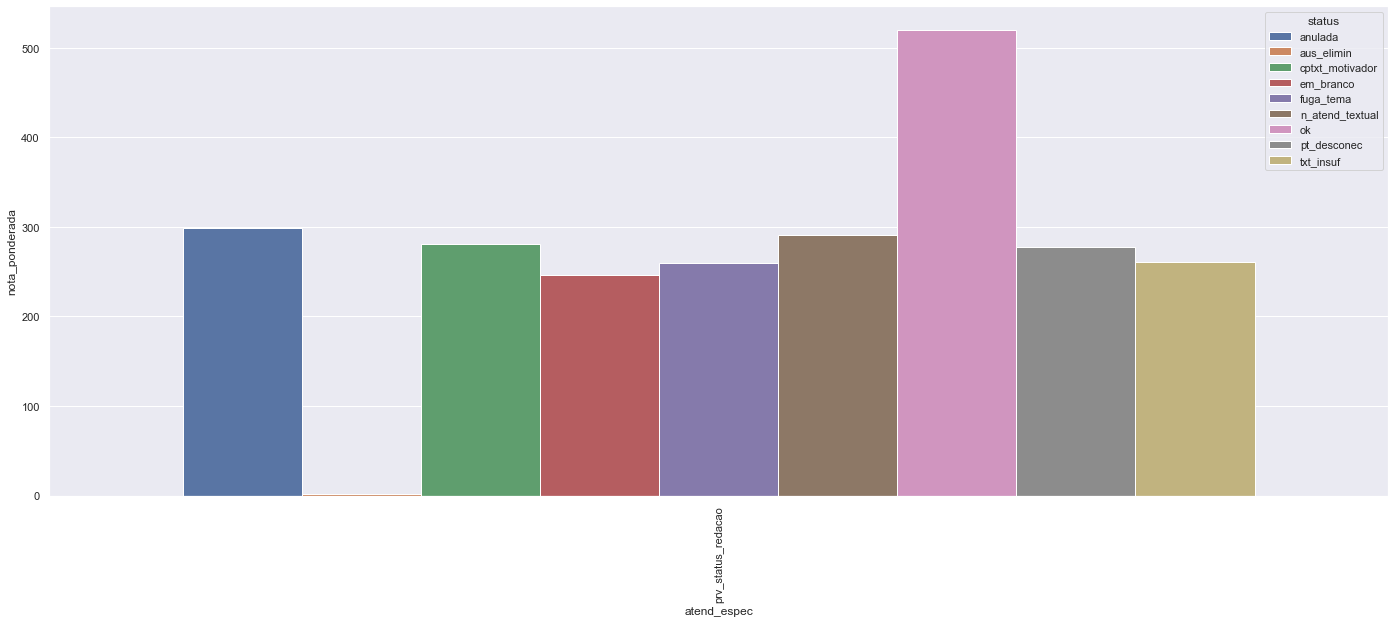

In [26]:
sns.barplot(data=nota_, x='atend_espec', y='nota_ponderada', hue='status').tick_params(axis='x', labelrotation=90);

In [64]:
nota_

status  prv_nt_cnat  prv_nt_chum  prv_nt_ling  prv_nt_mat  prv_nt_redacao  nota_ponderada  participantes         atend_espec
0          anulada       386.88       463.64       479.72      409.42            0.00          299.32            359  prv_status_redacao
1       aus_elimin         3.04         0.00         0.00        3.32            0.00            1.24          76266  prv_status_redacao
2  cptxt_motivador       366.41       424.63       443.97      395.82            0.00          280.76           1518  prv_status_redacao
3        em_branco       271.78       432.56       463.52      291.88            0.00          246.68           3703  prv_status_redacao
4        fuga_tema       319.43       424.89       439.76      338.08            0.00          260.08           2608  prv_status_redacao
5  n_atend_textual       381.26       443.21       457.56      404.68            0.00          290.68            262  prv_status_redacao
6               ok       455.91       510.32       523.31      499.71          593.28          520.42         245629  prv_status_redacao
7      pt_desconec       345.24       448.36       464.10      365.04            0.00          277.73            296  prv_status_redacao
8        txt_insuf       305.35       439.08       466.14      319.79            0.00          260.72            548  prv_status_redacao

### 4.2.13 QUESTIONARIO SOCIAL VS NOTAS - Q001 / Q002 - Escolaridade dos pais
- No geral, o tempo de estudo do pai pesa mais doq a mão no valor da nota.

In [65]:
atend_espec = df4.iloc[:, 75:77].columns.tolist()
nota_ = pd.DataFrame()
mapa = {'0': 'nao', '1': 'sim'}
for i in atend_espec:
    aux = df4[[i, 'prv_nt_cnat', 'prv_nt_chum', 'prv_nt_ling', 'prv_nt_mat', 'prv_nt_redacao', 'nota_ponderada']].copy()
    nota = aux.groupby(i).mean().reset_index()
    nota['participantes'] = aux[[i, 'nota_ponderada']].groupby(i).count()['nota_ponderada'].tolist()
    nota['atend_espec'] = nota.columns.tolist()[0]
    nota = nota.rename(columns={i:'status'})
    #nota['atend_espec'] = nota['atend_espec'] + "_" + nota['status'].map(mapa)
    nota_ = pd.concat([nota_, nota])

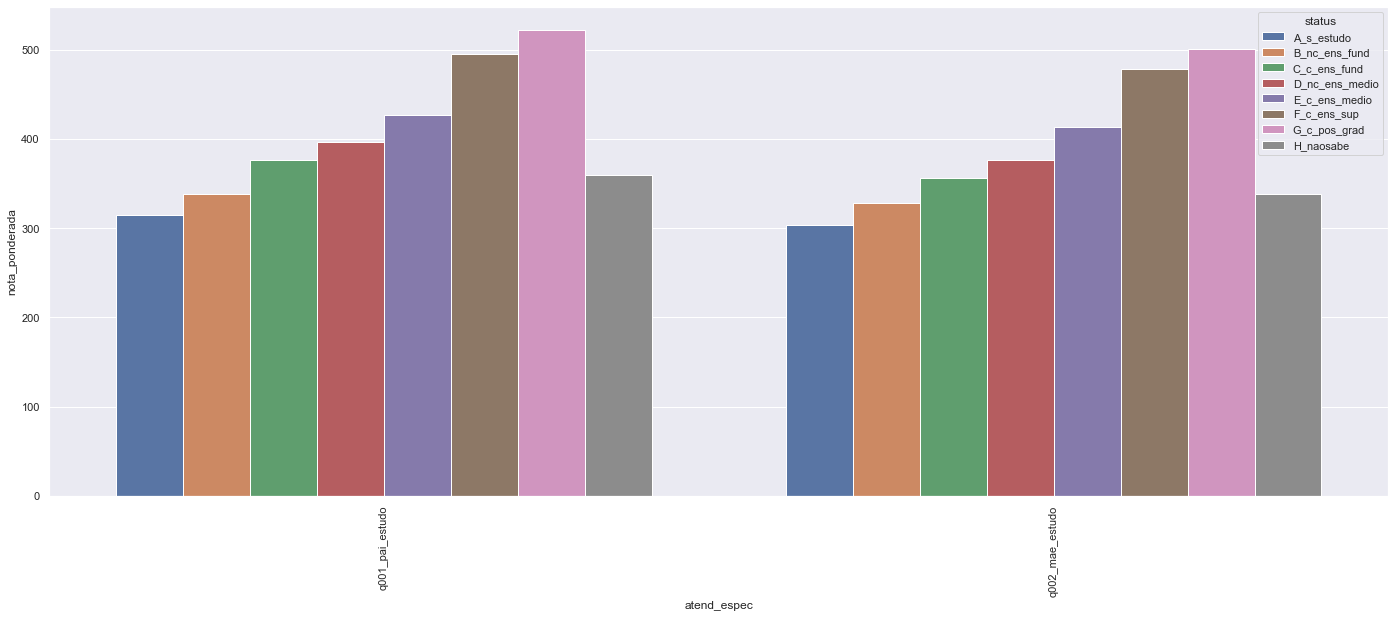

In [66]:
sns.barplot(data=nota_, x='atend_espec', y='nota_ponderada', hue='status').tick_params(axis='x', labelrotation=90);

In [67]:
nota_

status  prv_nt_cnat  prv_nt_chum  prv_nt_ling  prv_nt_mat  prv_nt_redacao  nota_ponderada  participantes      atend_espec
0      A_s_estudo       283.40       323.65       334.33      298.99          334.06          314.37          18797  q001_pai_estudo
1   B_nc_ens_fund       300.24       342.77       354.50      321.61          371.49          338.86          73636  q001_pai_estudo
2    C_c_ens_fund       331.89       375.99       388.19      360.66          417.24          376.04          47297  q001_pai_estudo
3  D_nc_ens_medio       348.95       392.92       405.82      381.44          443.04          396.20          38162  q001_pai_estudo
4   E_c_ens_medio       376.10       419.44       429.69      415.42          483.48          427.30          85277  q001_pai_estudo
5     F_c_ens_sup       435.75       476.60       478.13      494.83          570.60          494.67          24202  q001_pai_estudo
6    G_c_pos_grad       458.92       498.89       496.97      527.29          607.68          521.99          14840  q001_pai_estudo
7       H_naosabe       318.97       364.14       377.40      343.43          393.13          359.87          28978  q001_pai_estudo
0      A_s_estudo       275.53       315.97       325.33      288.32          317.56          303.42          12775  q002_mae_estudo
1   B_nc_ens_fund       291.96       334.40       345.53      310.32          357.28          328.35          55597  q002_mae_estudo
2    C_c_ens_fund       315.75       358.86       371.30      341.07          392.52          356.73          44408  q002_mae_estudo
3  D_nc_ens_medio       331.70       376.47       389.69      360.38          418.25          376.61          43408  q002_mae_estudo
4   E_c_ens_medio       363.15       407.49       419.09      399.42          464.99          412.95         106299  q002_mae_estudo
5     F_c_ens_sup       421.16       462.04       466.33      474.68          549.66          478.18          33328  q002_mae_estudo
6    G_c_pos_grad       439.51       480.12       481.83      499.74          580.12          500.24          26136  q002_mae_estudo
7       H_naosabe       305.57       345.43       358.01      328.12          358.27          338.11           9238  q002_mae_estudo

### 4.2.14 QUESTIONARIO SOCIAL VS NOTAS - Q003 / Q004 - Ocupação dos pais
- A nota média tanto para o pai e quanto para mão são parecidas. Não há diferença discrepante.

In [68]:
atend_espec = df4.iloc[:, 77:79].columns.tolist()
nota_ = pd.DataFrame()
mapa = {'0': 'nao', '1': 'sim'}
for i in atend_espec:
    aux = df4[[i, 'prv_nt_cnat', 'prv_nt_chum', 'prv_nt_ling', 'prv_nt_mat', 'prv_nt_redacao', 'nota_ponderada']].copy()
    nota = aux.groupby(i).mean().reset_index()
    nota['participantes'] = aux[[i, 'nota_ponderada']].groupby(i).count()['nota_ponderada'].tolist()
    nota['atend_espec'] = nota.columns.tolist()[0]
    nota = nota.rename(columns={i:'status'})
    #nota['atend_espec'] = nota['atend_espec'] + "_" + nota['status'].map(mapa)
    nota_ = pd.concat([nota_, nota])

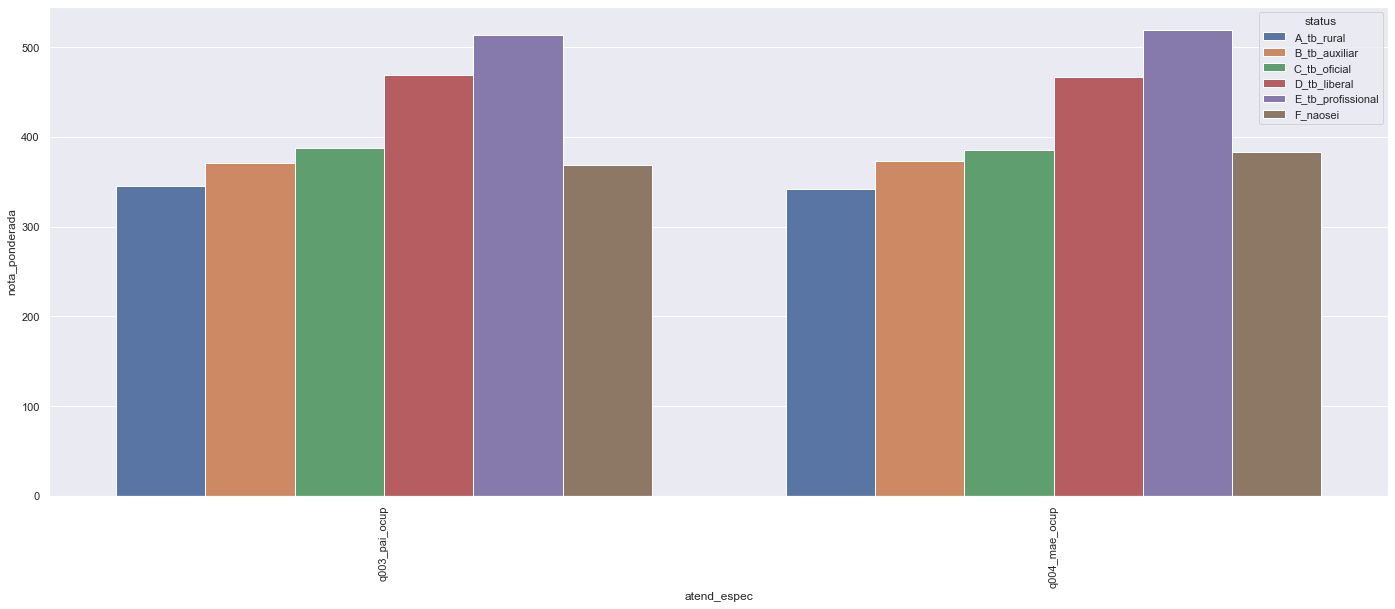

In [69]:
sns.barplot(data=nota_, x='atend_espec', y='nota_ponderada', hue='status').tick_params(axis='x', labelrotation=90);

In [70]:
nota_

status  prv_nt_cnat  prv_nt_chum  prv_nt_ling  prv_nt_mat  prv_nt_redacao  nota_ponderada  participantes    atend_espec
0         A_tb_rural       308.80       347.65       358.89      331.13          375.79          345.03          70698  q003_pai_ocup
1      B_tb_auxiliar       326.32       370.61       383.88      352.88          412.68          370.83          69839  q003_pai_ocup
2       C_tb_oficial       341.02       386.41       398.57      371.73          431.51          387.29          78810  q003_pai_ocup
3       D_tb_liberal       412.53       454.96       460.11      462.83          538.49          469.11          56511  q003_pai_ocup
4  E_tb_profissional       451.49       491.74       488.94      520.64          597.76          513.80          18059  q003_pai_ocup
5           F_naosei       326.22       371.76       384.65      353.82          405.24          368.92          37272  q003_pai_ocup
0         A_tb_rural       307.30       345.33       356.21      328.82          370.65          342.04          57606  q004_mae_ocup
1      B_tb_auxiliar       328.14       373.34       386.27      355.60          414.36          372.90         143491  q004_mae_ocup
2       C_tb_oficial       338.91       384.78       396.76      371.10          428.90          385.28          22732  q004_mae_ocup
3       D_tb_liberal       410.41       452.11       457.90      459.67          535.67          466.58          66528  q004_mae_ocup
4  E_tb_profissional       454.94       496.70       493.76      524.40          605.91          519.12          12468  q004_mae_ocup
5           F_naosei       340.36       383.55       394.08      372.80          422.20          383.22          28364  q004_mae_ocup

### 4.2.15 QUESTIONARIO SOCIAL VS NOTAS - Q005 - Total de Ocupantes
- A maioria dos participantes indicaram até 4 pessoas morando junto, no qual também representa a maior nota. Entretanto, não existe uma tendência de aumento ou queda conforme este número aumenta.

In [71]:
atend_espec = df4.iloc[:, 79:80].columns.tolist()
nota_ = pd.DataFrame()
mapa = {'0': 'nao', '1': 'sim'}
for i in atend_espec:
    aux = df4[[i, 'prv_nt_cnat', 'prv_nt_chum', 'prv_nt_ling', 'prv_nt_mat', 'prv_nt_redacao', 'nota_ponderada']].copy()
    nota = aux.groupby(i).mean().reset_index()
    nota['participantes'] = aux[[i, 'nota_ponderada']].groupby(i).count()['nota_ponderada'].tolist()
    nota['atend_espec'] = nota.columns.tolist()[0]
    nota = nota.rename(columns={i:'status'})
    #nota['atend_espec'] = nota['atend_espec'] + "_" + nota['status'].map(mapa)
    nota_ = pd.concat([nota_, nota])

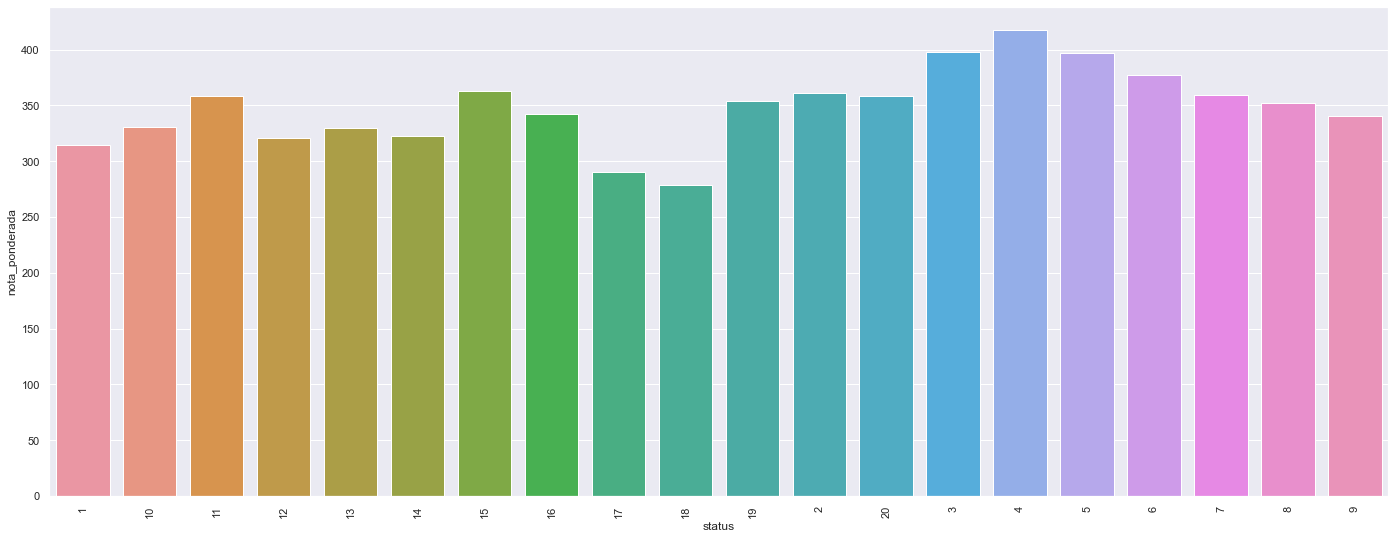

In [72]:
sns.barplot(data=nota_, x='status', y='nota_ponderada').tick_params(axis='x', labelrotation=90);

In [73]:
nota_

status  prv_nt_cnat  prv_nt_chum  prv_nt_ling  prv_nt_mat  prv_nt_redacao  nota_ponderada  participantes    atend_espec
0       1       279.38       324.69       328.69      300.71          340.42          314.22           9101  q005_res_ocup
1      10       291.54       341.08       352.26      314.69          357.72          330.81            903  q005_res_ocup
2      11       322.47       363.18       374.13      343.61          388.10          358.68            289  q005_res_ocup
3      12       285.76       326.86       340.48      309.68          343.30          320.47            182  q005_res_ocup
4      13       290.20       336.83       344.36      315.49          362.69          329.97            104  q005_res_ocup
5      14       276.57       335.44       343.80      289.11          360.00          322.18             42  q005_res_ocup
6      15       326.10       393.17       389.38      339.15          378.79          362.57             33  q005_res_ocup
7      16       314.63       343.91       348.66      333.53          368.42          342.39             19  q005_res_ocup
8      17       264.71       327.88       341.09      290.84          270.00          290.50              8  q005_res_ocup
9      18       243.47       310.48       318.43      253.12          284.44          278.42              9  q005_res_ocup
10     19       249.44       388.95       397.56      255.98          451.43          354.26             14  q005_res_ocup
11      2       317.67       362.50       371.43      344.36          401.20          360.63          41955  q005_res_ocup
12     20       324.13       375.59       361.31      364.61          383.87          358.68             31  q005_res_ocup
13      3       350.77       393.66       403.60      384.07          445.60          397.40          84580  q005_res_ocup
14      4       368.78       410.85       421.00      406.96          469.67          417.52         106794  q005_res_ocup
15      5       350.45       392.94       404.57      384.40          442.64          396.58          54039  q005_res_ocup
16      6       332.77       376.94       389.36      361.48          417.47          376.78          19929  q005_res_ocup
17      7       318.06       362.56       375.16      343.49          393.82          359.20           8128  q005_res_ocup
18      8       312.54       353.62       368.30      336.16          385.45          352.04           3658  q005_res_ocup
19      9       303.07       346.51       358.36      325.35          368.94          340.46           1371  q005_res_ocup

### 4.2.16 QUESTIONARIO SOCIAL VS NOTAS - Q006 - Renda Familiar
- Há uma clara correção da renda com o valor da nota final do aluno. Quanto maior renda, melhor a nota.

In [74]:
atend_espec = df4.iloc[:, 80:81].columns.tolist()
nota_ = pd.DataFrame()
mapa = {'0': 'nao', '1': 'sim'}
for i in atend_espec:
    aux = df4[[i, 'prv_nt_cnat', 'prv_nt_chum', 'prv_nt_ling', 'prv_nt_mat', 'prv_nt_redacao', 'nota_ponderada']].copy()
    nota = aux.groupby(i).mean().reset_index()
    nota['participantes'] = aux[[i, 'nota_ponderada']].groupby(i).count()['nota_ponderada'].tolist()
    nota['atend_espec'] = nota.columns.tolist()[0]
    nota = nota.rename(columns={i:'status'})
    #nota['atend_espec'] = nota['atend_espec'] + "_" + nota['status'].map(mapa)
    nota_ = pd.concat([nota_, nota])

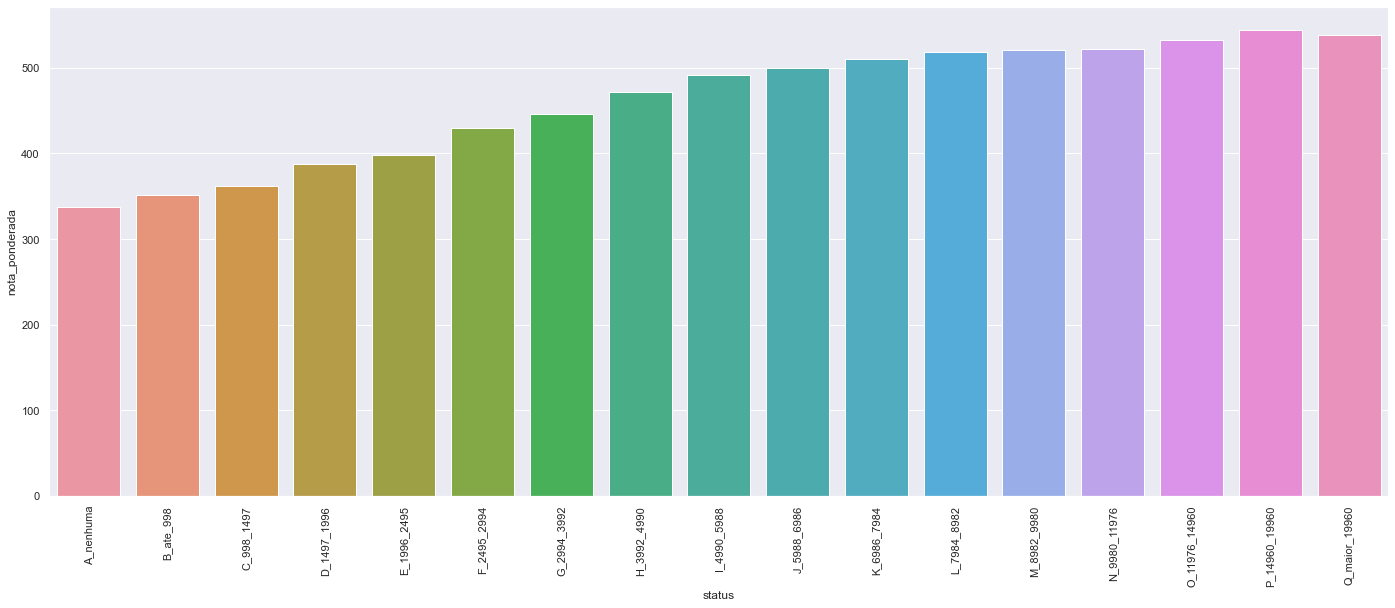

In [75]:
sns.barplot(data=nota_, x='status', y='nota_ponderada').tick_params(axis='x', labelrotation=90);

In [76]:
nota_

status  prv_nt_cnat  prv_nt_chum  prv_nt_ling  prv_nt_mat  prv_nt_redacao  nota_ponderada  participantes     atend_espec
0       A_nenhuma       303.39       342.03       355.58      322.21          362.83          337.41          14965  q006_fam_renda
1       B_ate_998       311.43       353.82       368.37      332.87          384.26          351.05          82789  q006_fam_renda
2      C_998_1497       319.60       363.70       376.67      343.87          401.70          362.48          85398  q006_fam_renda
3     D_1497_1996       341.78       387.11       398.05      373.36          431.83          387.74          32357  q006_fam_renda
4     E_1996_2495       350.15       394.80       405.20      383.82          446.41          397.87          31045  q006_fam_renda
5     F_2495_2994       379.62       423.34       431.16      422.44          484.42          430.02          14774  q006_fam_renda
6     G_2994_3992       392.33       436.64       443.68      438.32          506.72          445.95          19740  q006_fam_renda
7     H_3992_4990       416.60       457.31       461.25      468.50          539.08          471.54          12551  q006_fam_renda
8     I_4990_5988       433.50       474.30       476.24      491.00          564.98          491.32           9284  q006_fam_renda
9     J_5988_6986       439.82       479.68       479.61      500.78          578.77          499.54           5171  q006_fam_renda
10    K_6986_7984       449.80       490.45       489.72      515.85          590.78          510.75           3728  q006_fam_renda
11    L_7984_8982       456.90       496.49       495.08      525.47          600.74          518.50           2931  q006_fam_renda
12    M_8982_9980       458.10       499.51       496.17      527.66          606.43          521.31           2764  q006_fam_renda
13   N_9980_11976       460.04       499.04       495.02      532.13          606.84          522.18           4096  q006_fam_renda
14  O_11976_14960       468.50       505.13       499.70      546.91          621.01          532.00           3134  q006_fam_renda
15  P_14960_19960       479.73       516.00       506.75      561.31          637.86          544.36           2776  q006_fam_renda
16  Q_maior_19960       468.94       511.79       501.88      558.23          635.20          538.62           3686  q006_fam_renda

### 4.2.16 QUESTIONARIO SOCIAL VS NOTAS - Q007 - Empregados
- A existência de empregados domésticos indica um valor maior da nota. Provalvente também se correlaciona a renda.

In [77]:
atend_espec = df4.iloc[:, 81:82].columns.tolist()
nota_ = pd.DataFrame()
mapa = {'0': 'nao', '1': 'sim'}
for i in atend_espec:
    aux = df4[[i, 'prv_nt_cnat', 'prv_nt_chum', 'prv_nt_ling', 'prv_nt_mat', 'prv_nt_redacao', 'nota_ponderada']].copy()
    nota = aux.groupby(i).mean().reset_index()
    nota['participantes'] = aux[[i, 'nota_ponderada']].groupby(i).count()['nota_ponderada'].tolist()
    nota['atend_espec'] = nota.columns.tolist()[0]
    nota = nota.rename(columns={i:'status'})
    #nota['atend_espec'] = nota['atend_espec'] + "_" + nota['status'].map(mapa)
    nota_ = pd.concat([nota_, nota])

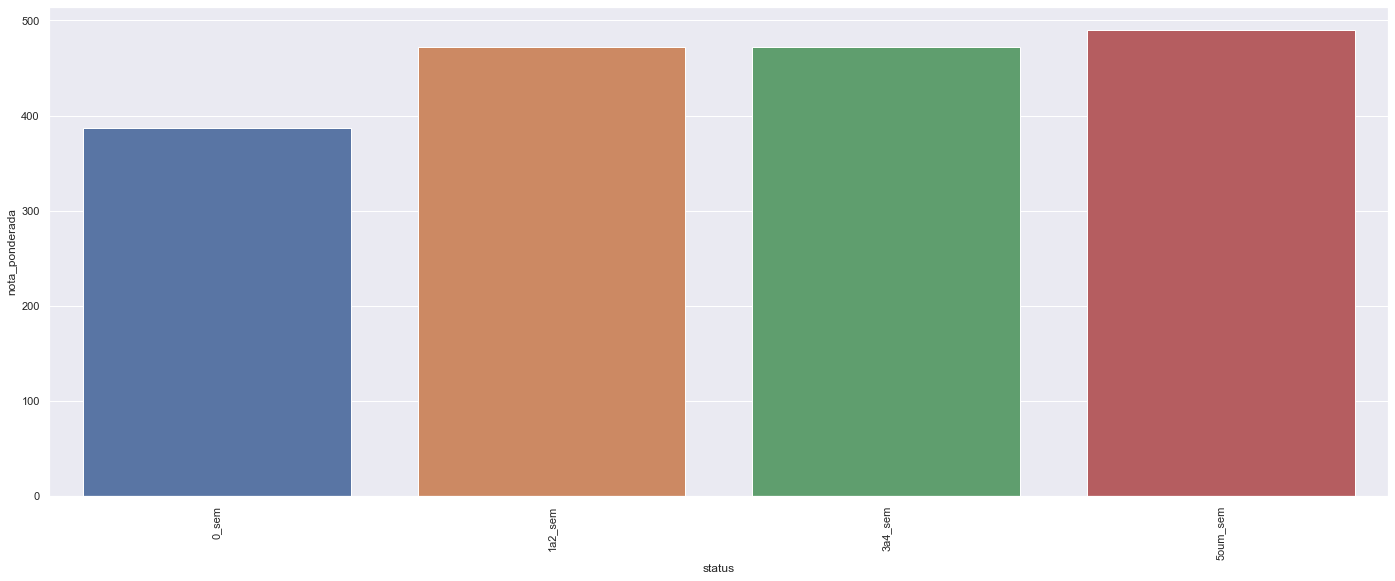

In [78]:
sns.barplot(data=nota_, x='status', y='nota_ponderada').tick_params(axis='x', labelrotation=90);

In [79]:
nota_

status  prv_nt_cnat  prv_nt_chum  prv_nt_ling  prv_nt_mat  prv_nt_redacao  nota_ponderada  participantes      atend_espec
0     0_sem       341.99       385.14       396.10      372.95          431.29          387.01         307389  q007_res_empreg
1   1a2_sem       416.40       456.20       457.69      474.56          542.18          472.19          12727  q007_res_empreg
2   3a4_sem       412.12       454.75       457.92      474.85          547.43          472.41           2664  q007_res_empreg
3  5oum_sem       427.97       470.43       470.95      493.40          570.08          489.99           8409  q007_res_empreg

### 4.2.14 QUESTIONARIO SOCIAL VS NOTAS - Q008 a Q025 - Itens residência
- Quanto mais banheiros, televisores, celulares e computadores melhor é a nota do candidato.
- A existência isolada da internet em si não é tão significativa (é melhor estutante ter tv por assinatura...)
- Os demais itens não possui uma crescente, variam a cada quantidade.


In [80]:
atend_espec = df4.iloc[:, 82:100].columns.tolist()
nota_ = pd.DataFrame()
mapa = {'0': 'nao', '1': 'sim'}
for i in atend_espec:
    aux = df4[[i, 'prv_nt_cnat', 'prv_nt_chum', 'prv_nt_ling', 'prv_nt_mat', 'prv_nt_redacao', 'nota_ponderada']].copy()
    nota = aux.groupby(i).mean().reset_index()
    nota['participantes'] = aux[[i, 'nota_ponderada']].groupby(i).count()['nota_ponderada'].tolist()
    nota['atend_espec'] = nota.columns.tolist()[0]
    nota = nota.rename(columns={i:'status'})
    #nota['atend_espec'] = nota['atend_espec'] + "_" + nota['status'].map(mapa)
    nota_ = pd.concat([nota_, nota])

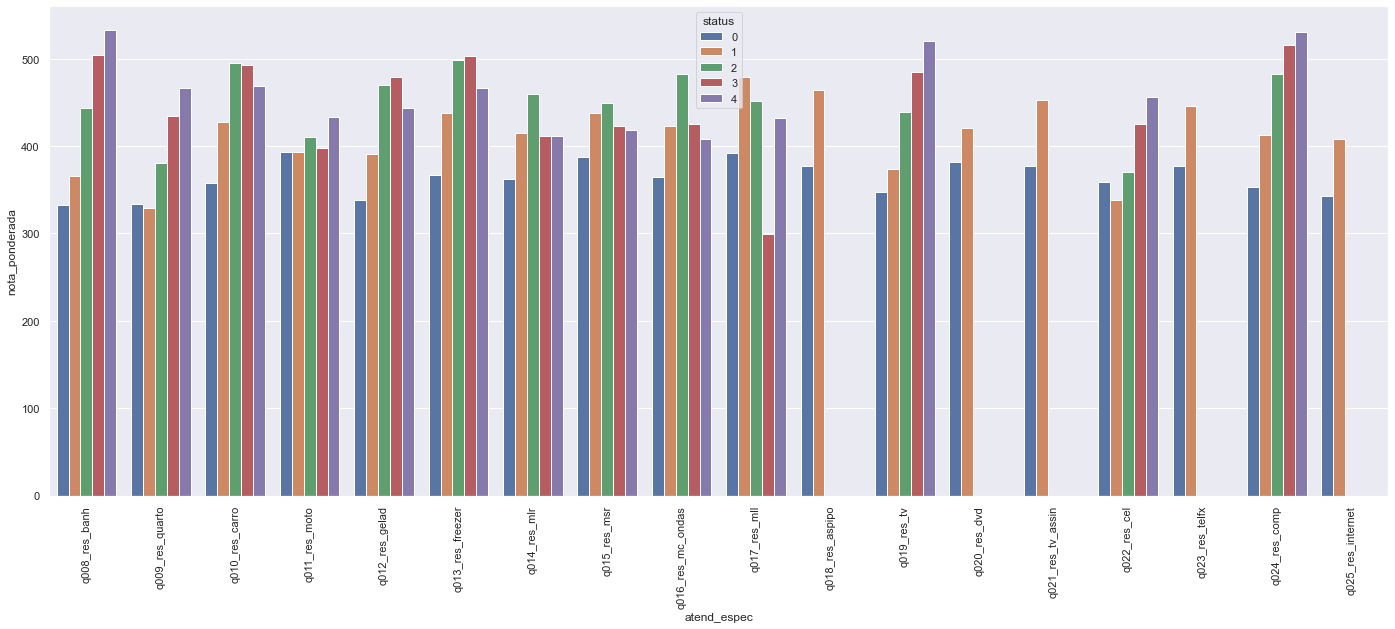

In [81]:
sns.barplot(data=nota_, x='atend_espec', y='nota_ponderada', hue='status').tick_params(axis='x', labelrotation=90);

In [82]:
nota_

status  prv_nt_cnat  prv_nt_chum  prv_nt_ling  prv_nt_mat  prv_nt_redacao  nota_ponderada  participantes        atend_espec
0      0       298.58       338.42       349.84      319.56          358.60          332.92           3225      q008_res_banh
1      1       323.64       367.27       379.68      349.76          405.01          366.23         234158      q008_res_banh
2      2       392.20       433.89       441.00      436.64          503.49          443.96          67014      q008_res_banh
3      3       443.02       484.53       485.70      506.04          583.25          504.08          17711      q008_res_banh
4      4       467.66       507.80       503.60      544.32          623.55          533.30           9081      q008_res_banh
0      0       295.79       340.83       353.64      316.06          360.29          333.24           2689    q009_res_quarto
1      1       291.36       335.82       347.38      311.72          359.01          329.34          45175    q009_res_quarto
2      2       335.98       379.35       391.26      365.02          423.75          380.61         167822    q009_res_quarto
3      3       384.03       425.67       433.70      426.85          491.52          434.66          99559    q009_res_quarto
4      4       410.49       453.52       456.44      464.69          532.41          465.98          15944    q009_res_quarto
0      0       316.22       359.69       372.44      339.97          395.52          357.98         188102     q010_res_carro
1      1       377.11       420.13       428.54      418.17          481.13          427.01         114421     q010_res_carro
2      2       436.68       476.31       478.18      499.24          568.57          494.76          24487     q010_res_carro
3      3       433.80       474.55       472.71      500.68          569.53          493.06           3408     q010_res_carro
4      4       414.27       454.18       454.78      477.79          533.72          468.55            771     q010_res_carro
0      0       346.83       390.71       400.68      379.60          440.33          393.31         256826      q011_res_moto
1      1       348.71       388.93       400.31      382.40          437.21          392.97          67147      q011_res_moto
2      2       365.02       402.61       413.68      406.11          455.73          409.83           6469      q011_res_moto
3      3       356.80       389.87       397.60      397.37          441.18          397.64            642      q011_res_moto
4      4       392.04       439.64       432.10      433.21          472.76          433.15            105      q011_res_moto
0      0       302.30       344.29       354.86      323.69          365.14          338.00           5735     q012_res_gelad
1      1       345.45       388.48       399.06      377.84          437.19          391.24         311781     q012_res_gelad
2      2       415.66       457.85       461.06      470.49          535.06          470.26          12684     q012_res_gelad
3      3       420.15       468.34       467.44      479.57          550.45          479.46            823     q012_res_gelad
4      4       388.58       438.32       440.87      443.86          502.29          443.65            166     q012_res_gelad
0      0       324.59       366.74       378.43      350.90          406.12          366.66         211876   q013_res_freezer
1      1       384.72       429.30       437.50      428.70          495.15          437.26         111242   q013_res_freezer
2      2       439.64       483.62       485.68      502.70          570.73          498.88           7070   q013_res_freezer
3      3       449.56       486.23       483.89      514.07          571.76          503.20            801   q013_res_freezer
4      4       414.07       461.47       457.22      469.33          524.00          465.94            200   q013_res_freezer
0      0       320.38       361.68       374.72      344.99          400.43          361.85     

In [83]:
df4.iloc[:, 82:100].columns

Index(['q008_res_banh', 'q009_res_quarto', 'q010_res_carro', 'q011_res_moto',
       'q012_res_gelad', 'q013_res_freezer', 'q014_res_mlr', 'q015_res_msr',
       'q016_res_mc_ondas', 'q017_res_mll', 'q018_res_aspipo', 'q019_res_tv',
       'q020_res_dvd', 'q021_res_tv_assin', 'q022_res_cel', 'q023_res_telfx',
       'q024_res_comp', 'q025_res_internet'],
      dtype='object')

In [84]:
df4.head()

pt_nu_inscricao  pt_co_municipio_residencia pt_no_municipio_residencia  pt_co_uf_residencia pt_sg_uf_residencia  pt_idade pt_sexo pt_estado_civil pt_cor_raca pt_nacionalidade pt_conclusao_ensmedio pt_ano_conc_ensmedio pt_tp_escola pt_treineiro pt_baixa_visao pt_cegueira pt_surdez pt_deficiencia_auditiva pt_surdo_cegueira pt_deficiencia_fisica pt_deficiencia_mental pt_deficit_atencao pt_dislexia pt_discalculia pt_autismo pt_visao_monocular pt_outra_def pt_gestante pt_lactante pt_idoso pt_estuda_classe_hospitalar prv_sem_recurso prv_in_braille prv_ampliada_24 prv_ampliada_18 prv_aux_leitura prv_acesso_fc_sala prv_transcricao prv_libras prv_tempo_adicional prv_leitura_labial prv_mesa_cadeira_rodas prv_mesa_cadeira_separada prv_apoio_perna prv_guia_interprete prv_computador prv_cadeira_especial prv_cadeira_canhoto prv_cadeira_acolchoada prv_prova_deitado prv_mobiliario_obeso prv_lamina_overlay prv_protetor_auricular prv_medidor_glicose prv_maquina_braile prv_soroban prv_marca_passo prv_sonda prv_medicamentos prv_sala_individual prv_sala_especial prv_sala_acompanhante prv_mobiliario_especifico prv_material_especifico prv_nome_social  prv_co_municipio  prv_no_municipio  prv_co_uf prv_sg_uf prv_presenca_cnat prv_presenca_chum prv_presenca_ling prv_presenca_mat prv_lingua prv_status_redacao q001_pai_estudo q002_mae_estudo  q003_pai_ocup  q004_mae_ocup q005_res_ocup q006_fam_renda q007_res_empreg q008_res_banh q009_res_quarto q010_res_carro q011_res_moto q012_res_gelad q013_res_freezer q014_res_mlr q015_res_msr q016_res_mc_ondas q017_res_mll q018_res_aspipo q019_res_tv q020_res_dvd q021_res_tv_assin q022_res_cel q023_res_telfx q024_res_comp q025_res_internet  prv_nt_cnat  prv_nt_chum  prv_nt_ling  prv_nt_mat  prv_nt_redacao  nota_ponderada
0  a42faea7-8171-43c3-b868-35068e82f30d                     1302603                     manaus                   13                  AM     46.00       f          casado       parda          br_nato             concluido                 2017      publica            0              0           0         0                       0                 0                     0                     0                  0           0              0          0                  0            0           0           0        0                           0               0              0               0               0               0                  0               0          0                   0                  0                      0                         0               0                   0              0                    0                   0                      0                 0                    0                  0                      0                   0                  0           0               0         0                0                   0                 0                     0                         0                       0               0           1302603            Manaus         13        AM            faltou            faltou            faltou           faltou   espanhol         aus_elimin    C_c_ens_fund  D_nc_ens_medio   C_tb_oficial  B_tb_auxiliar             6     C_998_1497           0_sem             2               2              1             0              1                0            1            0                 0            0               1           2            0                 0            2              0             1                 1         0.00         0.00         0.00        0.00            0.00            0.00
1  d7b568f5-319c-4d49-b5af-385e5eadc703                     1500800                 ananindeua                   15                  PA     23.00       m        solteiro       parda          br_nato             concluido                 2017      publica            0              0           0         0                       0                 0                     0                     0                  0           0              0          0       

## 4.3. ANÁLISE MULTIVARIADA

### 4.3.1. NUMERICAL ATTIBUTES

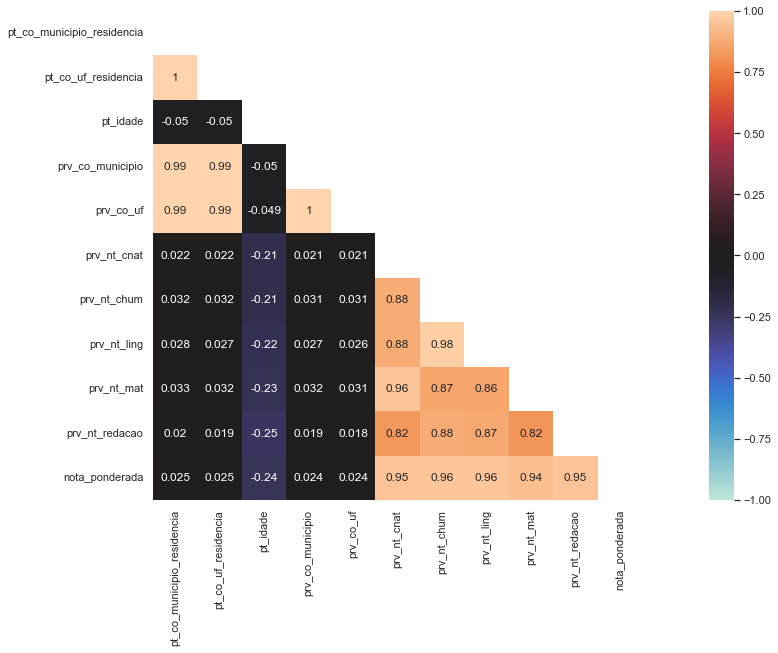

In [85]:
corr = num_attributes.corr(method ='pearson')
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

with sns.axes_style("white"):
    ax = sns.heatmap(corr, annot=True, mask=mask, vmin=-1, center=0, vmax=1, square=True)

### 4.3.2. CATEGORICAL ATTRIBUTES

In [158]:
cat_attributes = cat_attributes.drop('pt_nu_inscricao', axis=1)

#### DADOS PARTICIPANTE

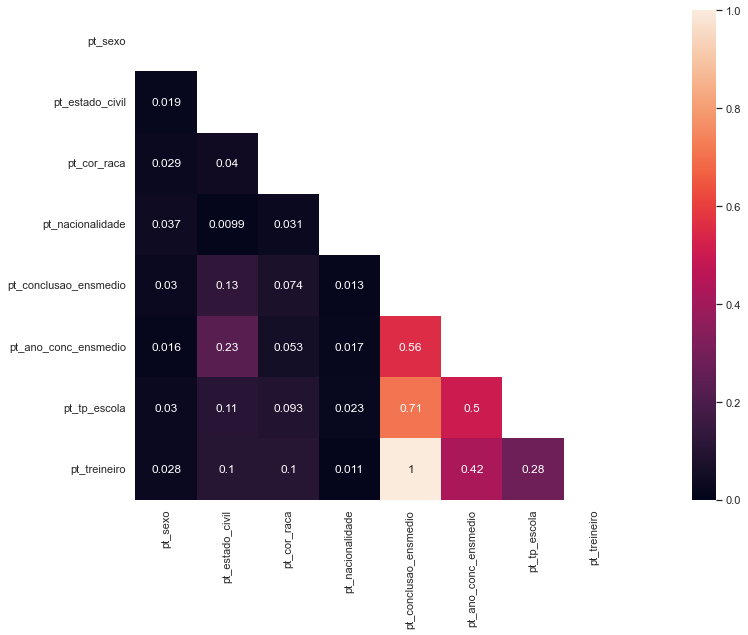

In [164]:
a = cat_attributes.iloc[:,0:8].copy()
nivel = a.shape[1]
a_d = a.columns.tolist()
a_e = a.columns.tolist()

crm_l = []
for i in range(nivel):
    crm = []
    for j in range(nivel):
        crm.append(cramer_v(a[a_d[i]], a[a_e[j]]))
    crm_l.append(crm)
    
corr = pd.DataFrame(crm_l)
corr.columns = a_d
corr.index = a_d

mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

with sns.axes_style("white"):
    ax = sns.heatmap(corr, annot=True, mask=mask, vmin=0, vmax=1, square=True)

#### DADOS ESPECIFICOS PARTICIPANTE

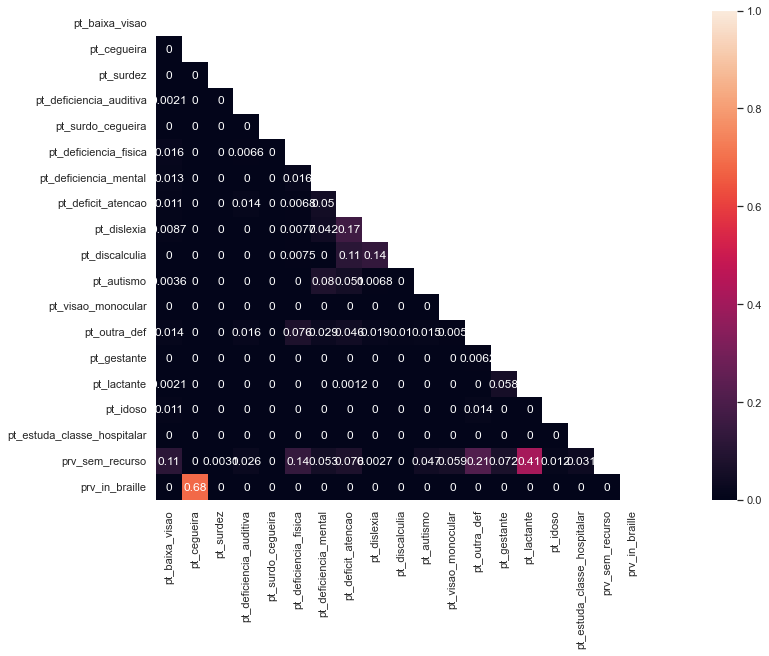

In [165]:
a = cat_attributes.iloc[:,8:27].copy()
nivel = a.shape[1]
a_d = a.columns.tolist()
a_e = a.columns.tolist()

crm_l = []
for i in range(nivel):
    crm = []
    for j in range(nivel):
        crm.append(cramer_v(a[a_d[i]], a[a_e[j]]))
    crm_l.append(crm)
    
corr = pd.DataFrame(crm_l)
corr.columns = a_d
corr.index = a_d

mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

with sns.axes_style("white"):
    ax = sns.heatmap(corr, annot=True, mask=mask, vmin=0, vmax=1, square=True)

#### DADOS ESPECIFICOS PROVA

C:\Users\kaotc\AppData\Local\Temp\ipykernel_15780\624951368.py:56: RuntimeWarning: invalid value encountered in double_scalars
  return np.sqrt((chi2corr/n)/(min(kcorr-1,rcorr-1)))
C:\Users\kaotc\AppData\Local\Temp\ipykernel_15780\624951368.py:56: RuntimeWarning: invalid value encountered in double_scalars
  return np.sqrt((chi2corr/n)/(min(kcorr-1,rcorr-1)))
C:\Users\kaotc\AppData\Local\Temp\ipykernel_15780\624951368.py:56: RuntimeWarning: invalid value encountered in double_scalars
  return np.sqrt((chi2corr/n)/(min(kcorr-1,rcorr-1)))
C:\Users\kaotc\AppData\Local\Temp\ipykernel_15780\624951368.py:56: RuntimeWarning: invalid value encountered in double_scalars
  return np.sqrt((chi2corr/n)/(min(kcorr-1,rcorr-1)))
C:\Users\kaotc\AppData\Local\Temp\ipykernel_15780\624951368.py:56: RuntimeWarning: invalid value encountered in double_scalars
  return np.sqrt((chi2corr/n)/(min(kcorr-1,rcorr-1)))
C:\Users\kaotc\AppData\Local\Temp\ipykernel_15780\624951368.py:56: RuntimeWarning: invalid valu

C:\Users\kaotc\AppData\Local\Temp\ipykernel_15780\624951368.py:56: RuntimeWarning: invalid value encountered in double_scalars
  return np.sqrt((chi2corr/n)/(min(kcorr-1,rcorr-1)))
C:\Users\kaotc\AppData\Local\Temp\ipykernel_15780\624951368.py:56: RuntimeWarning: invalid value encountered in double_scalars
  return np.sqrt((chi2corr/n)/(min(kcorr-1,rcorr-1)))
C:\Users\kaotc\AppData\Local\Temp\ipykernel_15780\624951368.py:56: RuntimeWarning: invalid value encountered in double_scalars
  return np.sqrt((chi2corr/n)/(min(kcorr-1,rcorr-1)))
C:\Users\kaotc\AppData\Local\Temp\ipykernel_15780\624951368.py:56: RuntimeWarning: invalid value encountered in double_scalars
  return np.sqrt((chi2corr/n)/(min(kcorr-1,rcorr-1)))
C:\Users\kaotc\AppData\Local\Temp\ipykernel_15780\624951368.py:56: RuntimeWarning: invalid value encountered in double_scalars
  return np.sqrt((chi2corr/n)/(min(kcorr-1,rcorr-1)))
C:\Users\kaotc\AppData\Local\Temp\ipykernel_15780\624951368.py:56: RuntimeWarning: invalid valu

C:\Users\kaotc\AppData\Local\Temp\ipykernel_15780\624951368.py:56: RuntimeWarning: invalid value encountered in double_scalars
  return np.sqrt((chi2corr/n)/(min(kcorr-1,rcorr-1)))
C:\Users\kaotc\AppData\Local\Temp\ipykernel_15780\624951368.py:56: RuntimeWarning: invalid value encountered in double_scalars
  return np.sqrt((chi2corr/n)/(min(kcorr-1,rcorr-1)))
C:\Users\kaotc\AppData\Local\Temp\ipykernel_15780\624951368.py:56: RuntimeWarning: invalid value encountered in double_scalars
  return np.sqrt((chi2corr/n)/(min(kcorr-1,rcorr-1)))
C:\Users\kaotc\AppData\Local\Temp\ipykernel_15780\624951368.py:56: RuntimeWarning: invalid value encountered in double_scalars
  return np.sqrt((chi2corr/n)/(min(kcorr-1,rcorr-1)))
C:\Users\kaotc\AppData\Local\Temp\ipykernel_15780\624951368.py:56: RuntimeWarning: invalid value encountered in double_scalars
  return np.sqrt((chi2corr/n)/(min(kcorr-1,rcorr-1)))
C:\Users\kaotc\AppData\Local\Temp\ipykernel_15780\624951368.py:56: RuntimeWarning: invalid valu

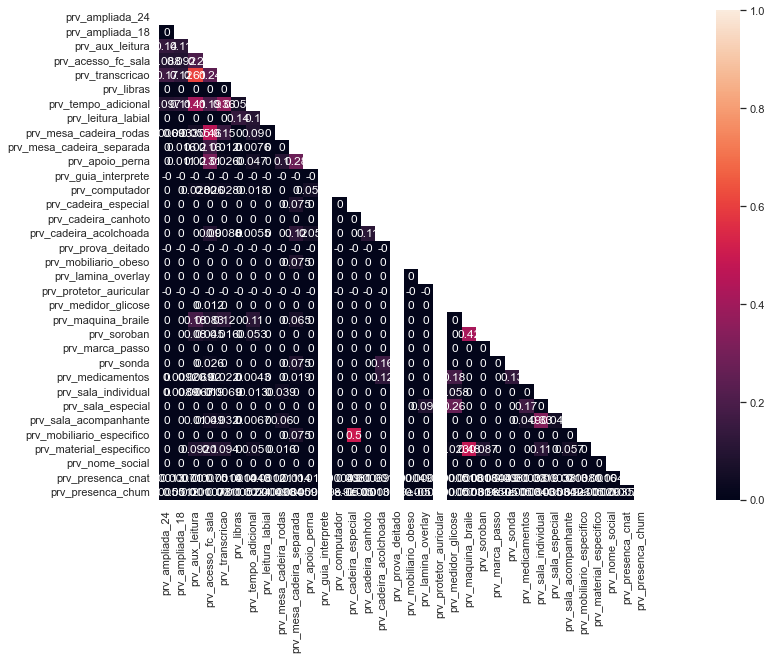

In [161]:
a = cat_attributes.iloc[:,27:61].copy()
nivel = a.shape[1]
a_d = a.columns.tolist()
a_e = a.columns.tolist()

crm_l = []
for i in range(nivel):
    crm = []
    for j in range(nivel):
        crm.append(cramer_v(a[a_d[i]], a[a_e[j]]))
    crm_l.append(crm)
    
corr = pd.DataFrame(crm_l)
corr.columns = a_d
corr.index = a_d

mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

with sns.axes_style("white"):
    ax = sns.heatmap(corr, annot=True, mask=mask, vmin=0, vmax=1, square=True)

#### DADOS LOCAL / PRESENÇA PROVA

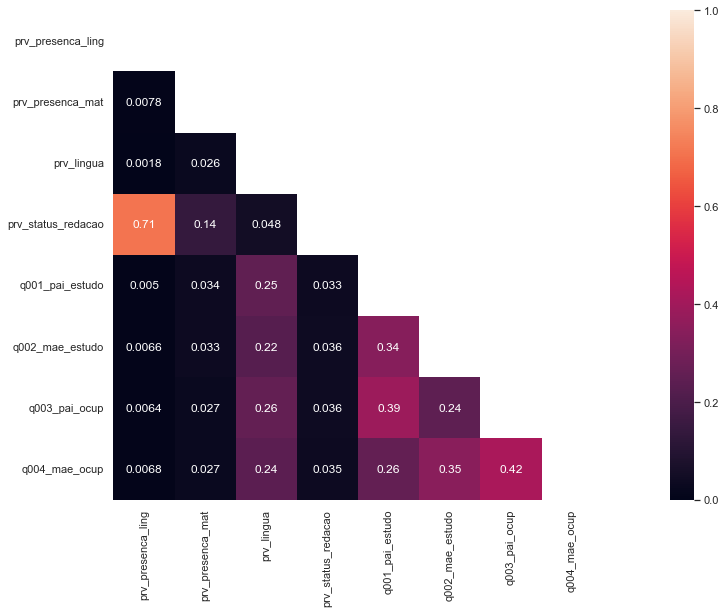

In [162]:
a = cat_attributes.iloc[:,61:69].copy()
nivel = a.shape[1]
a_d = a.columns.tolist()
a_e = a.columns.tolist()

crm_l = []
for i in range(nivel):
    crm = []
    for j in range(nivel):
        crm.append(cramer_v(a[a_d[i]], a[a_e[j]]))
    crm_l.append(crm)
    
corr = pd.DataFrame(crm_l)
corr.columns = a_d
corr.index = a_d

mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

with sns.axes_style("white"):
    ax = sns.heatmap(corr, annot=True, mask=mask, vmin=0, vmax=1, square=True)

#### DADOS LOCAL / PRESENÇA PROVA

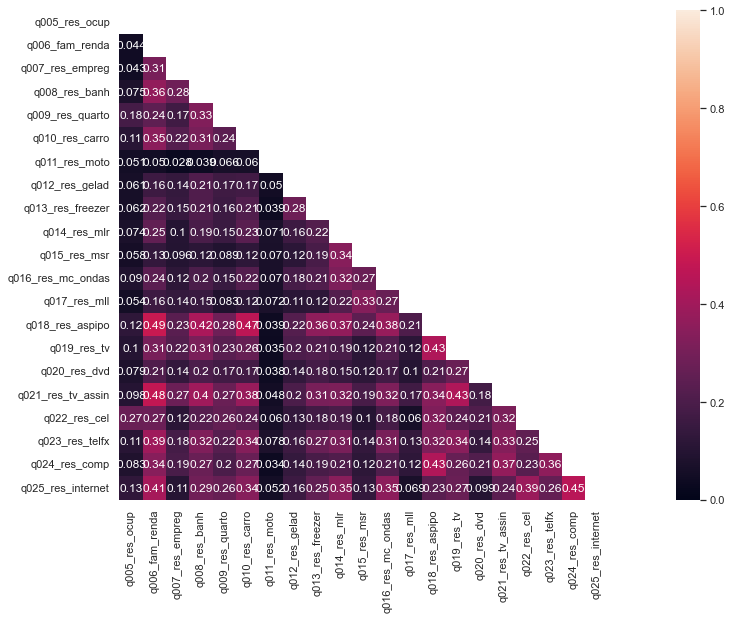

In [163]:
a = cat_attributes.iloc[:,69:].copy()
nivel = a.shape[1]
a_d = a.columns.tolist()
a_e = a.columns.tolist()

crm_l = []
for i in range(nivel):
    crm = []
    for j in range(nivel):
        crm.append(cramer_v(a[a_d[i]], a[a_e[j]]))
    crm_l.append(crm)
    
corr = pd.DataFrame(crm_l)
corr.columns = a_d
corr.index = a_d

mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

with sns.axes_style("white"):
    ax = sns.heatmap(corr, annot=True, mask=mask, vmin=0, vmax=1, square=True)

# <font color='red'> 5.0. Data Preparation </font>

In [67]:
df5 = df4.copy()
#df5['pt_munc_uf'] = df5['pt_sg_uf_residencia'] + "/" + df5['pt_no_municipio_residencia']
#df5['prv_munc_uf'] = df5['prv_sg_uf'] + "/" + df5['prv_no_municipio']
df5 = df5.drop(columns=['pt_co_municipio_residencia' ,'pt_no_municipio_residencia','pt_co_uf_residencia' ,'pt_sg_uf_residencia', 
                        'prv_co_municipio', 'prv_no_municipio', 'prv_co_uf', 'prv_sg_uf'])
df5.head()

pt_nu_inscricao  pt_idade pt_sexo pt_estado_civil pt_cor_raca pt_nacionalidade pt_conclusao_ensmedio pt_ano_conc_ensmedio pt_tp_escola pt_treineiro pt_baixa_visao pt_cegueira pt_surdez pt_deficiencia_auditiva pt_surdo_cegueira pt_deficiencia_fisica pt_deficiencia_mental pt_deficit_atencao pt_dislexia pt_discalculia pt_autismo pt_visao_monocular pt_outra_def pt_gestante pt_lactante pt_idoso pt_estuda_classe_hospitalar prv_sem_recurso prv_in_braille prv_ampliada_24 prv_ampliada_18 prv_aux_leitura prv_acesso_fc_sala prv_transcricao prv_libras prv_tempo_adicional prv_leitura_labial prv_mesa_cadeira_rodas prv_mesa_cadeira_separada prv_apoio_perna prv_guia_interprete prv_computador prv_cadeira_especial prv_cadeira_canhoto prv_cadeira_acolchoada prv_prova_deitado prv_mobiliario_obeso prv_lamina_overlay prv_protetor_auricular prv_medidor_glicose prv_maquina_braile prv_soroban prv_marca_passo prv_sonda prv_medicamentos prv_sala_individual prv_sala_especial prv_sala_acompanhante prv_mobiliario_especifico prv_material_especifico prv_nome_social prv_presenca_cnat prv_presenca_chum prv_presenca_ling prv_presenca_mat prv_lingua prv_status_redacao q001_pai_estudo q002_mae_estudo  q003_pai_ocup  q004_mae_ocup q005_res_ocup q006_fam_renda q007_res_empreg q008_res_banh q009_res_quarto q010_res_carro q011_res_moto q012_res_gelad q013_res_freezer q014_res_mlr q015_res_msr q016_res_mc_ondas q017_res_mll q018_res_aspipo q019_res_tv q020_res_dvd q021_res_tv_assin q022_res_cel q023_res_telfx q024_res_comp q025_res_internet  prv_nt_cnat  prv_nt_chum  prv_nt_ling  prv_nt_mat  prv_nt_redacao  nota_ponderada
0  a42faea7-8171-43c3-b868-35068e82f30d     46.00       f          casado       parda          br_nato             concluido                 2017      publica            0              0           0         0                       0                 0                     0                     0                  0           0              0          0                  0            0           0           0        0                           0               0              0               0               0               0                  0               0          0                   0                  0                      0                         0               0                   0              0                    0                   0                      0                 0                    0                  0                      0                   0                  0           0               0         0                0                   0                 0                     0                         0                       0               0            faltou            faltou            faltou           faltou   espanhol         aus_elimin    C_c_ens_fund  D_nc_ens_medio   C_tb_oficial  B_tb_auxiliar             6     C_998_1497           0_sem             2               2              1             0              1                0            1            0                 0            0               1           2            0                 0            2              0             1                 1         0.00         0.00         0.00        0.00            0.00            0.00
1  d7b568f5-319c-4d49-b5af-385e5eadc703     23.00       m        solteiro       parda          br_nato             concluido                 2017      publica            0              0           0         0                       0                 0                     0                     0                  0           0              0          0                  0            0           0           0        0                           0               0              0               0               0               0                  0               0          0                   0                  0                      0                         0               0                   0              0                    0                   0           

In [68]:
df5_r = df5.copy()

In [87]:
# DIA 1
df5_r_presente_dia1 = df5_r[(df5_r['prv_presenca_ling'] == 'presente')].copy()
df5_r_presente_dia1 = df5_r_presente_dia1.drop(columns=['prv_presenca_cnat', 'prv_presenca_ling', 'prv_presenca_chum', 'prv_presenca_ling', 'prv_presenca_mat', 'prv_status_redacao','prv_nt_cnat', 'prv_nt_mat', 'prv_nt_redacao','nota_ponderada'])

df5_r_ausente_dia1 = df5_r[~(df5_r['prv_presenca_ling'] == 'presente')].copy()
df5_r_ausente_dia1 = df5_r_ausente_dia1[['pt_nu_inscricao', 'prv_nt_chum', 'prv_nt_ling']]

# DIA 2
df5_r_presente_dia2 = df5_r[(df5_r['prv_presenca_cnat'] == 'presente')].copy()
df5_r_presente_dia2 = df5_r_presente_dia2.drop(columns=['prv_presenca_cnat', 'prv_presenca_ling', 'prv_presenca_chum', 'prv_presenca_ling', 'prv_presenca_mat', 'prv_status_redacao', 'prv_nt_chum', 'prv_nt_ling', 'prv_nt_redacao','nota_ponderada'])

df5_r_ausente_dia2 = df5_r[~(df5_r['prv_presenca_cnat'] == 'presente')].copy()
df5_r_ausente_dia2 = df5_r_ausente_dia2[['pt_nu_inscricao', 'prv_nt_cnat', 'prv_nt_mat']]

# REDAÇÂO
df5_r_presente_redacao = df5_r[(df5_r['prv_status_redacao'] == 'ok')].copy()
df5_r_presente_redacao = df5_r_presente_redacao.drop(columns=['prv_presenca_cnat', 'prv_presenca_ling', 'prv_presenca_chum', 'prv_presenca_ling', 'prv_presenca_mat', 'prv_status_redacao', 'prv_nt_cnat', 'prv_nt_mat', 'prv_nt_chum', 'prv_nt_ling','nota_ponderada'])

df5_r_ausente_redacao = df5_r[~(df5_r['prv_status_redacao'] == 'ok')].copy()
df5_r_ausente_redacao = df5_r_ausente_redacao[['pt_nu_inscricao', 'prv_nt_redacao']]

In [70]:
df5_r_ausente_redacao.head()

pt_nu_inscricao  prv_nt_redacao
0  a42faea7-8171-43c3-b868-35068e82f30d            0.00
1  d7b568f5-319c-4d49-b5af-385e5eadc703            0.00
2  8b04ed6a-c479-4bf3-8d88-9927c995f518            0.00
4  1aec7054-9817-42d5-9268-063a4b80af3a            0.00
7  22932627-3112-4e9f-8163-78c1ccec8495            0.00

DF Criados
* df5_r_presente_dia1
* df5_r_ausente_dia1
* df5_r_presente_dia2
* df5_r_ausente_dia2
* df5_r_presente_redacao
* df5_r_ausente_redacao

In [71]:
num_attributes = df5_r.select_dtypes(include=('int64', 'float64'))
cat_attributes = df5_r.select_dtypes(exclude=('int64', 'float64', 'datetime64[ns]'))

## 5.1. NORMALIZATION

In [72]:
num_attributes.describe().T

count   mean    std   min    25%    50%    75%     max
pt_idade       331189.00  22.08   7.43 11.00  18.00  19.00  24.00   84.00
prv_nt_cnat    331189.00 347.60 222.51  0.00   0.00 430.60 508.00  815.10
prv_nt_chum    331189.00 390.59 225.55  0.00 356.10 475.10 549.90  808.50
prv_nt_ling    331189.00 400.86 226.34  0.00 380.80 502.90 553.10  770.50
prv_nt_mat     331189.00 380.74 251.01  0.00   0.00 450.20 557.60  985.50
prv_nt_redacao 331189.00 440.01 292.09  0.00   0.00 540.00 640.00 1000.00
nota_ponderada 331189.00 393.59 234.61  0.00 273.41 480.63 555.79  836.02

## 5.2. RESCALLING

In [73]:
def rescalling(df5):
    #rs_columns = []
    mms_columns = ['pt_idade']
    
    #rs = RobustScaler()
    mms = MinMaxScaler()
    
    #Min-Max Scaler
    df5[mms_columns] = mms.fit_transform(df5[mms_columns])
    
    #Robest Scaler
    #df5_r[rs_columns] = rs.fit_transform(df5[rs_columns])
    return df5

In [88]:
df5_r_presente_dia1 = rescalling(df5_r_presente_dia1)
df5_r_presente_dia2 = rescalling(df5_r_presente_dia2)
df5_r_presente_redacao = rescalling(df5_r_presente_redacao)

## 5.3. TRANSFORMATION

### 5.3.1 ENCODING

In [75]:
cat_attributes.describe().T

count  unique                                   top    freq
pt_nu_inscricao              331189  331189  a42faea7-8171-43c3-b868-35068e82f30d       1
pt_sexo                      331189       2                                     f  197700
pt_estado_civil              331189       5                              solteiro  286060
pt_cor_raca                  331189       6                                 parda  153499
pt_nacionalidade             331189       5                               br_nato  321680
pt_conclusao_ensmedio        331189       4                             concluido  194827
pt_ano_conc_ensmedio         331189      14                                    nd  142831
pt_tp_escola                 331189       3                               publica  236192
pt_treineiro                 331189       2                                     0  291104
pt_baixa_visao               331189       2                                     0  330799
pt_cegueira                  331189       2                                     0  331144
pt_surdez                    331189       2                                     0  331093
pt_deficiencia_auditiva      331189       2                                     0  331049
pt_surdo_cegueira            331189       2                                     0  331185
pt_deficiencia_fisica        331189       2                                     0  330704
pt_deficiencia_mental        331189       2                                     0  331034
pt_deficit_atencao           331189       2                                     0  330619
pt_dislexia                  331189       2                                     0  331081
pt_discalculia               331189       2                                     0  331175
pt_autismo                   331189       2                                     0  331126
pt_visao_monocular           331189       2                                     0  331117
pt_outra_def                 331189       2                                     0  330953
pt_gestante                  331189       2                                     0  331105
pt_lactante                  331189       2                                     0  330963
pt_idoso                     331189       2                                     0  331177
pt_estuda_classe_hospitalar  331189       2                                     0  331187
prv_sem_recurso              331189       2                                     0  330809
prv_in_braille               331189       2                                     0  331169
prv_ampliada_24              331189       2                                     0  331111
prv_ampliada_18              331189       2                                     0  330919
prv_aux_leitura              331189       2                                     0  330791
prv_acesso_fc_sala           331189       2                                     0  330631
prv_transcricao              331189       2                                     0  330805
prv_libras                   331189       2                                     0  331143
prv_tempo_adicional          331189       2                                     0  330326
prv_leitura_labial           331189       2                                     0  331151
prv_mesa_cadeira_rodas       331189       2                                     0  331061
prv_mesa_cadeira_separada    331189       2                                     0  331101
prv_apoio_perna              331189       2                                     0  331041
prv_guia_interprete          331189       1                                     0  331189
prv_computador               331189       2                                     0  331188
prv_cadeira_especial         331189       2                                     0  331188
prv_cadeira_canhoto          331189       2                                     0  331187
prv_cadeira_acolchoada       331189       2                           

In [76]:
#df5_r_presente_redacao.iloc[:, 9:61].head()

In [77]:
def encoding(df5):
    # Convertendo em int os dados sobre o participante e solicitações de prova (0 ou 1)
    df5.iloc[:, 9:61] = df5_r.iloc[:, 9:61].astype('int')
    
    # state_holiday - One Hot Encoding
    df5 = pd.get_dummies(df5, prefix=['pt_sexo'], columns=['pt_sexo'])
    df5 = pd.get_dummies(df5, prefix=['pt_estado_civil'], columns=['pt_estado_civil'])
    df5 = pd.get_dummies(df5, prefix=['pt_cor_raca'], columns=['pt_cor_raca'])
    df5 = pd.get_dummies(df5, prefix=['pt_nacionalidade'], columns=['pt_nacionalidade'])
    df5 = pd.get_dummies(df5, prefix=['pt_conclusao_ensmedio'], columns=['pt_conclusao_ensmedio'])
    df5 = pd.get_dummies(df5, prefix=['pt_ano_conc_ensmedio'], columns=['pt_ano_conc_ensmedio'])
    df5 = pd.get_dummies(df5, prefix=['pt_tp_escola'], columns=['pt_tp_escola'])
    
    # Dados relativos a prova - One Hot Encoding
    #df5 = pd.get_dummies(df5, prefix=['prv_presenca_cnat'], columns=['prv_presenca_cnat'])
    #df5 = pd.get_dummies(df5, prefix=['prv_presenca_chum'], columns=['prv_presenca_chum'])
    #df5 = pd.get_dummies(df5, prefix=['prv_presenca_ling'], columns=['prv_presenca_ling'])
    #df5 = pd.get_dummies(df5, prefix=['prv_presenca_mat'], columns=['prv_presenca_mat'])
    df5 = pd.get_dummies(df5, prefix=['prv_lingua'], columns=['prv_lingua'])
    #df5 = pd.get_dummies(df5, prefix=['prv_status_redacao'], columns=['prv_status_redacao'])
    
    # Dados relativos a questionário social - One Hot Encoding
    df5 = pd.get_dummies(df5, prefix=['q001_pai_estudo'], columns=['q001_pai_estudo'])
    df5 = pd.get_dummies(df5, prefix=['q002_mae_estudo'], columns=['q002_mae_estudo'])
    df5 = pd.get_dummies(df5, prefix=['q003_pai_ocup'], columns=['q003_pai_ocup'])
    df5 = pd.get_dummies(df5, prefix=['q004_mae_ocup'], columns=['q004_mae_ocup'])
    df5 = pd.get_dummies(df5, prefix=['q005_res_ocup'], columns=['q005_res_ocup'])
    df5 = pd.get_dummies(df5, prefix=['q006_fam_renda'], columns=['q006_fam_renda'])
    df5 = pd.get_dummies(df5, prefix=['q007_res_empreg'], columns=['q007_res_empreg'])
    df5 = pd.get_dummies(df5, prefix=['q008_res_banh'], columns=['q008_res_banh'])
    df5 = pd.get_dummies(df5, prefix=['q009_res_quarto'], columns=['q009_res_quarto'])
    df5 = pd.get_dummies(df5, prefix=['q010_res_carro'], columns=['q010_res_carro'])
    df5 = pd.get_dummies(df5, prefix=['q011_res_moto'], columns=['q011_res_moto'])
    df5 = pd.get_dummies(df5, prefix=['q012_res_gelad'], columns=['q012_res_gelad'])
    df5 = pd.get_dummies(df5, prefix=['q013_res_freezer'], columns=['q013_res_freezer'])
    df5 = pd.get_dummies(df5, prefix=['q014_res_mlr'], columns=['q014_res_mlr'])
    df5 = pd.get_dummies(df5, prefix=['q015_res_msr'], columns=['q015_res_msr'])
    df5 = pd.get_dummies(df5, prefix=['q016_res_mc_ondas'], columns=['q016_res_mc_ondas'])
    df5 = pd.get_dummies(df5, prefix=['q017_res_mll'], columns=['q017_res_mll'])
    df5 = pd.get_dummies(df5, prefix=['q018_res_aspipo'], columns=['q018_res_aspipo'])
    df5 = pd.get_dummies(df5, prefix=['q019_res_tv'], columns=['q019_res_tv'])
    df5 = pd.get_dummies(df5, prefix=['q020_res_dvd'], columns=['q020_res_dvd'])
    df5 = pd.get_dummies(df5, prefix=['q021_res_tv_assin'], columns=['q021_res_tv_assin'])
    df5 = pd.get_dummies(df5, prefix=['q022_res_cel'], columns=['q022_res_cel'])
    df5 = pd.get_dummies(df5, prefix=['q023_res_telfx'], columns=['q023_res_telfx'])
    df5 = pd.get_dummies(df5, prefix=['q024_res_comp'], columns=['q024_res_comp'])
    df5 = pd.get_dummies(df5, prefix=['q025_res_internet'], columns=['q025_res_internet'])
    return df5

In [89]:
df5_r_presente_dia1 = encoding(df5_r_presente_dia1)
df5_r_presente_dia2 = encoding(df5_r_presente_dia2)
df5_r_presente_redacao = encoding(df5_r_presente_redacao)

### 5.3.2. RESPONSE VARIABLE TRANSFORMATION

In [90]:
# DIA 01
df5_r_presente_dia1['prv_nt_ling'] = np.log1p(df5_r_presente_dia1['prv_nt_ling'])
df5_r_presente_dia1['prv_nt_chum'] = np.log1p(df5_r_presente_dia1['prv_nt_chum'])

# DIA 02
df5_r_presente_dia2['prv_nt_cnat'] = np.log1p(df5_r_presente_dia2['prv_nt_cnat'])
df5_r_presente_dia2['prv_nt_mat'] = np.log1p(df5_r_presente_dia2['prv_nt_mat'])

# REDAÇÃO
df5_r_presente_redacao['prv_nt_redacao'] = np.log1p(df5_r_presente_redacao['prv_nt_redacao'])

In [101]:
#df5_r.to_csv('../../data/c1/c01_05_enem_r.csv', index=False)
#df5.to_csv('../../data/c1/c01_05_enem.csv', index=False)

# <font color='red'> 6.0. Feature Selection </font>

In [91]:
#df6 = pd.read_csv('../../data/c1/c01_05_enem_r.csv')
df6 = df5_r_presente_dia1.copy()
df6.head(2)

pt_nu_inscricao  pt_idade  pt_treineiro  pt_baixa_visao  pt_cegueira  pt_surdez  pt_deficiencia_auditiva  pt_surdo_cegueira  pt_deficiencia_fisica  pt_deficiencia_mental  pt_deficit_atencao  pt_dislexia  pt_discalculia  pt_autismo  pt_visao_monocular  pt_outra_def  pt_gestante  pt_lactante  pt_idoso  pt_estuda_classe_hospitalar  prv_sem_recurso  prv_in_braille  prv_ampliada_24  prv_ampliada_18  prv_aux_leitura  prv_acesso_fc_sala  prv_transcricao  prv_libras  prv_tempo_adicional  prv_leitura_labial  prv_mesa_cadeira_rodas  prv_mesa_cadeira_separada  prv_apoio_perna  prv_guia_interprete  prv_computador  prv_cadeira_especial  prv_cadeira_canhoto  prv_cadeira_acolchoada  prv_prova_deitado  prv_mobiliario_obeso  prv_lamina_overlay  prv_protetor_auricular  prv_medidor_glicose  prv_maquina_braile  prv_soroban  prv_marca_passo  prv_sonda  prv_medicamentos  prv_sala_individual  prv_sala_especial  prv_sala_acompanhante  prv_mobiliario_especifico  prv_material_especifico  prv_nome_social  prv_nt_chum  prv_nt_ling  pt_sexo_f  pt_sexo_m  pt_estado_civil_casado  pt_estado_civil_divorciado  pt_estado_civil_nd  pt_estado_civil_solteiro  pt_estado_civil_viuvo  pt_cor_raca_amarela  pt_cor_raca_branca  pt_cor_raca_indigina  pt_cor_raca_nd  pt_cor_raca_parda  pt_cor_raca_preta  pt_nacionalidade_br_nasc_estrang  pt_nacionalidade_br_nato  pt_nacionalidade_br_natur  pt_nacionalidade_estrang  pt_nacionalidade_nd  pt_conclusao_ensmedio_concluido  pt_conclusao_ensmedio_nao_conc_n_ensmed  pt_conclusao_ensmedio_term_ano_corrente  pt_conclusao_ensmedio_term_prox_ano  pt_ano_conc_ensmedio_2007  pt_ano_conc_ensmedio_2008  pt_ano_conc_ensmedio_2009  pt_ano_conc_ensmedio_2010  pt_ano_conc_ensmedio_2011  pt_ano_conc_ensmedio_2012  pt_ano_conc_ensmedio_2013  pt_ano_conc_ensmedio_2014  pt_ano_conc_ensmedio_2015  pt_ano_conc_ensmedio_2016  pt_ano_conc_ensmedio_2017  pt_ano_conc_ensmedio_2018  pt_ano_conc_ensmedio_antes_2007  pt_ano_conc_ensmedio_nd  pt_tp_escola_exterior  pt_tp_escola_privada  pt_tp_escola_publica  prv_lingua_espanhol  prv_lingua_ingles  q001_pai_estudo_A_s_estudo  q001_pai_estudo_B_nc_ens_fund  q001_pai_estudo_C_c_ens_fund  q001_pai_estudo_D_nc_ens_medio  q001_pai_estudo_E_c_ens_medio  q001_pai_estudo_F_c_ens_sup  q001_pai_estudo_G_c_pos_grad  q001_pai_estudo_H_naosabe  q002_mae_estudo_A_s_estudo  q002_mae_estudo_B_nc_ens_fund  q002_mae_estudo_C_c_ens_fund  q002_mae_estudo_D_nc_ens_medio  q002_mae_estudo_E_c_ens_medio  q002_mae_estudo_F_c_ens_sup  q002_mae_estudo_G_c_pos_grad  q002_mae_estudo_H_naosabe  q003_pai_ocup_A_tb_rural  q003_pai_ocup_B_tb_auxiliar  q003_pai_ocup_C_tb_oficial  q003_pai_ocup_D_tb_liberal  q003_pai_ocup_E_tb_profissional  q003_pai_ocup_F_naosei  q004_mae_ocup_A_tb_rural  q004_mae_ocup_B_tb_auxiliar  q004_mae_ocup_C_tb_oficial  q004_mae_ocup_D_tb_liberal  q004_mae_ocup_E_tb_profissional  q004_mae_ocup_F_naosei  q005_res_ocup_1  q005_res_ocup_10  q005_res_ocup_11  q005_res_ocup_12  q005_res_ocup_13  q005_res_ocup_14  q005_res_ocup_15  q005_res_ocup_16  q005_res_ocup_17  q005_res_ocup_18  q005_res_ocup_19  q005_res_ocup_2  q005_res_ocup_20  q005_res_ocup_3  q005_res_ocup_4  q005_res_ocup_5  q005_res_ocup_6  q005_res_ocup_7  q005_res_ocup_8  q005_res_ocup_9  q006_fam_renda_A_nenhuma  q006_fam_renda_B_ate_998  q006_fam_renda_C_998_1497  q006_fam_renda_D_1497_1996  q006_fam_renda_E_1996_2495  q006_fam_renda_F_2495_2994  q006_fam_renda_G_2994_3992  q006_fam_renda_H_3992_4990  q006_fam_renda_I_4990_5988  q006_fam_renda_J_5988_6986  q006_fam_renda_K_6986_7984  q006_fam_renda_L_7984_8982  q006_fam_renda_M_8982_9980  q006_fam_renda_N_9980_11976  q006_fam_renda_O_11976_14960  q006_fam_renda_P_14960_19960  q006_fam_renda_Q_maior_19960  q007_res_empreg_0_sem  q007_res_empreg_1a2_sem  q007_res_empreg_3a4_sem  q007_res_empreg_5oum_sem  q008_res_banh_0  q008_res_banh_1  q008_res_banh_2  q008_res_banh_3  q008_res_banh_4  q009_res_quarto_0  q009_res_quarto_1  q009_res_quarto_2  q009_res_quarto_3  q009_res_quarto_4  q010_res_carro_0  q010_re

In [92]:
#Training dataset
X = df6.drop(['pt_nu_inscricao', 'prv_nt_chum', 'prv_nt_ling'], axis=1 )
y = df6[['prv_nt_chum', 'prv_nt_ling']].copy()

In [93]:
y.head()

prv_nt_chum  prv_nt_ling
3          5.96         6.03
5          6.06         6.16
6          6.49         6.48
8          6.48         6.38
10         6.33         6.37

## 6.2. BORUTA AS FEATURE SELECTOR

In [94]:
# Ciências Naturais
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42)

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(175035, 238) (175035, 2)
(58346, 238) (58346, 2)


In [95]:
len(y_train.values[:,0])

175035

In [96]:
#training and test dataset for Boruta
X_train_n = X_train.values
y_train_n = y_train.values[:,0] #ravel coverter em vetor

#define RandomForestRegressor
rf = RandomForestRegressor(n_jobs=-1)

#define Boruta
boruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=42).fit(X_train_n, y_train_n)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	238
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	238
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	238
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	238
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	238
Rejected: 	0


KeyboardInterrupt: 

#### 6.2.1.1 BEST FEATURES FROM BORUTA

In [ ]:
cols_selected = boruta.support_.tolist()

# best features
X_train_fs = X_train
cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()

# not selected boruta
cols_not_selected_boruta = list(np.setdiff1d(X_train_fs.columns, cols_selected_boruta))

In [ ]:
cols_selected_boruta

## 6.3 EXTRA TREE CLASSIFIER

In [184]:
#model definition
forest = ExtraTreesRegressor(n_estimators=250, random_state=0, n_jobs=-1)

x_train_n = X_train
y_train_n = y_train.values

forest.fit(x_train_n, y_train_n)

ExtraTreesRegressor(n_estimators=250, n_jobs=-1, random_state=0)

Feature ranking: 
                                   feature  importance  acumulative
0               prv_presenca_cnat_presente        0.35         0.35
0                prv_presenca_mat_presente        0.34         0.69
0                    prv_status_redacao_ok        0.24         0.93
0               prv_presenca_chum_presente        0.01         0.94
0               prv_presenca_ling_presente        0.01         0.95
0            prv_status_redacao_aus_elimin        0.01         0.96
0                          q024_res_comp_0        0.00         0.96
0                                 pt_idade        0.00         0.96
0                          q008_res_banh_1        0.00         0.96
0                      prv_lingua_espanhol        0.00         0.96
0            q002_mae_estudo_E_c_ens_medio        0.00         0.96
0                          q005_res_ocup_4        0.00         0.96
0             q001_pai_estudo_C_c_ens_fund        0.00         0.96
0                          q00

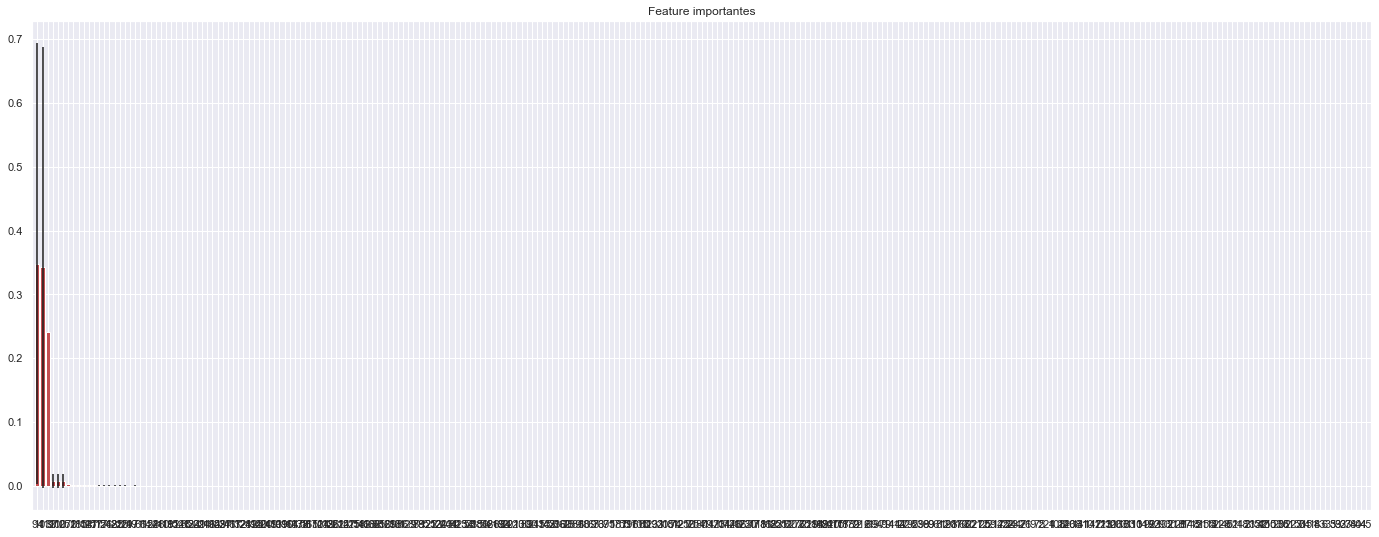

In [185]:
importances = forest.feature_importances_ #get the values of features
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0) #take the std from the feature selector
indices = np.argsort(importances)[::-1] #organize the indice by descendent

# Print the feature ranking
print("Feature ranking: ")
df = pd.DataFrame()
for i, j in zip(x_train_n.columns.values, forest.feature_importances_):
    aux = pd.DataFrame({'feature': i, 'importance': j}, index=[0])
    df = pd.concat([df, aux], axis=0)
    df = df.sort_values('importance', ascending=False)
    df['acumulative'] = df['importance'].cumsum()
    
print (df)

# Plot the impurity-bases feature importances of the forest
plt.figure()
plt.title('Feature importantes')
plt.bar(range(X_train_n.shape[1]), importances[indices], color='r',
        yerr=std[indices], align='center')
plt.xticks(range(X_train_n.shape[1]), indices)
plt.xlim([-1, X_train_n.shape[1]])
plt.show()

Feature ranking: 
                                   feature  importance  acumulative
0               prv_presenca_cnat_presente        0.35         0.35
0                prv_presenca_mat_presente        0.34         0.69
0                    prv_status_redacao_ok        0.24         0.93
0               prv_presenca_chum_presente        0.01         0.94
0               prv_presenca_ling_presente        0.01         0.95
0            prv_status_redacao_aus_elimin        0.01         0.96
0                          q024_res_comp_0        0.00         0.96
0                                 pt_idade        0.00         0.96
0                          q008_res_banh_1        0.00         0.96
0                      prv_lingua_espanhol        0.00         0.96
0            q002_mae_estudo_E_c_ens_medio        0.00         0.96
0                          q005_res_ocup_4        0.00         0.96
0             q001_pai_estudo_C_c_ens_fund        0.00         0.96
0                          q00

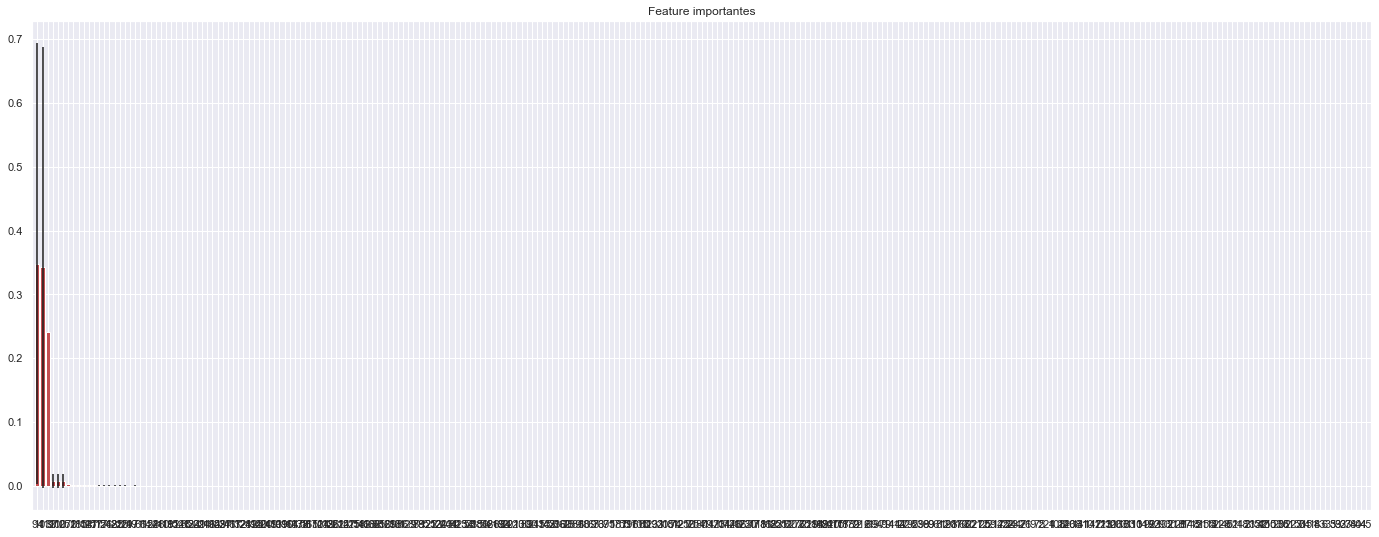

In [186]:
importances = forest.feature_importances_ #get the values of features
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0) #take the std from the feature selector
indices = np.argsort(importances)[::-1] #organize the indice by descendent

# Print the feature ranking
print("Feature ranking: ")
df = pd.DataFrame()
for i, j in zip(x_train_n.columns.values, forest.feature_importances_):
    aux = pd.DataFrame({'feature': i, 'importance': j}, index=[0])
    df = pd.concat([df, aux], axis=0)
    df = df.sort_values('importance', ascending=False)
    df['acumulative'] = df['importance'].cumsum()
    
print (df)

# Plot the impurity-bases feature importances of the forest
plt.figure()
plt.title('Feature importantes')
plt.bar(range(X_train_n.shape[1]), importances[indices], color='r',
        yerr=std[indices], align='center')
plt.xticks(range(X_train_n.shape[1]), indices)
plt.xlim([-1, X_train_n.shape[1]])
plt.show()

In [187]:
extra_tree_feat = df.iloc[0:68, ]['feature'].tolist()
extra_tree_feat

['prv_presenca_cnat_presente',
 'prv_presenca_mat_presente',
 'prv_status_redacao_ok',
 'prv_presenca_chum_presente',
 'prv_presenca_ling_presente',
 'prv_status_redacao_aus_elimin',
 'q024_res_comp_0',
 'pt_idade',
 'q008_res_banh_1',
 'prv_lingua_espanhol',
 'q002_mae_estudo_E_c_ens_medio',
 'q005_res_ocup_4',
 'q001_pai_estudo_C_c_ens_fund',
 'q005_res_ocup_3',
 'q022_res_cel_3',
 'q002_mae_estudo_C_c_ens_fund',
 'q016_res_mc_ondas_1',
 'q001_pai_estudo_E_c_ens_medio',
 'q022_res_cel_2',
 'q009_res_quarto_2',
 'pt_cor_raca_branca',
 'pt_cor_raca_parda',
 'q005_res_ocup_5',
 'q022_res_cel_1',
 'q013_res_freezer_1',
 'q001_pai_estudo_D_nc_ens_medio',
 'q009_res_quarto_3',
 'q005_res_ocup_2',
 'q002_mae_estudo_D_nc_ens_medio',
 'pt_cor_raca_preta',
 'q003_pai_ocup_D_tb_liberal',
 'q013_res_freezer_0',
 'q016_res_mc_ondas_0',
 'q001_pai_estudo_B_nc_ens_fund',
 'q010_res_carro_0',
 'q005_res_ocup_6',
 'q019_res_tv_1',
 'q020_res_dvd_0',
 'q006_fam_renda_E_1996_2495',
 'q003_pai_ocup_B_tb

# <font color='red'> 7.0 MACHINE LEARNING MODELLING </font>

In [188]:
x_train = X_train[extra_tree_feat].copy()
X_val = X_val[extra_tree_feat].copy()

In [189]:
x_training = x_train.copy()
x_training[['prv_nt_cnat', 'prv_nt_chum', 'prv_nt_ling', 'prv_nt_mat', 'prv_nt_redacao']] = y_train[['prv_nt_cnat', 'prv_nt_chum', 'prv_nt_ling', 'prv_nt_mat', 'prv_nt_redacao']]

## 7.1 LINEAR REGRESSION MODEL

In [190]:
#model
lr = LinearRegression().fit(x_train, y_train)

#prediction
yhat_lr = lr.predict(X_val)

yhat_lr_df = pd.DataFrame(yhat_lr, columns = ['prv_nt_cnat', 'prv_nt_chum', 'prv_nt_ling', 'prv_nt_mat', 'prv_nt_redacao'])

#performance
lr_result, lr_mcrmse  = ml_error('Linear Regression', np.expm1(y_val), np.expm1(yhat_lr_df))
lr_result

MCRMSE:  84.23333114425809


MAE  MAPE   RMSE
Linear Regression                    
prv_nt_cnat        50.56   inf  64.06
prv_nt_chum        57.88   inf  72.51
prv_nt_ling        42.67   inf  55.17
prv_nt_mat         70.72   inf  90.71
prv_nt_redacao    105.90   inf 138.72

### 7.2.1. LINEAR REGRESSION MODEL - CROSS VALIDATION

In [191]:
lr_result_cv, lr_mcrmse_cv = cross_validation(lr, 5, x_training, Verbose = True)
lr_result_cv

Fold Number 1/5
Fold Number 2/5
Fold Number 3/5
Fold Number 4/5
Fold Number 5/5
MCRMSE: 84.27722151265908 +/ -0.19523646734572736


MAE         MAPE                 RMSE
LinearRegression                                                       
prv_nt_cnat        50.6709 +/ -0.2702  inf +/ -nan   64.2592 +/ -0.3765
prv_nt_chum        58.0564 +/ -0.2226  inf +/ -nan   72.7727 +/ -0.3121
prv_nt_ling         42.6286 +/ -0.157  inf +/ -nan   55.3695 +/ -0.3303
prv_nt_mat         70.6642 +/ -0.2125  inf +/ -nan   90.6285 +/ -0.2668
prv_nt_redacao    105.6484 +/ -0.3217  inf +/ -nan  138.3563 +/ -0.2536

## 7.3 LINEAR REGRESSION REGULARIZED MODEL - LASSO

In [192]:
#model
lrr = Lasso(alpha=0.01).fit(x_train, y_train)

#prediction
yhat_lrr = lrr.predict(X_val)

yhat_lrr_df = pd.DataFrame(yhat_lrr, columns = ['prv_nt_cnat', 'prv_nt_chum', 'prv_nt_ling', 'prv_nt_mat', 'prv_nt_redacao'])

#performance
lrr_result, lrr_mcrmse = ml_error('Linear Regression - Lasso', np.expm1(y_val), np.expm1(yhat_lrr_df))
lrr_result

MCRMSE:  90.64704995834879


MAE  MAPE   RMSE
Linear Regression - Lasso                    
prv_nt_cnat                55.35   inf  69.77
prv_nt_chum                63.50   inf  78.19
prv_nt_ling                48.08   inf  60.75
prv_nt_mat                 76.25   inf  97.78
prv_nt_redacao            110.87   inf 146.73

### 7.3.1. LINEAR REGRESSION REGULARIZED MODEL - LASSO - CROSS VALIDATION

In [193]:
lrr_result_cv, lrr_mcrmse_cv = cross_validation(lrr, 5, x_training, Verbose = True)
lrr_result_cv

Fold Number 1/5
Fold Number 2/5
Fold Number 3/5
Fold Number 4/5
Fold Number 5/5
MCRMSE: 90.58773723751071 +/ -0.129647022500812


MAE         MAPE                 RMSE
Lasso                                                               
prv_nt_cnat      55.378 +/ -0.2391  inf +/ -nan   69.8733 +/ -0.3235
prv_nt_chum     63.5102 +/ -0.2112  inf +/ -nan   78.2151 +/ -0.2489
prv_nt_ling     48.0792 +/ -0.2017  inf +/ -nan   60.9436 +/ -0.4078
prv_nt_mat      75.9865 +/ -0.1696  inf +/ -nan    97.5833 +/ -0.185
prv_nt_redacao  110.4201 +/ -0.321  inf +/ -nan  146.3234 +/ -0.3335

## 7.4. RANDOM FOREST REGRESSOR

In [194]:
#model
rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42).fit(x_train, y_train)

#prediction
yhat_rf = rf.predict(X_val)

yhat_rf_df = pd.DataFrame(yhat_rf, columns = ['prv_nt_cnat', 'prv_nt_chum', 'prv_nt_ling', 'prv_nt_mat', 'prv_nt_redacao'])

#performance
rf_result, rf_mcrmse = ml_error('Random Forest Regressor', np.expm1(y_val), np.expm1(yhat_rf_df))
rf_result

MCRMSE:  87.40274279839451


MAE  MAPE   RMSE
Random Forest Regressor                    
prv_nt_cnat              51.25   inf  65.88
prv_nt_chum              60.06   inf  77.45
prv_nt_ling              44.29   inf  59.12
prv_nt_mat               71.26   inf  92.28
prv_nt_redacao          108.90   inf 142.29

### 7.4.1. RANDOM FOREST REGRESSOR - CROSS VALIDATION

In [195]:
rf_result_cv, rf_mcrmse_cv = cross_validation(rf, 5, x_training, Verbose = True)
rf_result_cv

Fold Number 1/5
Fold Number 2/5
Fold Number 3/5
Fold Number 4/5
Fold Number 5/5
MCRMSE: 87.54433362762431 +/ -0.16471852434629336


MAE         MAPE                 RMSE
RandomForestRegressor                                                       
prv_nt_cnat             51.3576 +/ -0.2636  inf +/ -nan   66.0482 +/ -0.4207
prv_nt_chum             60.6454 +/ -0.1315  inf +/ -nan   78.4275 +/ -0.3392
prv_nt_ling              44.509 +/ -0.1563  inf +/ -nan   59.6423 +/ -0.3528
prv_nt_mat              71.0996 +/ -0.2781  inf +/ -nan   92.0434 +/ -0.3189
prv_nt_redacao         108.4227 +/ -0.2449  inf +/ -nan  141.5603 +/ -0.1733

## 7.5. XGBOOST REGRESSOR

###### MODEL

In [196]:
y_indice = y_train.columns.tolist()
yhat_xgb = []
for i in y_indice:
    #model
    model_xgb = xgb.XGBRegressor().fit(x_train, y_train[i])
    
    #prediction
    yhat_xgb_ = model_xgb.predict(X_val)
    yhat_xgb.append(yhat_xgb_)

yhat_xgb_df = pd.DataFrame(yhat_xgb).T
yhat_xgb_df.columns = ['prv_nt_cnat', 'prv_nt_chum', 'prv_nt_ling', 'prv_nt_mat', 'prv_nt_redacao']

#performance
xgb_result, xgb_mcrmse = ml_error('XGBoost Regressor', np.expm1(y_val), np.expm1(yhat_xgb_df))
xgb_result

D:\Anaconda\programa\envs\kaggle_challenge\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


MCRMSE:  84.63453910241172


MAE  MAPE   RMSE
XGBoost Regressor                    
prv_nt_cnat        49.81   inf  63.66
prv_nt_chum        58.28   inf  74.62
prv_nt_ling        43.20   inf  57.87
prv_nt_mat         69.31   inf  89.46
prv_nt_redacao    105.00   inf 137.56

### 7.5.1. XGBOOST REGRESSOR - CROSS VALIDATION

In [197]:
xgb_result_cv, xgb_mcrmse_cv = cross_validation(xgb, 5, x_training, Verbose = True)
xgb_result_cv

Fold Number 1/5


D:\Anaconda\programa\envs\kaggle_challenge\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Fold Number 2/5


D:\Anaconda\programa\envs\kaggle_challenge\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Fold Number 3/5


D:\Anaconda\programa\envs\kaggle_challenge\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Fold Number 4/5


D:\Anaconda\programa\envs\kaggle_challenge\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Fold Number 5/5


D:\Anaconda\programa\envs\kaggle_challenge\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


MCRMSE: 84.89253757451286 +/ -0.17680956276776832


MAE         MAPE                 RMSE
module                                                               
prv_nt_cnat      50.1033 +/ -0.2854  inf +/ -nan    64.0232 +/ -0.323
prv_nt_chum      58.7449 +/ -0.2622  inf +/ -nan    75.563 +/ -0.2616
prv_nt_ling       43.309 +/ -0.2005  inf +/ -nan   58.0846 +/ -0.3796
prv_nt_mat       69.3315 +/ -0.2466  inf +/ -nan   89.5547 +/ -0.3185
prv_nt_redacao  104.9331 +/ -0.3266  inf +/ -nan  137.2372 +/ -0.2148

## 7.6 COMPARE MODEL´S PERFORMANCE

### 7.6.1 SINGLE PERFORMANCE

In [198]:
modelling_result = pd.DataFrame([lr_mcrmse, lrr_mcrmse, rf_mcrmse, xgb_mcrmse])
modelling_result.columns = ['MCRMSE']
modelling_result.index = ['Linear Regression', 'Lasso', 'Random Forest', 'XGBoost']
modelling_result.sort_values('MCRMSE')

MCRMSE
Linear Regression   84.23
XGBoost             84.63
Random Forest       87.40
Lasso               90.65

### 7.6.2 REAL PERFORMANCE - CROSS VALIDATION

In [199]:
modelling_result_cv = pd.concat([lr_mcrmse_cv, lrr_mcrmse_cv, rf_mcrmse_cv, xgb_mcrmse_cv])
modelling_result_cv.columns = ['MCRMSE CV', 'SD']
modelling_result_cv.index = ['Linear Regression', 'Lasso', 'Random Forest', 'XGBoost']
modelling_result_cv.sort_values('MCRMSE CV')

MCRMSE CV   SD
Linear Regression      84.28 0.20
XGBoost                84.89 0.18
Random Forest          87.54 0.16
Lasso                  90.59 0.13

### 7.6.3. Teste Final

In [200]:
df5_r.head()

pt_nu_inscricao  pt_idade pt_sexo pt_estado_civil pt_cor_raca pt_nacionalidade pt_conclusao_ensmedio pt_ano_conc_ensmedio pt_tp_escola pt_treineiro pt_baixa_visao pt_cegueira pt_surdez pt_deficiencia_auditiva pt_surdo_cegueira pt_deficiencia_fisica pt_deficiencia_mental pt_deficit_atencao pt_dislexia pt_discalculia pt_autismo pt_visao_monocular pt_outra_def pt_gestante pt_lactante pt_idoso pt_estuda_classe_hospitalar prv_sem_recurso prv_in_braille prv_ampliada_24 prv_ampliada_18 prv_aux_leitura prv_acesso_fc_sala prv_transcricao prv_libras prv_tempo_adicional prv_leitura_labial prv_mesa_cadeira_rodas prv_mesa_cadeira_separada prv_apoio_perna prv_guia_interprete prv_computador prv_cadeira_especial prv_cadeira_canhoto prv_cadeira_acolchoada prv_prova_deitado prv_mobiliario_obeso prv_lamina_overlay prv_protetor_auricular prv_medidor_glicose prv_maquina_braile prv_soroban prv_marca_passo prv_sonda prv_medicamentos prv_sala_individual prv_sala_especial prv_sala_acompanhante prv_mobiliario_especifico prv_material_especifico prv_nome_social prv_presenca_cnat prv_presenca_chum prv_presenca_ling prv_presenca_mat prv_lingua prv_status_redacao q001_pai_estudo q002_mae_estudo      q003_pai_ocup  q004_mae_ocup q005_res_ocup q006_fam_renda q007_res_empreg q008_res_banh q009_res_quarto q010_res_carro q011_res_moto q012_res_gelad q013_res_freezer q014_res_mlr q015_res_msr q016_res_mc_ondas q017_res_mll q018_res_aspipo q019_res_tv q020_res_dvd q021_res_tv_assin q022_res_cel q023_res_telfx q024_res_comp q025_res_internet  prv_nt_cnat  prv_nt_chum  prv_nt_ling  prv_nt_mat  prv_nt_redacao  nota_ponderada
3   1ebc29c1-570e-40f4-a580-1d509e24bc91     26.00       f        solteiro       parda          br_nato             concluido                 2015      publica            0              0           0         0                       0                 0                     0                     0                  0           0              0          0                  0            0           0           0        0                           0               0              0               0               0               0                  0               0          0                   0                  0                      0                         0               0                   0              0                    0                   0                      0                 0                    0                  0                      0                   0                  0           0               0         0                0                   0                 0                     0                         0                       0               0          presente          presente          presente         presente   espanhol                 ok       H_naosabe   B_nc_ens_fund         A_tb_rural  B_tb_auxiliar             6      B_ate_998           0_sem             1               3              0             0              1                0            1            0                 1            0               0           1            0                 0            3              0             1                 1       392.20       387.30       414.40      492.20          560.00          456.49
5   5f2c2f24-5088-4248-bd2a-89a219d1d8e8     18.00       f        solteiro       parda          br_nato     term_ano_corrente                   nd      privada            0              0           0         0                       0                 0                     0                     0                  0           0              0          0                  0            0           0           0        0                           0               0              0               0               0               0                  0               0          0                   0                  0                      0                         0               0                   0              0                    0                   0 

# <font color='red'> 8.0 HYPERPARAMETER FINE TUNNING </font>

# <font color='red'> 9.0. TEST DATASET </font>

In [ ]:
def data_description(df0):
    df1 = df0.copy()
    df1.head()
    
    ## 1.1. Rename columuns
    
    df1.columns
    
    # storing columns names
    cols_old = [
        #01 DADOS DO PARTICIPANTE
        'PT_NU_INSCRICAO', 'PT_CO_MUNICIPIO_RESIDENCIA', 'PT_NO_MUNICIPIO_RESIDENCIA', 'PT_CO_UF_RESIDENCIA', 'PT_SG_UF_RESIDENCIA', 'PT_IDADE', 'PT_SEXO', 
        'PT_ESTADO_CIVIL', 'PT_COR_RACA', 'PT_NACIONALIDADE','PT_CO_MUNICIPIO_NASCIMENTO', 'PT_NM_MUNICIPIO_NASCIMENTO', 'PT_CO_UF_NASCIMENTO', 'PT_SG_UF_NASCIMENTO', 
        'PT_CONCLUSAO_ENSMEDIO', 'PT_ANO_CONC_ENSMEDIO', 'PT_TP_ESCOLA', 'PT_TP_ENSINO', 'PT_TREINEIRO',
        #02 DADOS DA ESCOLA
        'ESC_CODIGO', 'ESC_CO_MUNICIPIO', 'ESC_NO_MUNICIPIO', 'ESC_CO_UF', 'ESC_SG_UF', 'ESC_TP_DEPENDENCIA_ADM', 'ESC_TP_LOCALIZACAO', 'ESC_SIT_FUNC',
        #03 DADOS DOS PEDIDOS DE ATENDIMENTO ESPECIALIZADO
        'PT_BAIXA_VISAO', 'PT_CEGUEIRA', 'PT_SURDEZ', 'PT_DEFICIENCIA_AUDITIVA', 'PT_SURDO_CEGUEIRA', 'PT_DEFICIENCIA_FISICA', 'PT_DEFICIENCIA_MENTAL', 'PT_DEFICIT_ATENCAO', 'PT_DISLEXIA',
        'PT_DISCALCULIA', 'PT_AUTISMO', 'PT_VISAO_MONOCULAR', 'PT_OUTRA_DEF',
        #DADOS DOS PEDIDOS DE ATENDIMENTO ESPECIFICO
        'PT_GESTANTE', 'PT_LACTANTE', 'PT_IDOSO', 'PT_ESTUDA_CLASSE_HOSPITALAR',
        #DADOS DOS PEDIDOS DE RECURSOS ESPECIALIZADOS E ESPECÍFICOS PARA REALIZAÇÃO DAS PROVAS
        'PRV_SEM_RECURSO', 'PRV_IN_BRAILLE', 'PRV_AMPLIADA_24', 'PRV_AMPLIADA_18', 'PRV_AUX_LEITURA', 'PRV_ACESSO_FC_SALA', 'PRV_TRANSCRICAO', 'PRV_LIBRAS', 'PRV_TEMPO_ADICIONAL', 
        'PRV_LEITURA_LABIAL', 'PRV_MESA_CADEIRA_RODAS', 'PRV_MESA_CADEIRA_SEPARADA', 'PRV_APOIO_PERNA', 'PRV_GUIA_INTERPRETE', 'PRV_COMPUTADOR', 'PRV_CADEIRA_ESPECIAL', 
        'PRV_CADEIRA_CANHOTO', 'PRV_CADEIRA_ACOLCHOADA', 'PRV_PROVA_DEITADO', 'PRV_MOBILIARIO_OBESO',  'PRV_LAMINA_OVERLAY', 'PRV_PROTETOR_AURICULAR', 'PRV_MEDIDOR_GLICOSE', 
        'PRV_MAQUINA_BRAILE', 'PRV_SOROBAN', 'PRV_MARCA_PASSO', 'PRV_SONDA', 'PRV_MEDICAMENTOS', 'PRV_SALA_INDIVIDUAL', 'PRV_SALA_ESPECIAL',
        'PRV_SALA_ACOMPANHANTE', 'PRV_MOBILIARIO_ESPECIFICO', 'PRV_MATERIAL_ESPECIFICO', 'PRV_NOME_SOCIAL',
        #DADOS DO LOCAL DE APLICAÇÃO DA PROVA
        'PRV_CO_MUNICIPIO', 'PRV_NO_MUNICIPIO', 'PRV_CO_UF', 'PRV_SG_UF',
        #DADOS DA PROVA OBJETIVA
        'PRV_PRESENCA_CNAT', 'PRV_PRESENCA_CHUM', 'PRV_PRESENCA_LING', 'PRV_PRESENCA_MAT', 'PRV_NT_CNAT', 'PRV_NT_CHUM', 'PRV_NT_LING', 'PRV_NT_MAT', 'PRV_LINGUA',
        #DADOS DA REDAÇÃO
        'PRV_STATUS_REDACAO', 'PRV_NT_REDACAO',
        #DADOS DO QUESTIONÁRIO SOCIOECONÔMICO
        'Q001_pai_estudo', 'Q002_mae_estudo', 'Q003_pai_ocup', 'Q004_mae_ocup', 'Q005_res_ocup', 
        'Q006_fam_renda', 'Q007_res_empreg', 'Q008_res_banh', 'Q009_res_quarto', 'Q010_res_carro',
        'Q011_res_moto', 'Q012_res_gelad', 'Q013_res_freezer', 'Q014_res_mlr', 'Q015_res_msr', 
        'Q016_res_mc_ondas', 'Q017_res_mll', 'Q018_res_aspipo', 'Q019_res_tv', 'Q020_res_dvd',
        'Q021_res_tv_assin', 'Q022_res_cel', 'Q023_res_telfx', 'Q024_res_comp', 'Q025_res_internet']
    
    # transforming to underscore the names and put into lowcase
    snakecase = lambda x: inflection.underscore( x )
    
    # creating a list with a new snakecase columns name and indicating the new one
    cols_new = list( map( snakecase, cols_old ) )
    
    #renaming columns name
    df1.columns = cols_new
    
    ### 1.5.1. Analise NA
    
    df1_ = df1.copy()
    
    # como são pouco os valores, será removido os NA de idade
    df1_ = df1_.dropna(subset='pt_idade')
    
    # Para este ciclo será removido as features relacionadas a dados de nascimento
    df1_ = df1_.drop(columns=['pt_co_municipio_nascimento', 'pt_nm_municipio_nascimento', 'pt_co_uf_nascimento', 'pt_sg_uf_nascimento'])
    
    df1_ = df1_.drop(columns=['pt_tp_ensino'])
    
    # remover os dados da escola - avaliar no próximo ciclo
    df1_ = df1_.drop(columns=['esc_codigo', 'esc_co_municipio', 'esc_no_municipio', 'esc_co_uf', 'esc_sg_uf', 'esc_tp_dependencia_adm', 'esc_tp_localizacao', 'esc_sit_func'])
    
    #### nota das provas: Ciências da Natureza / Ciências Humanas / Linguagens e Codigos / Matematica - Os valores NA referem-se a ausência ou eliminação da prova
    
    # prova de ciências naturais
    df1_['prv_nt_cnat'] = df1_.apply(lambda x: 0 if (x['prv_presenca_cnat'] == 0) | (x['prv_presenca_cnat'] == 2) else x['prv_nt_cnat'], axis=1)
    
    # prova de ciências naturais
    df1_['prv_nt_chum'] = df1_.apply(lambda x: 0 if (x['prv_presenca_chum'] == 0) | (x['prv_presenca_chum'] == 2) else x['prv_nt_chum'], axis=1)
    
    # prova de linguagens e codigo
    df1_['prv_nt_ling'] = df1_.apply(lambda x: 0 if (x['prv_presenca_ling'] == 0) | (x['prv_presenca_ling'] == 2) else x['prv_nt_ling'], axis=1)
    
    # prova de matematica
    df1_['prv_nt_mat'] = df1_.apply(lambda x: 0 if (x['prv_presenca_mat'] == 0) | (x['prv_presenca_mat'] == 2) else x['prv_nt_mat'], axis=1)
    
    #### nota das provas: Redação - Os valores NA referem-se a ausência ou eliminação da prova
    
    # prova de redação
    df1_['prv_nt_redacao'] = df1_.apply(lambda x: 0 if (x['prv_presenca_ling'] == 0) | (x['prv_presenca_ling'] == 2) else x['prv_nt_redacao'], axis=1)
    
    df1_['prv_status_redacao'] = df1_.apply(lambda x: 10 if (x['prv_presenca_ling'] == 0) | (x['prv_presenca_ling'] == 2) else x['prv_status_redacao'], axis=1)
    
    # existe uma anula que esteve presente em todas as provas, porém não é indicada a nota da redação. Este dado será removido do DF
    df1_[df1_['prv_status_redacao'].isna()]
    
    df1_ = df1_.dropna(subset='prv_status_redacao')
    return df1_

def feature_engeneering(df1):
    df2 = df1.copy()
    
    ##  2.1. PARTICIPANTE - LOCAL
    df2['pt_no_municipio_residencia'] = df2['pt_no_municipio_residencia'].apply(lambda x: x.lower())
    
    ##  2.1. PARTICIPANTE - DADOS PESSOAIS
    ### pt_sexo
    
    df2['pt_sexo'] = df2['pt_sexo'].apply(lambda x: x.lower())
    
    ### pt_estado_civil
    dict_ = {0:'nd', 1:'solteiro', 2:'casado', 3:'divorciado', 4:'viuvo'}
    df2['pt_estado_civil'] = df2['pt_estado_civil'].map(dict_)
    
    ### pt_cor_raca
    dict_ = {0:'nd', 1:'branca', 2:'preta', 3:'parda', 4:'amarela', 5:'indigina'}
    df2['pt_cor_raca'] = df2['pt_cor_raca'].map(dict_)
    
    ### pt_nacionalidade
    dict_ = {0:'nd', 1:'br_nato', 2:'br_natur', 3:'estrang', 4:'br_nasc_estrang'}
    df2['pt_nacionalidade'] = df2['pt_nacionalidade'].map(dict_)
    
    ### pt_conclusao_ensmedio
    dict_ = {1:'concluido', 2:'term_ano_corrente', 3:'term_prox_ano', 4:'nao_conc_n_ensmed'}
    df2['pt_conclusao_ensmedio'] = df2['pt_conclusao_ensmedio'].map(dict_)
    
    ### pt_ano_conc_ensmedio
    dict_ = {0:'nd', 1:'2018', 2:'2017', 3:'2016', 4:'2015', 5:'2014', 6:'2013', 7:'2012', 8:'2011', 9:'2010', 10:'2009',11:'2008', 12:'2007', 13:'antes_2007'}
    df2['pt_ano_conc_ensmedio'] = df2['pt_ano_conc_ensmedio'].map(dict_)
    
    ### pt_tp_escola
    dict_ = {0:'nd', 1:'publica', 2:'privada', 3:'exterior'}
    df2['pt_tp_escola'] = df2['pt_tp_escola'].map(dict_)
    
    ##  2.2. DADOS DA ESCOLA
    
    ##  2.4. ATENDIMENTO ESPECIFICO
    
    ##  2.5. RECURSOS ESPECIALIZADOS PARA REALIZAÇÃO DAS PROVAS
    
    ##  2.6. LOCAL DE APLICAÇÃO DA PROVA
    
    ##  2.7. DADOS DA PROVA
    dict_ = {0: 'faltou', 1: 'presente', 2: 'eliminado'}
    df2['prv_presenca_cnat'] = df2['prv_presenca_cnat'].map(dict_)
    df2['prv_presenca_chum'] = df2['prv_presenca_chum'].map(dict_)
    df2['prv_presenca_ling'] = df2['prv_presenca_ling'].map(dict_)
    df2['prv_presenca_mat'] = df2['prv_presenca_mat'].map(dict_)
    
    dict_ = {0: 'ingles', 1: 'espanhol'}
    df2['prv_lingua'] = df2['prv_lingua'].map(dict_)
    
    dict_ = {1: 'ok', 2: 'anulada', 3: 'cptxt_motivador', 4: 'em_branco', 6: 'fuga_tema', 7: 'n_atend_textual', 8: 'txt_insuf', 9: 'pt_desconec', 10: 'aus_elimin'}
    df2['prv_status_redacao'] = df2['prv_status_redacao'].map(dict_)
    
    ### 2.7.1. Nota Ponderada
    df2['nota_ponderada'] = (df2['prv_nt_cnat']*3 + df2['prv_nt_chum']*1 + df2['prv_nt_ling']*2 + df2['prv_nt_mat']*1 + df2['prv_nt_redacao']*3)/10
    
    ##  2.8. QUESTIONARIOS SOCIOECONOMICOS
    dict_ = {'A': 'A_s_estudo', 'B': 'B_nc_ens_fund', 'C': 'C_c_ens_fund', 'D': 'D_nc_ens_medio', 'E': 'E_c_ens_medio', 'F': 'F_c_ens_sup', 'G': 'G_c_pos_grad', 'H': 'H_naosabe'}
    df2['q001_pai_estudo'] = df2['q001_pai_estudo'].map(dict_)
    
    dict_ = {'A': 'A_s_estudo', 'B': 'B_nc_ens_fund', 'C': 'C_c_ens_fund', 'D': 'D_nc_ens_medio', 'E': 'E_c_ens_medio', 'F': 'F_c_ens_sup', 'G': 'G_c_pos_grad', 'H': 'H_naosabe'}
    df2['q002_mae_estudo'] = df2['q002_mae_estudo'].map(dict_)
    
    dict_ = {'A': 'A_tb_rural', 'B': 'B_tb_auxiliar', 'C': 'C_tb_oficial', 'D': 'D_tb_liberal', 'E': 'E_tb_profissional', 'F': 'F_naosei'}
    df2['q003_pai_ocup'] = df2['q003_pai_ocup'].map(dict_)
    
    dict_ = {'A': 'A_tb_rural', 'B': 'B_tb_auxiliar', 'C': 'C_tb_oficial', 'D': 'D_tb_liberal', 'E': 'E_tb_profissional', 'F': 'F_naosei'}
    df2['q004_mae_ocup'] = df2['q004_mae_ocup'].map(dict_)
    
    dict_ = {'A': 'A_nenhuma', 'B': 'B_ate_998', 'C': 'C_998_1497', 'D': 'D_1497_1996', 'E': 'E_1996_2495', 'F': 'F_2495_2994', 'G': 'G_2994_3992', 'H': 'H_3992_4990', 'I': 'I_4990_5988', 'J': 'J_5988_6986', 'K': 'K_6986_7984', 'L': 'L_7984_8982',
             'M': 'M_8982_9980', 'N': 'N_9980_11976', 'O': 'O_11976_14960', 'P': 'P_14960_19960', 'Q': 'Q_maior_19960'}
    df2['q006_fam_renda'] = df2['q006_fam_renda'].map(dict_)
    
    dict_ = {'A': '0_sem', 'B': '1a2_sem', 'C': '3a4_sem', 'D': '5oum_sem'}
    df2['q007_res_empreg'] = df2['q007_res_empreg'].map(dict_)
    
    dict_ = {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4}
    df2['q008_res_banh'] = df2['q008_res_banh'].map(dict_)
    
    dict_ = {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4}
    df2['q009_res_quarto'] = df2['q009_res_quarto'].map(dict_)
    
    dict_ = {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4}
    df2['q010_res_carro'] = df2['q010_res_carro'].map(dict_)
    
    dict_ = {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4}
    df2['q011_res_moto'] = df2['q011_res_moto'].map(dict_)
    
    dict_ = {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4}
    df2['q012_res_gelad'] = df2['q012_res_gelad'].map(dict_)
    
    dict_ = {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4}
    df2['q013_res_freezer'] = df2['q013_res_freezer'].map(dict_)
    
    dict_ = {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4}
    df2['q014_res_mlr'] = df2['q014_res_mlr'].map(dict_)
    
    dict_ = {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4}
    df2['q015_res_msr'] = df2['q015_res_msr'].map(dict_)
    
    dict_ = {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4}
    df2['q016_res_mc_ondas'] = df2['q016_res_mc_ondas'].map(dict_)
    
    dict_ = {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4}
    df2['q017_res_mll'] = df2['q017_res_mll'].map(dict_)
    
    dict_ = {'A': 0, 'B': 1}
    df2['q018_res_aspipo'] = df2['q018_res_aspipo'].map(dict_)
    
    dict_ = {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4}
    df2['q019_res_tv'] = df2['q019_res_tv'].map(dict_)
    
    dict_ = {'A': 0, 'B': 1}
    df2['q020_res_dvd'] = df2['q020_res_dvd'].map(dict_)
    
    dict_ = {'A': 0, 'B': 1}
    df2['q021_res_tv_assin'] = df2['q021_res_tv_assin'].map(dict_)
    
    dict_ = {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4}
    df2['q022_res_cel'] = df2['q022_res_cel'].map(dict_)
    
    dict_ = {'A': 0, 'B': 1}
    df2['q023_res_telfx'] = df2['q023_res_telfx'].map(dict_)
    
    dict_ = {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4}
    df2['q024_res_comp'] = df2['q024_res_comp'].map(dict_)
    
    dict_ = {'A': 0, 'B': 1}
    df2['q025_res_internet'] = df2['q025_res_internet'].map(dict_)
    
    return df2

def data_preparation(df4):
    df5 = df4.copy()
    # covertendo os dados para string - PARTICIPANTE
    df5.iloc[:, 13:65] = df5.iloc[:, 13:65].astype('str')
    df5.iloc[:, 75:-6] = df5.iloc[:, 75:-6].astype('str')
    
    df5 = df5.drop(columns=['pt_co_municipio_residencia' ,'pt_no_municipio_residencia','pt_co_uf_residencia' ,'pt_sg_uf_residencia', 
                            'prv_co_municipio', 'prv_no_municipio', 'prv_co_uf', 'prv_sg_uf'])
    
    df5_r = df5.copy()
    
    df5_r_presente = df5_r[(df5_r['prv_presenca_ling'] == 'presente') | (df5_r['prv_presenca_cnat'] == 'presente')].copy()
    
    df5_r_ausente = df5_r[~((df5_r['prv_presenca_ling'] == 'presente') | (df5_r['prv_presenca_cnat'] == 'presente'))].copy()
    
    ## 5.1. NORMALIZATION
    
    ## 5.2. RESCALLING
    mms_columns = ['pt_idade']
    
    #Min-Max Scaler
    mms = MinMaxScaler()
    df5_r_presente[mms_columns] = mms.fit_transform(df5_r_presente[mms_columns])
    
    ## 5.3. TRANSFORMATION
    ### 5.3.1 ENCODING
    # Convertendo em int os dados sobre o participante e solicitações de prova (0 ou 1)
    df5_r_presente.iloc[:, 9:61] = df5_r.iloc[:, 9:61].astype('int')
    
    # state_holiday - One Hot Encoding
    df5_r_presente = pd.get_dummies(df5_r_presente, prefix=['pt_sexo'], columns=['pt_sexo'])
    df5_r_presente = pd.get_dummies(df5_r_presente, prefix=['pt_estado_civil'], columns=['pt_estado_civil'])
    df5_r_presente = pd.get_dummies(df5_r_presente, prefix=['pt_cor_raca'], columns=['pt_cor_raca'])
    df5_r_presente = pd.get_dummies(df5_r_presente, prefix=['pt_nacionalidade'], columns=['pt_nacionalidade'])
    df5_r_presente = pd.get_dummies(df5_r_presente, prefix=['pt_conclusao_ensmedio'], columns=['pt_conclusao_ensmedio'])
    df5_r_presente = pd.get_dummies(df5_r_presente, prefix=['pt_ano_conc_ensmedio'], columns=['pt_ano_conc_ensmedio'])
    df5_r_presente = pd.get_dummies(df5_r_presente, prefix=['pt_tp_escola'], columns=['pt_tp_escola'])
    
    # Dados relativos a prova - One Hot Encoding
    df5_r_presente = pd.get_dummies(df5_r_presente, prefix=['prv_presenca_cnat'], columns=['prv_presenca_cnat'])
    df5_r_presente = pd.get_dummies(df5_r_presente, prefix=['prv_presenca_chum'], columns=['prv_presenca_chum'])
    df5_r_presente = pd.get_dummies(df5_r_presente, prefix=['prv_presenca_ling'], columns=['prv_presenca_ling'])
    df5_r_presente = pd.get_dummies(df5_r_presente, prefix=['prv_presenca_mat'], columns=['prv_presenca_mat'])
    df5_r_presente = pd.get_dummies(df5_r_presente, prefix=['prv_lingua'], columns=['prv_lingua'])
    df5_r_presente = pd.get_dummies(df5_r_presente, prefix=['prv_status_redacao'], columns=['prv_status_redacao'])
    
    # Dados relativos a questionário social - One Hot Encoding
    df5_r_presente = pd.get_dummies(df5_r_presente, prefix=['q001_pai_estudo'], columns=['q001_pai_estudo'])
    df5_r_presente = pd.get_dummies(df5_r_presente, prefix=['q002_mae_estudo'], columns=['q002_mae_estudo'])
    df5_r_presente = pd.get_dummies(df5_r_presente, prefix=['q003_pai_ocup'], columns=['q003_pai_ocup'])
    df5_r_presente = pd.get_dummies(df5_r_presente, prefix=['q004_mae_ocup'], columns=['q004_mae_ocup'])
    df5_r_presente = pd.get_dummies(df5_r_presente, prefix=['q005_res_ocup'], columns=['q005_res_ocup'])
    df5_r_presente = pd.get_dummies(df5_r_presente, prefix=['q006_fam_renda'], columns=['q006_fam_renda'])
    df5_r_presente = pd.get_dummies(df5_r_presente, prefix=['q007_res_empreg'], columns=['q007_res_empreg'])
    df5_r_presente = pd.get_dummies(df5_r_presente, prefix=['q008_res_banh'], columns=['q008_res_banh'])
    df5_r_presente = pd.get_dummies(df5_r_presente, prefix=['q009_res_quarto'], columns=['q009_res_quarto'])
    df5_r_presente = pd.get_dummies(df5_r_presente, prefix=['q010_res_carro'], columns=['q010_res_carro'])
    df5_r_presente = pd.get_dummies(df5_r_presente, prefix=['q011_res_moto'], columns=['q011_res_moto'])
    df5_r_presente = pd.get_dummies(df5_r_presente, prefix=['q012_res_gelad'], columns=['q012_res_gelad'])
    df5_r_presente = pd.get_dummies(df5_r_presente, prefix=['q013_res_freezer'], columns=['q013_res_freezer'])
    df5_r_presente = pd.get_dummies(df5_r_presente, prefix=['q014_res_mlr'], columns=['q014_res_mlr'])
    df5_r_presente = pd.get_dummies(df5_r_presente, prefix=['q015_res_msr'], columns=['q015_res_msr'])
    df5_r_presente = pd.get_dummies(df5_r_presente, prefix=['q016_res_mc_ondas'], columns=['q016_res_mc_ondas'])
    df5_r_presente = pd.get_dummies(df5_r_presente, prefix=['q017_res_mll'], columns=['q017_res_mll'])
    df5_r_presente = pd.get_dummies(df5_r_presente, prefix=['q018_res_aspipo'], columns=['q018_res_aspipo'])
    df5_r_presente = pd.get_dummies(df5_r_presente, prefix=['q019_res_tv'], columns=['q019_res_tv'])
    df5_r_presente = pd.get_dummies(df5_r_presente, prefix=['q020_res_dvd'], columns=['q020_res_dvd'])
    df5_r_presente = pd.get_dummies(df5_r_presente, prefix=['q021_res_tv_assin'], columns=['q021_res_tv_assin'])
    df5_r_presente = pd.get_dummies(df5_r_presente, prefix=['q022_res_cel'], columns=['q022_res_cel'])
    df5_r_presente = pd.get_dummies(df5_r_presente, prefix=['q023_res_telfx'], columns=['q023_res_telfx'])
    df5_r_presente = pd.get_dummies(df5_r_presente, prefix=['q024_res_comp'], columns=['q024_res_comp'])
    df5_r_presente = pd.get_dummies(df5_r_presente, prefix=['q025_res_internet'], columns=['q025_res_internet'])
    
    ### 5.3.2. RESPONSE VARIABLE TRANSFORMATION
    df5_r_presente['prv_nt_cnat'] = np.log1p(df5_r_presente['prv_nt_cnat'])
    df5_r_presente['prv_nt_chum'] = np.log1p(df5_r_presente['prv_nt_chum'])
    df5_r_presente['prv_nt_ling'] = np.log1p(df5_r_presente['prv_nt_ling'])
    df5_r_presente['prv_nt_mat'] = np.log1p(df5_r_presente['prv_nt_mat'])
    df5_r_presente['prv_nt_redacao'] = np.log1p(df5_r_presente['prv_nt_redacao'])
    df5_r_presente = df5_r_presente.drop(columns='nota_ponderada')
    return df5_r_presente, df5_r_ausente, df5_r


In [ ]:
df1 = pd.read_csv('../../data/c1/c01_01_enem_treino.csv')

In [ ]:
df2 = feature_engeneering(df1)
df5_pr, df5_au, df5_r = data_preparation(df2)
df5_pr.head()

# <font color='red'> 10.0. EDA </font>

# <font color='red'> 11.0. BUSINESS PROBLEM ANSWER </font>